🖥️  Using device: cuda
   GPU: NVIDIA RTX A1000
   Memory: 8.59 GB

🤖 TRANSFORMER RL PAINTER: SIMPLE → COMPLEX

✨ KEY IMPROVEMENTS:
  1. Vision Transformer (ViT) encoder with patch embeddings
  2. Multi-head self-attention (8 heads, 6 layers)
  3. 2D positional encodings for spatial awareness
  4. CLS token for global representation
  5. GELU activations and LayerNorm
  6. AdamW optimizer with weight decay
  7. Better long-range dependency modeling

🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨
SHAPE: CIRCLE
🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨
🤖 Initializing Vision Transformer Policy...
   Total parameters: 5,286,802
   Trainable parameters: 5,286,802
  🔍 Edge Detection: Outline=624px (49.6%), Interior=925px (73.6%)
✓ Network on cuda | Config: BC=60, RL=600, Demos=60

TRAINING: CIRCLE ⭐ (TRANSFORMER)

📚 Generating DENSE Expert Demos for CIRCLE
✓ Generated 60 demos (avg length: 289)
✓ Collected 17280 state-action pairs

🎓 Phase 1: Transformer BC (60 epochs)
Epoch   0 | Loss: 4.3862 | MSE: 0.0553 

C:\Users\user\AppData\Local\Temp\ipykernel_3908\736269054.py:1087: UserWarning: Glyph 128308 (\N{LARGE RED CIRCLE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\user\AppData\Local\Temp\ipykernel_3908\736269054.py:1087: UserWarning: Glyph 128994 (\N{LARGE GREEN CIRCLE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\user\AppData\Local\Temp\ipykernel_3908\736269054.py:1088: UserWarning: Glyph 128308 (\N{LARGE RED CIRCLE}) missing from font(s) DejaVu Sans.
  plt.savefig('/mnt/user-data/outputs/transformer_results.png', dpi=150, bbox_inches='tight')
C:\Users\user\AppData\Local\Temp\ipykernel_3908\736269054.py:1088: UserWarning: Glyph 128994 (\N{LARGE GREEN CIRCLE}) missing from font(s) DejaVu Sans.
  plt.savefig('/mnt/user-data/outputs/transformer_results.png', dpi=150, bbox_inches='tight')


FileNotFoundError: [Errno 2] No such file or directory: '/mnt/user-data/outputs/transformer_results.png'

C:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\IPython\core\events.py:82: UserWarning: Glyph 128308 (\N{LARGE RED CIRCLE}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
C:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\IPython\core\events.py:82: UserWarning: Glyph 128994 (\N{LARGE GREEN CIRCLE}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
C:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128308 (\N{LARGE RED CIRCLE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128994 (\N{LARGE GREEN CIRCLE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


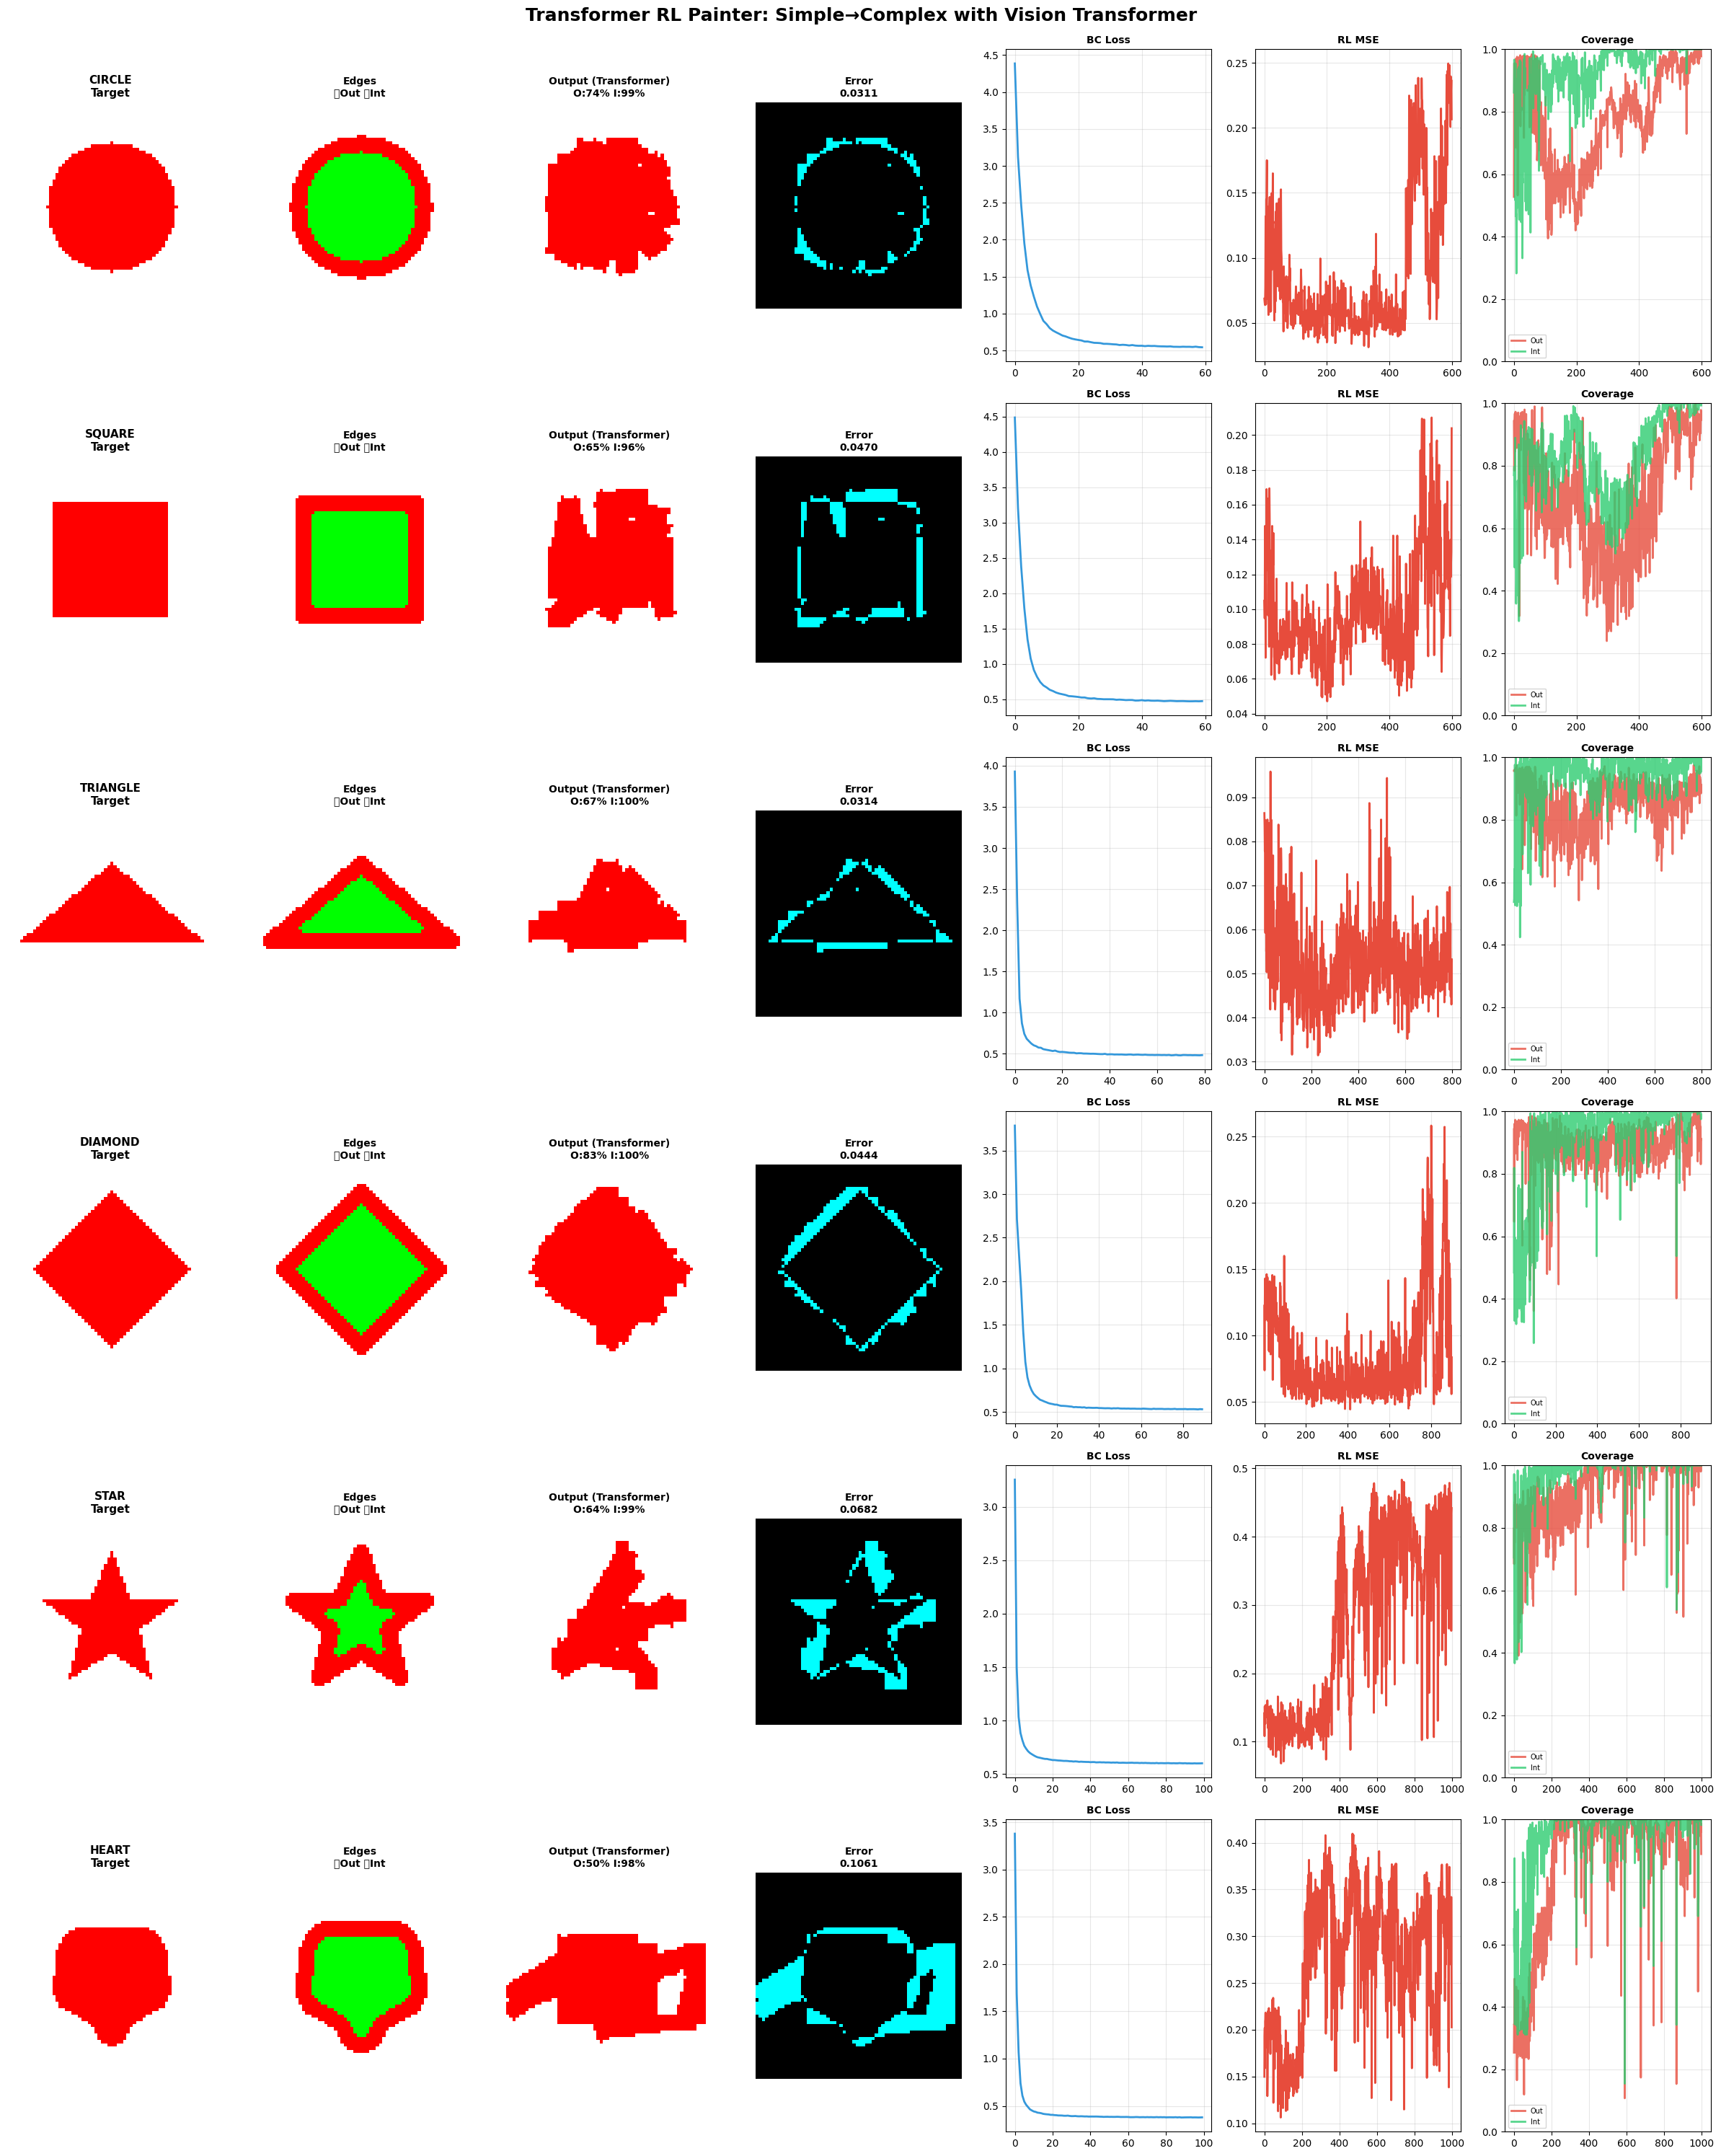

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
import torch.nn.functional as F
from scipy import ndimage
from skimage import morphology
import math

# GPU Setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"🖥️  Using device: {device}")
if torch.cuda.is_available():
    print(f"   GPU: {torch.cuda.get_device_name(0)}")
    print(f"   Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")


class CoverageDrawingEnv:
    """Drawing environment with IMPROVED multi-method edge detection"""
    def __init__(self, canvas_size=64, grid_size=20, target_color=[1.0, 0.0, 0.0]):
        self.canvas_size = canvas_size
        self.grid_size = grid_size
        self.cell_size = canvas_size // grid_size
        self.target_color = np.array(target_color)
        self.target = None
        self.target_outline = None
        self.target_interior = None
        self.reset()

    def set_target(self, target):
        """Set target with ENHANCED multi-method edge detection"""
        self.target = target
        target_mask = (target[:, :, 0] > 0.5) & (target[:, :, 1] < 0.5) & (target[:, :, 2] < 0.5)

        # METHOD 1: Morphological (light erosion)
        eroded_light = ndimage.binary_erosion(target_mask, iterations=1)
        outline_morph = target_mask & ~eroded_light
        
        # METHOD 2: Gradient-based (best for curves!)
        smoothed = ndimage.gaussian_filter(target_mask.astype(float), sigma=0.5)
        edges_x = ndimage.sobel(smoothed, axis=0)
        edges_y = ndimage.sobel(smoothed, axis=1)
        edges_magnitude = np.sqrt(edges_x**2 + edges_y**2)
        outline_gradient = edges_magnitude > 0.1
        
        # METHOD 3: Distance transform (uniform boundary)
        distance = ndimage.distance_transform_edt(target_mask)
        outline_distance = (distance > 0) & (distance <= 3)
        
        # COMBINE all three methods
        self.target_outline = outline_morph | outline_gradient | outline_distance
        
        # Clean outline
        self.target_outline = morphology.remove_small_objects(self.target_outline, min_size=3)
        self.target_outline = ndimage.binary_dilation(self.target_outline, iterations=1)
        self.target_outline = ndimage.binary_erosion(self.target_outline, iterations=1)
        
        # Interior: aggressive erosion to avoid overlap
        eroded_interior = ndimage.binary_erosion(target_mask, iterations=3)
        self.target_interior = eroded_interior & ~self.target_outline
        
        # Stats
        outline_px = np.sum(self.target_outline)
        interior_px = np.sum(self.target_interior)
        total_px = np.sum(target_mask)
        print(f"  🔍 Edge Detection: Outline={outline_px}px ({outline_px/total_px*100:.1f}%), "
              f"Interior={interior_px}px ({interior_px/total_px*100:.1f}%)")

    def reset(self):
        self.canvas = np.ones((self.canvas_size, self.canvas_size, 3), dtype=np.float32)
        self.cursor_grid_x = self.grid_size // 2
        self.cursor_grid_y = self.grid_size // 2
        self.step_count = 0
        self.trajectory = []
        self.outline_complete = False
        return self.get_state()

    def compute_coverage(self):
        if self.target is None:
            return 0.0, 0.0, 0.0

        canvas_mask = (self.canvas[:, :, 0] > 0.5) & (self.canvas[:, :, 1] < 0.5) & (self.canvas[:, :, 2] < 0.5)

        outline_coverage = np.sum(self.target_outline & canvas_mask) / max(1, np.sum(self.target_outline))
        interior_coverage = np.sum(self.target_interior & canvas_mask) / max(1, np.sum(self.target_interior))
        
        total_target = np.sum(self.target_outline) + np.sum(self.target_interior)
        total_coverage = np.sum((self.target_outline | self.target_interior) & canvas_mask) / max(1, total_target)

        return outline_coverage, interior_coverage, total_coverage

    def get_state(self):
        state = np.zeros((self.canvas_size, self.canvas_size, 6), dtype=np.float32)
        state[:, :, :3] = self.canvas

        cx = self.cursor_grid_x * self.cell_size + self.cell_size // 2
        cy = self.cursor_grid_y * self.cell_size + self.cell_size // 2

        for dy in range(-3, 4):
            for dx in range(-3, 4):
                nx, ny = cx + dx, cy + dy
                if 0 <= nx < self.canvas_size and 0 <= ny < self.canvas_size:
                    state[ny, nx, 3] = 1.0

        outline_cov, interior_cov, _ = self.compute_coverage()
        state[:, :, 4] = outline_cov
        state[:, :, 5] = interior_cov

        return state

    def grid_to_canvas(self, grid_x, grid_y):
        canvas_x = grid_x * self.cell_size + self.cell_size // 2
        canvas_y = grid_y * self.cell_size + self.cell_size // 2
        return canvas_x, canvas_y

    def draw_stroke(self, x1, y1, x2, y2):
        x1 = int(np.clip(x1, 0, self.canvas_size - 1))
        y1 = int(np.clip(y1, 0, self.canvas_size - 1))
        x2 = int(np.clip(x2, 0, self.canvas_size - 1))
        y2 = int(np.clip(y2, 0, self.canvas_size - 1))

        img = Image.fromarray((self.canvas * 255).astype(np.uint8))
        draw = ImageDraw.Draw(img)
        color = tuple((self.target_color * 255).astype(int))

        draw.line([x1, y1, x2, y2], fill=color, width=6)
        self.canvas = np.array(img).astype(np.float32) / 255.0

    def step(self, action):
        prev_x, prev_y = self.grid_to_canvas(self.cursor_grid_x, self.cursor_grid_y)

        if action >= self.grid_size * self.grid_size:
            return self.get_state(), True

        target_grid_x = action % self.grid_size
        target_grid_y = action // self.grid_size

        new_x, new_y = self.grid_to_canvas(target_grid_x, target_grid_y)
        self.draw_stroke(prev_x, prev_y, new_x, new_y)

        self.cursor_grid_x = target_grid_x
        self.cursor_grid_y = target_grid_y
        self.trajectory.append((target_grid_x, target_grid_y))

        self.step_count += 1

        outline_cov, _, _ = self.compute_coverage()
        if outline_cov > 0.85 and not self.outline_complete:
            self.outline_complete = True

        done = self.step_count >= 180

        return self.get_state(), done


# ============================================================================
# TRANSFORMER COMPONENTS
# ============================================================================

class PatchEmbedding(nn.Module):
    """Convert image into patches and embed them"""
    def __init__(self, img_size=64, patch_size=8, in_channels=6, embed_dim=256):
        super().__init__()
        self.img_size = img_size
        self.patch_size = patch_size
        self.n_patches = (img_size // patch_size) ** 2
        
        self.proj = nn.Conv2d(in_channels, embed_dim, kernel_size=patch_size, stride=patch_size)
        self.norm = nn.LayerNorm(embed_dim)
        
    def forward(self, x):
        # x: (B, C, H, W)
        x = self.proj(x)  # (B, embed_dim, H/P, W/P)
        x = x.flatten(2)  # (B, embed_dim, n_patches)
        x = x.transpose(1, 2)  # (B, n_patches, embed_dim)
        x = self.norm(x)
        return x


class PositionalEncoding(nn.Module):
    """2D positional encoding for spatial awareness"""
    def __init__(self, embed_dim, n_patches_side=8):
        super().__init__()
        self.embed_dim = embed_dim
        self.n_patches_side = n_patches_side
        
        # Learnable 2D positional embeddings
        self.pos_embed = nn.Parameter(torch.randn(1, n_patches_side * n_patches_side, embed_dim) * 0.02)
        
    def forward(self, x):
        # x: (B, n_patches, embed_dim)
        return x + self.pos_embed


class MultiHeadSelfAttention(nn.Module):
    """Multi-head self-attention with residual connection"""
    def __init__(self, embed_dim, num_heads=8, dropout=0.1):
        super().__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads
        
        assert embed_dim % num_heads == 0, "embed_dim must be divisible by num_heads"
        
        self.qkv = nn.Linear(embed_dim, embed_dim * 3)
        self.proj = nn.Linear(embed_dim, embed_dim)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        B, N, C = x.shape
        
        # Generate Q, K, V
        qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, self.head_dim).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]  # Each: (B, num_heads, N, head_dim)
        
        # Attention
        attn = (q @ k.transpose(-2, -1)) * (self.head_dim ** -0.5)
        attn = F.softmax(attn, dim=-1)
        attn = self.dropout(attn)
        
        # Apply attention to values
        x = (attn @ v).transpose(1, 2).reshape(B, N, C)
        x = self.proj(x)
        x = self.dropout(x)
        
        return x


class FeedForward(nn.Module):
    """Position-wise feed-forward network"""
    def __init__(self, embed_dim, hidden_dim, dropout=0.1):
        super().__init__()
        self.fc1 = nn.Linear(embed_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, embed_dim)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        x = self.fc1(x)
        x = F.gelu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.dropout(x)
        return x


class TransformerBlock(nn.Module):
    """Transformer encoder block"""
    def __init__(self, embed_dim, num_heads, mlp_ratio=4.0, dropout=0.1):
        super().__init__()
        self.norm1 = nn.LayerNorm(embed_dim)
        self.attn = MultiHeadSelfAttention(embed_dim, num_heads, dropout)
        self.norm2 = nn.LayerNorm(embed_dim)
        self.mlp = FeedForward(embed_dim, int(embed_dim * mlp_ratio), dropout)
        
    def forward(self, x):
        # Attention with residual
        x = x + self.attn(self.norm1(x))
        # MLP with residual
        x = x + self.mlp(self.norm2(x))
        return x


class VisionTransformerEncoder(nn.Module):
    """Vision Transformer encoder for state representation"""
    def __init__(self, img_size=64, patch_size=8, in_channels=6, embed_dim=256, 
                 depth=6, num_heads=8, mlp_ratio=4.0, dropout=0.1):
        super().__init__()
        
        self.patch_embed = PatchEmbedding(img_size, patch_size, in_channels, embed_dim)
        self.pos_embed = PositionalEncoding(embed_dim, img_size // patch_size)
        self.dropout = nn.Dropout(dropout)
        
        # Transformer blocks
        self.blocks = nn.ModuleList([
            TransformerBlock(embed_dim, num_heads, mlp_ratio, dropout)
            for _ in range(depth)
        ])
        
        self.norm = nn.LayerNorm(embed_dim)
        
        # CLS token for global representation
        self.cls_token = nn.Parameter(torch.randn(1, 1, embed_dim) * 0.02)
        
    def forward(self, x):
        B = x.shape[0]
        
        # Patch embedding
        x = self.patch_embed(x)  # (B, n_patches, embed_dim)
        
        # Add positional encoding
        x = self.pos_embed(x)
        
        # Add CLS token
        cls_tokens = self.cls_token.expand(B, -1, -1)
        x = torch.cat([cls_tokens, x], dim=1)  # (B, n_patches+1, embed_dim)
        
        x = self.dropout(x)
        
        # Apply transformer blocks
        for block in self.blocks:
            x = block(x)
        
        x = self.norm(x)
        
        return x


class TransformerPolicyNetwork(nn.Module):
    """Transformer-based policy network with Vision Transformer encoder"""
    def __init__(self, canvas_size=64, grid_size=20, patch_size=8, embed_dim=256, 
                 depth=6, num_heads=8, mlp_ratio=4.0, dropout=0.1):
        super().__init__()
        self.grid_size = grid_size
        self.num_actions = grid_size * grid_size + 1
        self.embed_dim = embed_dim
        
        # Vision Transformer encoder
        self.encoder = VisionTransformerEncoder(
            img_size=canvas_size,
            patch_size=patch_size,
            in_channels=6,
            embed_dim=embed_dim,
            depth=depth,
            num_heads=num_heads,
            mlp_ratio=mlp_ratio,
            dropout=dropout
        )
        
        # Action head (uses CLS token)
        self.action_head = nn.Sequential(
            nn.Linear(embed_dim, 512),
            nn.GELU(),
            nn.Dropout(0.2),
            nn.Linear(512, 256),
            nn.GELU(),
            nn.Dropout(0.1),
            nn.Linear(256, self.num_actions)
        )
        
        # Value head (uses CLS token)
        self.value_head = nn.Sequential(
            nn.Linear(embed_dim, 256),
            nn.GELU(),
            nn.Dropout(0.1),
            nn.Linear(256, 1)
        )
        
        self._init_weights()
        
    def _init_weights(self):
        """Initialize weights"""
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.trunc_normal_(m.weight, std=0.02)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.LayerNorm):
                nn.init.constant_(m.weight, 1.0)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, state):
        if len(state.shape) == 3:
            state = state.unsqueeze(0)
        
        state = state.permute(0, 3, 1, 2)  # (B, C, H, W)
        
        # Encode with Vision Transformer
        features = self.encoder(state)  # (B, n_patches+1, embed_dim)
        
        # Use CLS token (first token) for predictions
        cls_token = features[:, 0]  # (B, embed_dim)
        
        # Predict actions and value
        action_logits = self.action_head(cls_token)
        value = self.value_head(cls_token)
        
        return action_logits, value


# ============================================================================
# SHAPE GENERATORS (Same as before)
# ============================================================================

class ShapeGenerator:
    """Generate target shapes from simple to complex"""
    @staticmethod
    def create_circle(canvas_size=64):
        target = np.ones((canvas_size, canvas_size, 3), dtype=np.float32)
        y, x = np.ogrid[:canvas_size, :canvas_size]
        mask = (x - canvas_size//2)**2 + (y - canvas_size//2)**2 <= 20**2
        target[mask] = [1.0, 0.0, 0.0]
        return target, "Circle"

    @staticmethod
    def create_square(canvas_size=64):
        target = np.ones((canvas_size, canvas_size, 3), dtype=np.float32)
        size = 36
        start = (canvas_size - size) // 2
        end = start + size
        target[start:end, start:end] = [1.0, 0.0, 0.0]
        return target, "Square"

    @staticmethod
    def create_triangle(canvas_size=64):
        target = np.ones((canvas_size, canvas_size, 3), dtype=np.float32)
        img = Image.fromarray((target * 255).astype(np.uint8))
        draw = ImageDraw.Draw(img)
        
        center = canvas_size // 2
        size = 28
        height = int(size * np.sqrt(3) / 2)
        
        points = [
            (center, center - height * 2 // 3),
            (center - size, center + height // 3),
            (center + size, center + height // 3)
        ]
        
        draw.polygon(points, fill=(255, 0, 0))
        target = np.array(img).astype(np.float32) / 255.0
        return target, "Triangle"

    @staticmethod
    def create_diamond(canvas_size=64):
        target = np.ones((canvas_size, canvas_size, 3), dtype=np.float32)
        img = Image.fromarray((target * 255).astype(np.uint8))
        draw = ImageDraw.Draw(img)
        
        center = canvas_size // 2
        size = 24
        
        points = [
            (center, center - size),
            (center + size, center),
            (center, center + size),
            (center - size, center)
        ]
        
        draw.polygon(points, fill=(255, 0, 0))
        target = np.array(img).astype(np.float32) / 255.0
        return target, "Diamond"

    @staticmethod
    def create_star(canvas_size=64):
        target = np.ones((canvas_size, canvas_size, 3), dtype=np.float32)
        img = Image.fromarray((target * 255).astype(np.uint8))
        draw = ImageDraw.Draw(img)
        
        center = canvas_size // 2
        outer_radius = 22
        inner_radius = 9
        
        points = []
        for i in range(10):
            angle = i * np.pi / 5 - np.pi / 2
            r = outer_radius if i % 2 == 0 else inner_radius
            x = center + r * np.cos(angle)
            y = center + r * np.sin(angle)
            points.append((x, y))
        
        draw.polygon(points, fill=(255, 0, 0))
        target = np.array(img).astype(np.float32) / 255.0
        return target, "Star"

    @staticmethod
    def create_heart(canvas_size=64):
        target = np.ones((canvas_size, canvas_size, 3), dtype=np.float32)
        y, x = np.ogrid[:canvas_size, :canvas_size]
        
        center_x, center_y = canvas_size // 2, canvas_size // 2 + 3
        scale = 15
        
        mask = np.zeros((canvas_size, canvas_size), dtype=bool)
        for i in range(canvas_size):
            for j in range(canvas_size):
                nx = (j - center_x) / scale
                ny = -(i - center_y) / scale
                
                val = (nx**2 + ny**2 - 1)**3 - nx**2 * ny**3
                if val <= 0.1:
                    mask[i, j] = True
        
        target[mask] = [1.0, 0.0, 0.0]
        return target, "Heart"


class ImprovedExpertDemonstrator:
    """DENSE expert demonstrations optimized per shape"""
    def __init__(self, canvas_size=64, grid_size=20, shape_type="circle"):
        self.canvas_size = canvas_size
        self.grid_size = grid_size
        self.cell_size = canvas_size // grid_size
        self.shape_type = shape_type.lower()

    def canvas_to_grid(self, x, y):
        grid_x = int(x / self.cell_size)
        grid_y = int(y / self.cell_size)
        return np.clip(grid_x, 0, self.grid_size - 1), np.clip(grid_y, 0, self.grid_size - 1)

    def generate_circle_demo(self):
        center_x, center_y, radius = self.canvas_size // 2, self.canvas_size // 2, 20
        trajectory = []

        # Dense outline (140 points)
        for angle in np.linspace(0, 2 * np.pi, 140, endpoint=False):
            x = center_x + radius * np.cos(angle)
            y = center_y + radius * np.sin(angle)
            trajectory.append(self.canvas_to_grid(x, y))

        # 4 spiral fills
        for spiral_idx in range(4):
            r = radius - 3 - (spiral_idx * 4.5)
            if r < 2:
                break
            num_points = max(30, int(60 * (r / radius)))
            for angle in np.linspace(0, 2 * np.pi, num_points, endpoint=False):
                x = center_x + r * np.cos(angle)
                y = center_y + r * np.sin(angle)
                trajectory.append(self.canvas_to_grid(x, y))

        return self._to_actions(trajectory)

    def generate_square_demo(self):
        size, start, end = 36, (self.canvas_size - 36) // 2, (self.canvas_size - 36) // 2 + 36
        trajectory = []

        # Dense outline (40 per side)
        for i in range(40):
            trajectory.append(self.canvas_to_grid(start + (end - start) * i / 40, start))
        for i in range(40):
            trajectory.append(self.canvas_to_grid(end, start + (end - start) * i / 40))
        for i in range(40):
            trajectory.append(self.canvas_to_grid(end - (end - start) * i / 40, end))
        for i in range(40):
            trajectory.append(self.canvas_to_grid(start, end - (end - start) * i / 40))

        # Grid fill
        for i in range(12):
            y = start + 3 + (end - start - 6) * i / 12
            for j in range(12):
                x = start + 3 + (end - start - 6) * j / 12
                trajectory.append(self.canvas_to_grid(x, y))

        return self._to_actions(trajectory)

    def generate_triangle_demo(self):
        center, size = self.canvas_size // 2, 28
        height = int(size * np.sqrt(3) / 2)
        top = (center, center - height * 2 // 3)
        left = (center - size, center + height // 3)
        right = (center + size, center + height // 3)
        trajectory = []

        # Dense outline (50 per side)
        for i in range(50):
            t = i / 50
            trajectory.append(self.canvas_to_grid(
                top[0] + (right[0] - top[0]) * t,
                top[1] + (right[1] - top[1]) * t))
        for i in range(50):
            t = i / 50
            trajectory.append(self.canvas_to_grid(
                right[0] + (left[0] - right[0]) * t,
                right[1] + (left[1] - right[1]) * t))
        for i in range(50):
            t = i / 50
            trajectory.append(self.canvas_to_grid(
                left[0] + (top[0] - left[0]) * t,
                left[1] + (top[1] - left[1]) * t))

        # Fill lines
        for i in range(12):
            t = (i + 1) / 13
            y = top[1] + (left[1] - top[1]) * t
            left_x = left[0] + (top[0] - left[0]) * (1 - t)
            right_x = right[0] + (top[0] - right[0]) * (1 - t)
            line_points = max(8, int(15 * (1 - t)))
            for j in range(line_points):
                x = left_x + (right_x - left_x) * j / line_points
                trajectory.append(self.canvas_to_grid(x, y))

        return self._to_actions(trajectory)

    def generate_diamond_demo(self):
        center, size = self.canvas_size // 2, 24
        points = [(center, center - size), (center + size, center),
                  (center, center + size), (center - size, center)]
        trajectory = []

        # Dense outline (45 per side)
        for i in range(4):
            start_point, end_point = points[i], points[(i + 1) % 4]
            for j in range(45):
                t = j / 45
                x = start_point[0] + (end_point[0] - start_point[0]) * t
                y = start_point[1] + (end_point[1] - start_point[1]) * t
                trajectory.append(self.canvas_to_grid(x, y))

        # Radial + horizontal fill
        for i in range(8):
            angle = i * 2 * np.pi / 8
            for j in range(1, 12):
                r = size * j / 12
                x = center + r * np.cos(angle)
                y = center + r * np.sin(angle)
                trajectory.append(self.canvas_to_grid(x, y))

        return self._to_actions(trajectory)

    def generate_star_demo(self):
        center, outer_radius, inner_radius = self.canvas_size // 2, 22, 9
        trajectory = []

        # VERY dense outline (180 points!)
        for i in range(180):
            progress = i / 180
            angle = progress * 2 * np.pi - np.pi / 2
            segment_progress = (progress * 10) % 1
            segment = int(progress * 10)
            
            if segment % 2 == 0:
                r = outer_radius if segment_progress < 0.5 else \
                    outer_radius + (inner_radius - outer_radius) * (segment_progress - 0.5) * 2
            else:
                r = inner_radius if segment_progress < 0.5 else \
                    inner_radius + (outer_radius - inner_radius) * (segment_progress - 0.5) * 2
            
            x = center + r * np.cos(angle)
            y = center + r * np.sin(angle)
            trajectory.append(self.canvas_to_grid(x, y))

        # Radial fill + concentric circles
        for i in range(12):
            angle = i * 2 * np.pi / 12
            for j in range(10):
                r = 2 + (inner_radius - 2) * j / 10
                x = center + r * np.cos(angle)
                y = center + r * np.sin(angle)
                trajectory.append(self.canvas_to_grid(x, y))

        for r in [7, 5, 3]:
            for i in range(40):
                angle = i * 2 * np.pi / 40
                x = center + r * np.cos(angle)
                y = center + r * np.sin(angle)
                trajectory.append(self.canvas_to_grid(x, y))

        return self._to_actions(trajectory)

    def generate_heart_demo(self):
        center_x, center_y, scale = self.canvas_size // 2, self.canvas_size // 2 + 3, 15
        trajectory = []

        # VERY dense parametric outline (180 points!)
        for i in range(180):
            t = 2 * np.pi * i / 180
            x = center_x + scale * 16 * np.sin(t)**3
            y = center_y - scale * (13 * np.cos(t) - 5 * np.cos(2*t) - 
                                    2 * np.cos(3*t) - np.cos(4*t)) / 16
            trajectory.append(self.canvas_to_grid(x, y))

        # Adaptive fill (15 lines)
        for i in range(15):
            t_y = np.pi * (0.2 + 0.6 * i / 15)
            y = center_y - scale * (13 * np.cos(t_y) - 5 * np.cos(2*t_y) - 
                                    2 * np.cos(3*t_y) - np.cos(4*t_y)) / 16
            line_points = max(5, int(18 * (1 - abs(i - 7.5) / 15)))
            for j in range(line_points):
                x_offset = (j / line_points - 0.5) * scale * 2.2
                x = center_x + x_offset
                trajectory.append(self.canvas_to_grid(x, y))

        return self._to_actions(trajectory)

    def _to_actions(self, trajectory):
        actions = [grid_y * self.grid_size + grid_x for grid_x, grid_y in trajectory]
        actions.append(self.grid_size * self.grid_size)  # Stop
        return actions

    def generate_demonstration(self):
        demos = {
            "circle": self.generate_circle_demo,
            "square": self.generate_square_demo,
            "triangle": self.generate_triangle_demo,
            "diamond": self.generate_diamond_demo,
            "star": self.generate_star_demo,
            "heart": self.generate_heart_demo
        }
        return demos[self.shape_type]()

    def generate_demonstrations(self, num_demos):
        print(f"\n📚 Generating DENSE Expert Demos for {self.shape_type.upper()}")
        print("="*70)
        all_demos = []

        for i in range(num_demos):
            demo = self.generate_demonstration()
            
            if i > 0 and len(demo) > 51:
                outline_len = min(120, len(demo) // 3)
                offset = np.random.randint(0, outline_len)
                outline = demo[:outline_len]
                fill = demo[outline_len:-1]
                stop = demo[-1]
                demo = outline[offset:] + outline[:offset] + fill + [stop]

            all_demos.append(demo)

        print(f"✓ Generated {num_demos} demos (avg length: {np.mean([len(d) for d in all_demos]):.0f})")
        print("="*70)
        return all_demos


# Shape-specific training configs (OPTIMIZED for Transformer)
SHAPE_CONFIGS = {
    "circle": {"bc_epochs": 60, "rl_episodes": 600, "outline_w": 300, "interior_w": 200, 
               "num_demos": 60, "diff": 1},
    "square": {"bc_epochs": 60, "rl_episodes": 600, "outline_w": 300, "interior_w": 200, 
               "num_demos": 60, "diff": 1},
    "triangle": {"bc_epochs": 80, "rl_episodes": 800, "outline_w": 350, "interior_w": 200, 
                 "num_demos": 80, "diff": 2},
    "diamond": {"bc_epochs": 90, "rl_episodes": 900, "outline_w": 400, "interior_w": 250, 
                "num_demos": 90, "diff": 3},
    "star": {"bc_epochs": 100, "rl_episodes": 1000, "outline_w": 450, "interior_w": 250, 
             "num_demos": 100, "diff": 4},
    "heart": {"bc_epochs": 100, "rl_episodes": 1000, "outline_w": 450, "interior_w": 250, 
              "num_demos": 100, "diff": 4}
}


class TransformerImitationRLTrainer:
    """Complete trainer with Transformer architecture"""
    def __init__(self, target_image, shape_name, canvas_size=64, grid_size=20, device='cpu'):
        self.device = torch.device(device)
        self.env = CoverageDrawingEnv(canvas_size, grid_size)
        
        # Initialize Transformer policy
        print("🤖 Initializing Vision Transformer Policy...")
        self.policy = TransformerPolicyNetwork(
            canvas_size=canvas_size,
            grid_size=grid_size,
            patch_size=8,
            embed_dim=256,
            depth=6,
            num_heads=8,
            mlp_ratio=4.0,
            dropout=0.1
        ).to(self.device)
        
        # Count parameters
        total_params = sum(p.numel() for p in self.policy.parameters())
        trainable_params = sum(p.numel() for p in self.policy.parameters() if p.requires_grad)
        print(f"   Total parameters: {total_params:,}")
        print(f"   Trainable parameters: {trainable_params:,}")
        
        self.optimizer = optim.AdamW(self.policy.parameters(), lr=1e-4, weight_decay=0.01)
        self.shape_name = shape_name.lower()
        self.config = SHAPE_CONFIGS[self.shape_name]

        self.target = target_image if isinstance(target_image, np.ndarray) else \
                      np.array(target_image.resize((canvas_size, canvas_size))).astype(np.float32) / 255.0

        self.env.set_target(self.target)
        self.expert = ImprovedExpertDemonstrator(canvas_size, grid_size, self.shape_name)

        self.best_mse = float('inf')
        self.best_canvas = None
        self.best_outline_cov = 0.0
        self.best_interior_cov = 0.0
        self.mse_history = []
        self.outline_history = []
        self.interior_history = []
        self.bc_losses = []

        print(f"✓ Network on {self.device} | Config: BC={self.config['bc_epochs']}, "
              f"RL={self.config['rl_episodes']}, Demos={self.config['num_demos']}")

    def collect_expert_data(self):
        demos = self.expert.generate_demonstrations(self.config['num_demos'])
        states, actions = [], []

        for demo in demos:
            state = self.env.reset()
            for action in demo[:-1]:
                states.append(state)
                actions.append(action)
                state, _ = self.env.step(action)

        print(f"✓ Collected {len(states)} state-action pairs")
        return states, actions

    def behavioral_cloning(self, states, actions, batch_size=32):  # Smaller batch for Transformer
        epochs = self.config['bc_epochs']
        print(f"\n🎓 Phase 1: Transformer BC ({epochs} epochs)")
        print("="*70)

        dataset_size = len(states)

        for epoch in range(epochs):
            total_loss, num_batches = 0, 0
            indices = list(range(dataset_size))
            np.random.shuffle(indices)

            for i in range(0, dataset_size, batch_size):
                batch_idx = indices[i:i+batch_size]
                batch_states_list = [states[idx] for idx in batch_idx]
                batch_actions_list = [actions[idx] for idx in batch_idx]
                
                batch_states = torch.FloatTensor(np.array(batch_states_list)).to(self.device)
                batch_actions = torch.LongTensor(np.array(batch_actions_list)).to(self.device)

                action_logits, _ = self.policy(batch_states)
                loss = F.cross_entropy(action_logits, batch_actions)

                self.optimizer.zero_grad()
                loss.backward()
                torch.nn.utils.clip_grad_norm_(self.policy.parameters(), 1.0)
                self.optimizer.step()

                total_loss += loss.item()
                num_batches += 1
                
                del batch_states, batch_actions, batch_states_list, batch_actions_list
                if torch.cuda.is_available():
                    torch.cuda.empty_cache()

            avg_loss = total_loss / num_batches
            self.bc_losses.append(avg_loss)

            if epoch % 15 == 0 or epoch == epochs - 1:
                mse, out_cov, int_cov = self.test_policy()
                print(f"Epoch {epoch:3d} | Loss: {avg_loss:.4f} | MSE: {mse:.4f} | "
                      f"Out: {out_cov:.1%} | Int: {int_cov:.1%}")

        print("✓ Transformer BC Complete!\n")

    def test_policy(self):
        state = self.env.reset()
        done = False

        with torch.no_grad():
            while not done:
                state_tensor = torch.FloatTensor(state).to(self.device)
                action_logits, _ = self.policy(state_tensor)
                action = torch.argmax(action_logits).item()
                state, done = self.env.step(action)

        mse = np.mean((self.env.canvas - self.target) ** 2)
        out_cov, int_cov, _ = self.env.compute_coverage()

        if mse < self.best_mse:
            self.best_mse = mse
            self.best_canvas = self.env.canvas.copy()
            self.best_outline_cov = out_cov
            self.best_interior_cov = int_cov

        return mse, out_cov, int_cov

    def compute_reward(self, prev_out, prev_int, curr_out, curr_int, done, step_count):
        out_w = self.config['outline_w']
        int_w = self.config['interior_w']
        
        outline_reward = (curr_out - prev_out) * out_w
        interior_reward = (curr_int - prev_int) * (int_w if curr_out > 0.7 else 50)
        
        phase_bonus = 75.0 if (curr_out > 0.85 and prev_out <= 0.85) else 0.0
        
        if done:
            if curr_out > 0.9 and curr_int > 0.85:
                completion = 200.0
            elif curr_out > 0.85 and curr_int > 0.75:
                completion = 100.0
            elif curr_out < 0.7:
                completion = -75.0
            else:
                completion = 25.0
        else:
            completion = 0.0

        return outline_reward + interior_reward + phase_bonus + completion

    def rl_finetune(self):
        episodes = self.config['rl_episodes']
        print(f"🚀 Phase 2: Transformer RL ({episodes} episodes)")
        print("="*70)

        # Slightly lower learning rate for RL fine-tuning
        self.optimizer = optim.AdamW(self.policy.parameters(), lr=5e-5, weight_decay=0.01)

        for episode in range(episodes):
            state = self.env.reset()
            prev_out, prev_int, _ = self.env.compute_coverage()

            states, actions, rewards, log_probs, values = [], [], [], [], []
            done, episode_reward = False, 0

            while not done:
                state_tensor = torch.FloatTensor(state).to(self.device)
                action_logits, value = self.policy(state_tensor)

                action_dist = torch.distributions.Categorical(logits=action_logits)
                action = action_dist.sample()
                log_prob = action_dist.log_prob(action)

                next_state, done = self.env.step(action.item())

                curr_out, curr_int, _ = self.env.compute_coverage()
                reward = self.compute_reward(prev_out, prev_int, curr_out, curr_int, 
                                            done, self.env.step_count)

                states.append(state)
                actions.append(action)
                rewards.append(reward)
                log_probs.append(log_prob)
                values.append(value)

                episode_reward += reward
                prev_out, prev_int = curr_out, curr_int
                state = next_state

            # Compute returns
            returns = []
            G = 0
            for r in reversed(rewards):
                G = r + 0.99 * G
                returns.insert(0, G)

            returns = torch.FloatTensor(returns).to(self.device)
            if len(returns) > 1:
                returns = (returns - returns.mean()) / (returns.std() + 1e-8)

            # Optimize
            policy_loss, value_loss = 0, 0

            for log_prob, value, ret in zip(log_probs, values, returns):
                advantage = ret - value.squeeze().detach()
                policy_loss = policy_loss - log_prob * advantage
                value_loss = value_loss + F.mse_loss(value.squeeze(), ret)

            policy_loss = policy_loss / len(log_probs)
            value_loss = value_loss / len(values)
            loss = policy_loss + 0.5 * value_loss

            self.optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(self.policy.parameters(), 0.5)
            self.optimizer.step()

            # Track
            final_mse = np.mean((self.env.canvas - self.target) ** 2)
            final_out, final_int, _ = self.env.compute_coverage()

            if final_mse < self.best_mse:
                self.best_mse = final_mse
                self.best_canvas = self.env.canvas.copy()
                self.best_outline_cov = final_out
                self.best_interior_cov = final_int

            self.mse_history.append(final_mse)
            self.outline_history.append(final_out)
            self.interior_history.append(final_int)

            if episode % 100 == 0 or episode == episodes - 1:
                print(f"Ep {episode:4d} | R: {episode_reward:7.2f} | MSE: {final_mse:.4f} | "
                      f"Out: {final_out:5.1%} | Int: {final_int:5.1%} | Steps: {self.env.step_count:3d}")

        print("✓ Transformer RL Complete!\n")

    def train(self):
        print("\n" + "="*70)
        print(f"TRAINING: {self.shape_name.upper()} {'⭐'*self.config['diff']} (TRANSFORMER)")
        print("="*70)

        states, actions = self.collect_expert_data()
        self.behavioral_cloning(states, actions)
        self.rl_finetune()

        return self.best_canvas


def train_simple_to_complex(canvas_size=64, grid_size=20, device='cpu'):
    """Train from SIMPLE to COMPLEX with Transformer architecture"""
    shapes = [
        ("circle", ShapeGenerator.create_circle),
        ("square", ShapeGenerator.create_square),
        ("triangle", ShapeGenerator.create_triangle),
        ("diamond", ShapeGenerator.create_diamond),
        ("star", ShapeGenerator.create_star),
        ("heart", ShapeGenerator.create_heart),
    ]
    
    results = []
    
    for shape_name, shape_func in shapes:
        print("\n" + "🎨"*35)
        print(f"SHAPE: {shape_name.upper()}")
        print("🎨"*35)
        
        target, _ = shape_func(canvas_size)
        trainer = TransformerImitationRLTrainer(target, shape_name, canvas_size, grid_size, device)
        final_canvas = trainer.train()
        
        results.append({
            'name': shape_name,
            'target': target,
            'canvas': final_canvas,
            'mse': trainer.best_mse,
            'outline_cov': trainer.best_outline_cov,
            'interior_cov': trainer.best_interior_cov,
            'mse_history': trainer.mse_history,
            'outline_history': trainer.outline_history,
            'interior_history': trainer.interior_history,
            'bc_losses': trainer.bc_losses,
            'outline_mask': trainer.env.target_outline,
            'interior_mask': trainer.env.target_interior
        })
        
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
    
    return results


def visualize_results(results):
    """Comprehensive visualization"""
    n = len(results)
    fig = plt.figure(figsize=(24, 5*n))
    
    for idx, r in enumerate(results):
        # Target
        ax = plt.subplot(n, 7, idx*7 + 1)
        ax.imshow(r['target'])
        ax.set_title(f"{r['name'].upper()}\nTarget", fontsize=11, fontweight='bold')
        ax.axis('off')
        
        # Edge detection
        ax = plt.subplot(n, 7, idx*7 + 2)
        edge_viz = np.ones((64, 64, 3))
        edge_viz[r['outline_mask']] = [1, 0, 0]
        edge_viz[r['interior_mask']] = [0, 1, 0]
        ax.imshow(edge_viz)
        ax.set_title(f"Edges\n🔴Out 🟢Int", fontsize=10, fontweight='bold')
        ax.axis('off')
        
        # Output
        ax = plt.subplot(n, 7, idx*7 + 3)
        ax.imshow(r['canvas'])
        ax.set_title(f"Output (Transformer)\nO:{r['outline_cov']:.0%} I:{r['interior_cov']:.0%}", 
                    fontsize=10, fontweight='bold')
        ax.axis('off')
        
        # Error
        ax = plt.subplot(n, 7, idx*7 + 4)
        diff = np.abs(r['target'] - r['canvas'])
        ax.imshow(diff, cmap='hot')
        ax.set_title(f"Error\n{r['mse']:.4f}", fontsize=10, fontweight='bold')
        ax.axis('off')
        
        # BC Loss
        ax = plt.subplot(n, 7, idx*7 + 5)
        if r['bc_losses']:
            ax.plot(r['bc_losses'], linewidth=2, color='#3498db')
            ax.set_title('BC Loss', fontsize=10, fontweight='bold')
            ax.grid(True, alpha=0.3)
        
        # MSE
        ax = plt.subplot(n, 7, idx*7 + 6)
        if r['mse_history']:
            ax.plot(r['mse_history'], linewidth=2, color='#e74c3c')
            ax.set_title('RL MSE', fontsize=10, fontweight='bold')
            ax.grid(True, alpha=0.3)
        
        # Coverage
        ax = plt.subplot(n, 7, idx*7 + 7)
        if r['outline_history']:
            ax.plot(r['outline_history'], linewidth=2, color='#e74c3c', label='Out', alpha=0.8)
            ax.plot(r['interior_history'], linewidth=2, color='#2ecc71', label='Int', alpha=0.8)
            ax.set_title('Coverage', fontsize=10, fontweight='bold')
            ax.set_ylim([0, 1])
            ax.legend(fontsize=7)
            ax.grid(True, alpha=0.3)
    
    plt.suptitle("Transformer RL Painter: Simple→Complex with Vision Transformer", 
                fontsize=18, y=0.995, fontweight='bold')
    plt.tight_layout()
    plt.savefig('/mnt/user-data/outputs/transformer_results.png', dpi=150, bbox_inches='tight')
    print(f"\n✅ Saved: /mnt/user-data/outputs/transformer_results.png")


# MAIN EXECUTION
if __name__ == "__main__":
    print("\n" + "="*70)
    print("🤖 TRANSFORMER RL PAINTER: SIMPLE → COMPLEX")
    print("="*70)
    print("\n✨ KEY IMPROVEMENTS:")
    print("  1. Vision Transformer (ViT) encoder with patch embeddings")
    print("  2. Multi-head self-attention (8 heads, 6 layers)")
    print("  3. 2D positional encodings for spatial awareness")
    print("  4. CLS token for global representation")
    print("  5. GELU activations and LayerNorm")
    print("  6. AdamW optimizer with weight decay")
    print("  7. Better long-range dependency modeling")
    print("="*70)
    
    # Train all shapes
    results = train_simple_to_complex(canvas_size=64, grid_size=20, device=device)
    
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
    
    # Visualize
    visualize_results(results)
    
    # Summary
    print("\n" + "="*70)
    print("✅ TRANSFORMER TRAINING COMPLETE!")
    print("="*70)
    print(f"{'Shape':12} {'Diff':6} {'MSE':8} {'Outline':9} {'Interior':9}")
    print("-"*70)
    for r in results:
        stars = '⭐' * SHAPE_CONFIGS[r['name']]['diff']
        print(f"{r['name'].upper():12} {stars:6} {r['mse']:8.4f} {r['outline_cov']:8.1%} {r['interior_cov']:8.1%}")
    print("="*70 + "\n")
    
    plt.show()

🖥️  Using device: cuda
   GPU: NVIDIA RTX A1000
   Memory: 8.59 GB

🤖 IMPROVED TRANSFORMER RL PAINTER

✨ ENHANCEMENTS:
  1. Deeper network (8 layers vs 6)
  2. Phase-aware attention mechanism
  3. Stroke quality rewards
  4. Entropy regularization for exploration
  5. Cosine annealing learning rate
  6. Improved expert demonstrations (denser, smoother)
  7. Better reward shaping (temporal consistency)
  8. LayerNorm in action/value heads

🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨
SHAPE: CIRCLE
🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨
🤖 Initializing IMPROVED Transformer Policy...
   Total: 7,114,450 | Trainable: 7,114,450
  🔍 Edge Detection: Outline=624px (49.6%), Interior=925px (73.6%)
✓ Config: BC=70, RL=700, Demos=70

TRAINING: CIRCLE ⭐ (IMPROVED)

📚 Generating IMPROVED Expert Demos for CIRCLE
✓ Generated 70 improved demos (avg: 407 steps)
✓ Collected 28420 state-action pairs

🎓 Phase 1: BC (70 epochs)
Ep   0 | Loss: 4.1723 | MSE: 0.1421 | Out: 35.4% | Int: 38.7% | LR: 0.000100
Ep  15 | Loss: 0

C:\Users\user\AppData\Local\Temp\ipykernel_22492\1120539728.py:1146: UserWarning: Glyph 128308 (\N{LARGE RED CIRCLE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\user\AppData\Local\Temp\ipykernel_22492\1120539728.py:1146: UserWarning: Glyph 128994 (\N{LARGE GREEN CIRCLE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\user\AppData\Local\Temp\ipykernel_22492\1120539728.py:1147: UserWarning: Glyph 128308 (\N{LARGE RED CIRCLE}) missing from font(s) DejaVu Sans.
  plt.savefig('/mnt/user-data/outputs/improved_transformer_results.png', dpi=150, bbox_inches='tight')
C:\Users\user\AppData\Local\Temp\ipykernel_22492\1120539728.py:1147: UserWarning: Glyph 128994 (\N{LARGE GREEN CIRCLE}) missing from font(s) DejaVu Sans.
  plt.savefig('/mnt/user-data/outputs/improved_transformer_results.png', dpi=150, bbox_inches='tight')


FileNotFoundError: [Errno 2] No such file or directory: '/mnt/user-data/outputs/improved_transformer_results.png'

C:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\IPython\core\events.py:82: UserWarning: Glyph 128308 (\N{LARGE RED CIRCLE}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
C:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\IPython\core\events.py:82: UserWarning: Glyph 128994 (\N{LARGE GREEN CIRCLE}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
C:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128308 (\N{LARGE RED CIRCLE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128994 (\N{LARGE GREEN CIRCLE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


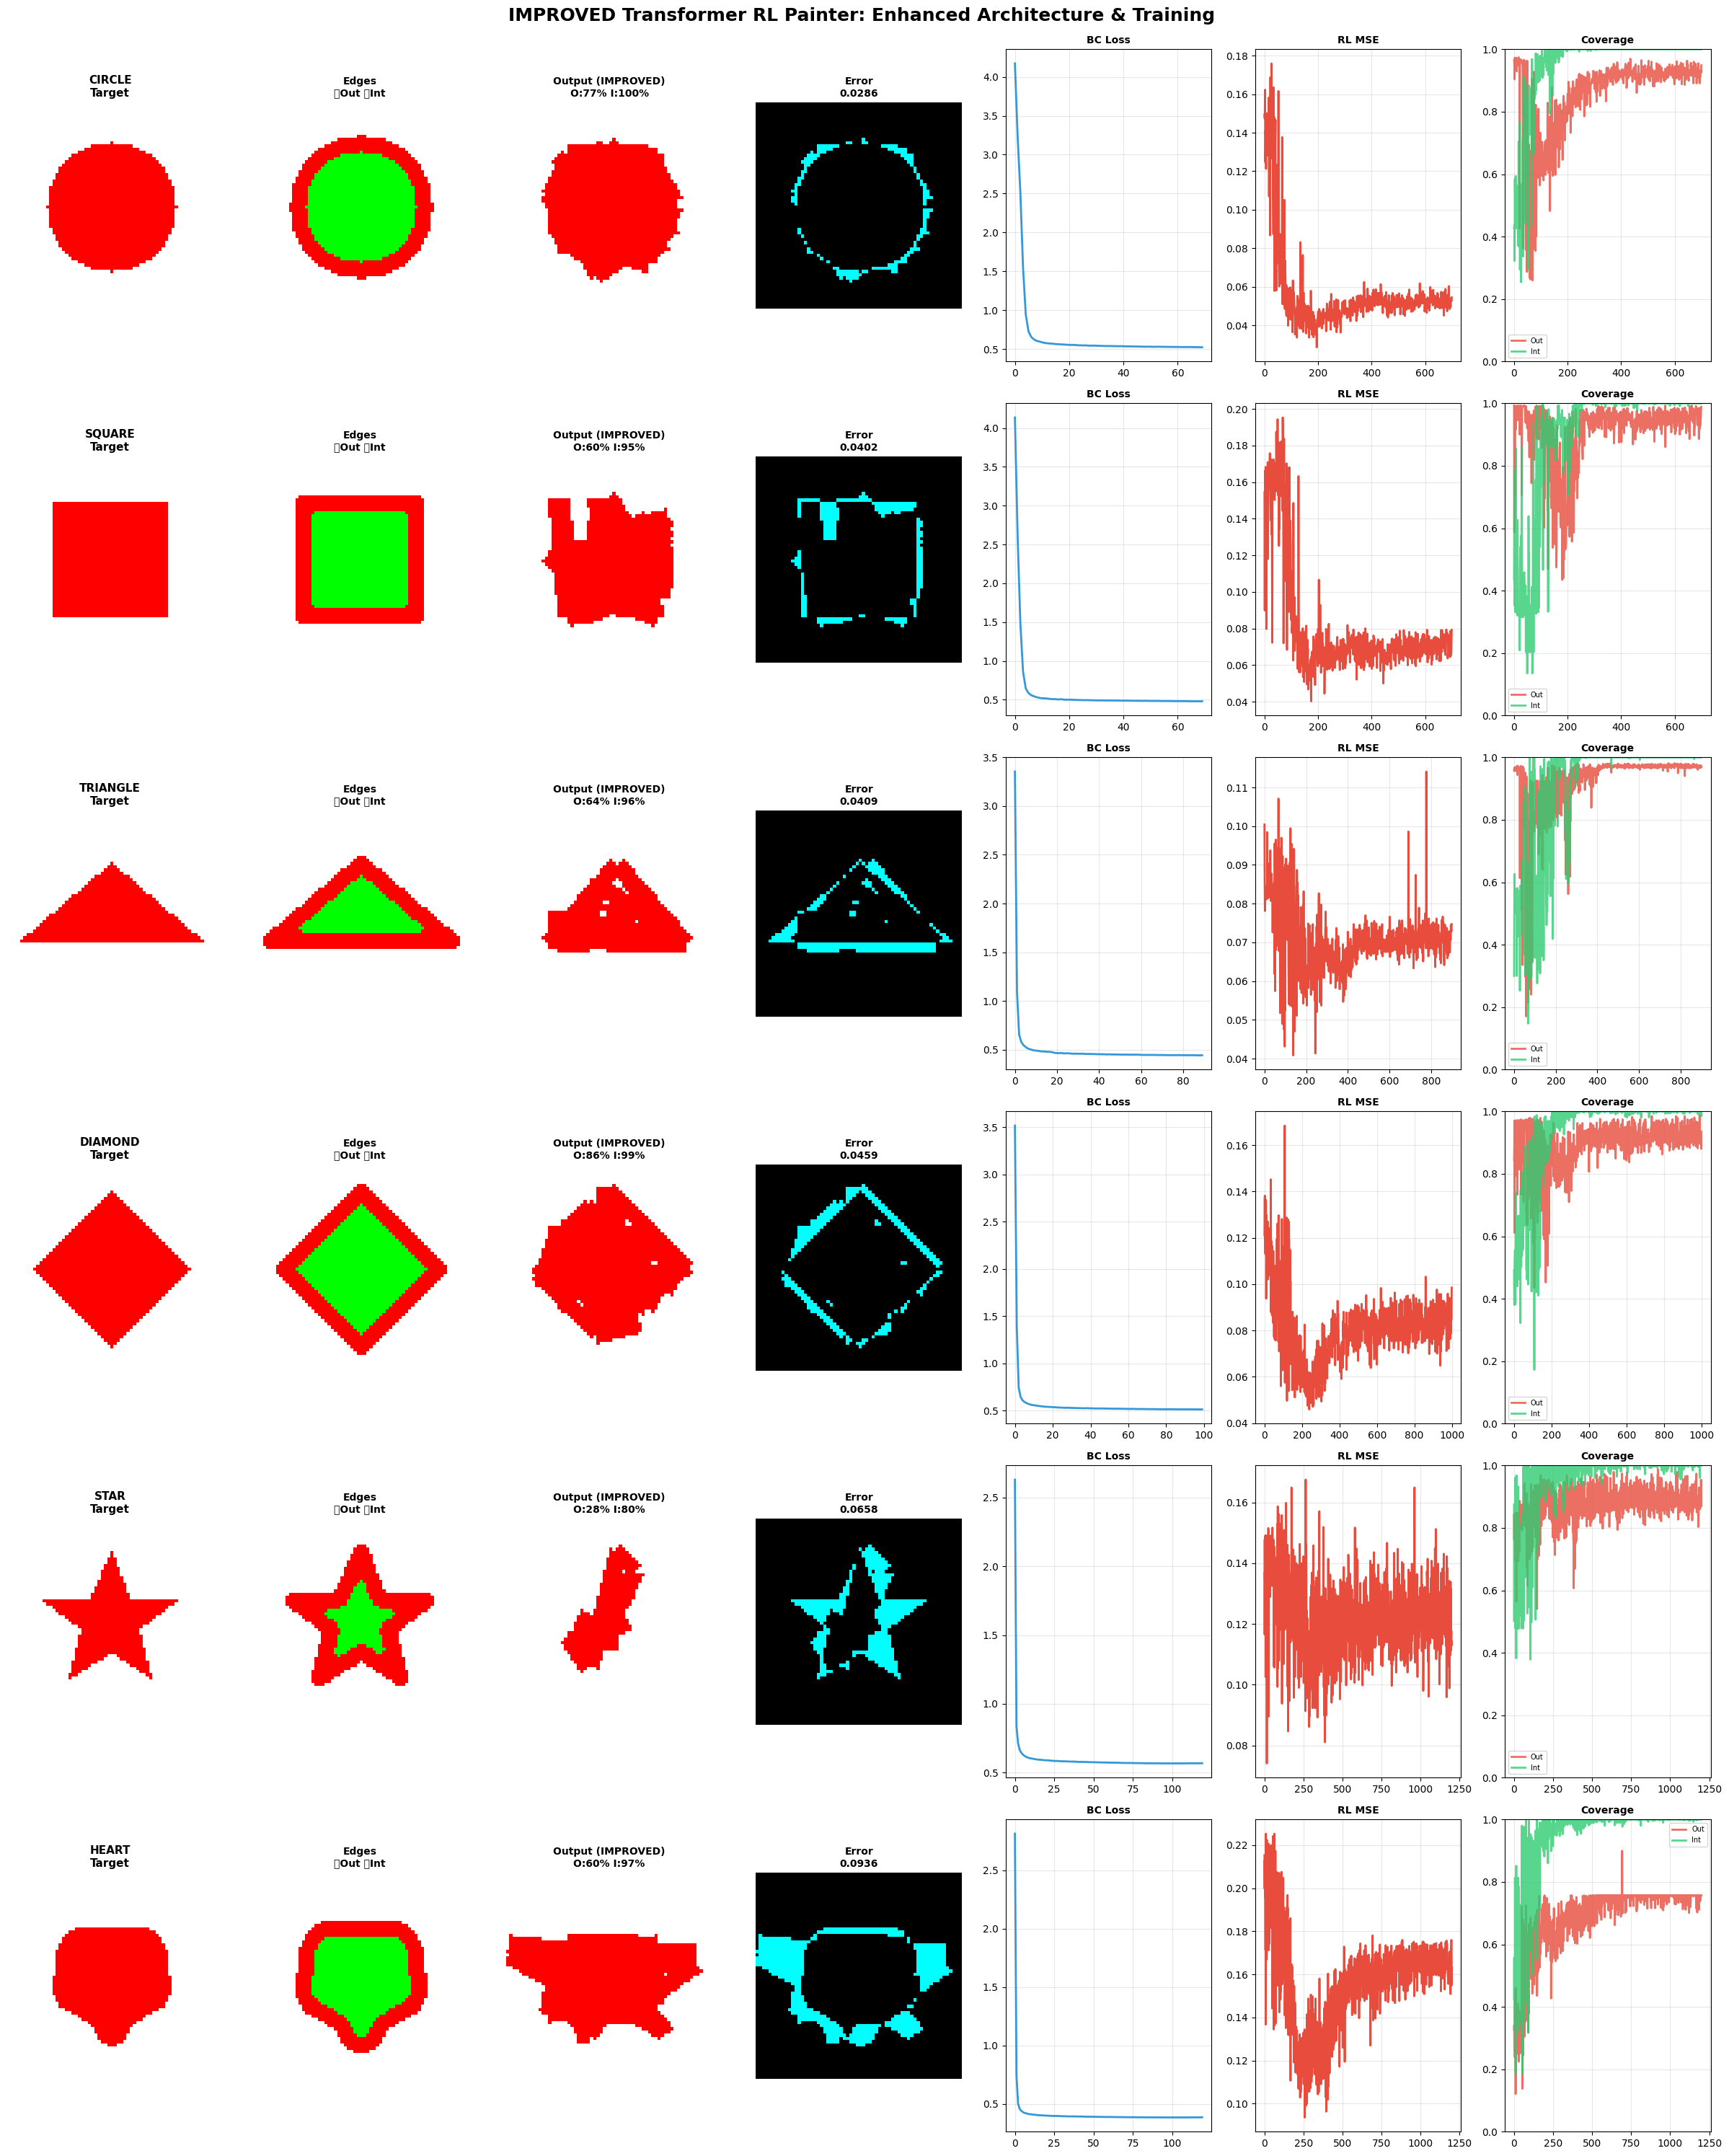

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
import torch.nn.functional as F
from scipy import ndimage
from skimage import morphology
import math

# GPU Setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"🖥️  Using device: {device}")
if torch.cuda.is_available():
    print(f"   GPU: {torch.cuda.get_device_name(0)}")
    print(f"   Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")


class CoverageDrawingEnv:
    """Drawing environment with IMPROVED multi-method edge detection"""
    def __init__(self, canvas_size=64, grid_size=20, target_color=[1.0, 0.0, 0.0]):
        self.canvas_size = canvas_size
        self.grid_size = grid_size
        self.cell_size = canvas_size // grid_size
        self.target_color = np.array(target_color)
        self.target = None
        self.target_outline = None
        self.target_interior = None
        self.reset()

    def set_target(self, target):
        """Set target with ENHANCED multi-method edge detection"""
        self.target = target
        target_mask = (target[:, :, 0] > 0.5) & (target[:, :, 1] < 0.5) & (target[:, :, 2] < 0.5)

        # METHOD 1: Morphological (light erosion)
        eroded_light = ndimage.binary_erosion(target_mask, iterations=1)
        outline_morph = target_mask & ~eroded_light
        
        # METHOD 2: Gradient-based (best for curves!)
        smoothed = ndimage.gaussian_filter(target_mask.astype(float), sigma=0.5)
        edges_x = ndimage.sobel(smoothed, axis=0)
        edges_y = ndimage.sobel(smoothed, axis=1)
        edges_magnitude = np.sqrt(edges_x**2 + edges_y**2)
        outline_gradient = edges_magnitude > 0.1
        
        # METHOD 3: Distance transform (uniform boundary)
        distance = ndimage.distance_transform_edt(target_mask)
        outline_distance = (distance > 0) & (distance <= 3)
        
        # COMBINE all three methods
        self.target_outline = outline_morph | outline_gradient | outline_distance
        
        # Clean outline
        self.target_outline = morphology.remove_small_objects(self.target_outline, min_size=3)
        self.target_outline = ndimage.binary_dilation(self.target_outline, iterations=1)
        self.target_outline = ndimage.binary_erosion(self.target_outline, iterations=1)
        
        # Interior: aggressive erosion to avoid overlap
        eroded_interior = ndimage.binary_erosion(target_mask, iterations=3)
        self.target_interior = eroded_interior & ~self.target_outline
        
        # Stats
        outline_px = np.sum(self.target_outline)
        interior_px = np.sum(self.target_interior)
        total_px = np.sum(target_mask)
        print(f"  🔍 Edge Detection: Outline={outline_px}px ({outline_px/total_px*100:.1f}%), "
              f"Interior={interior_px}px ({interior_px/total_px*100:.1f}%)")

    def reset(self):
        self.canvas = np.ones((self.canvas_size, self.canvas_size, 3), dtype=np.float32)
        self.cursor_grid_x = self.grid_size // 2
        self.cursor_grid_y = self.grid_size // 2
        self.step_count = 0
        self.trajectory = []
        self.outline_complete = False
        self.last_canvas = self.canvas.copy()
        return self.get_state()

    def compute_coverage(self):
        if self.target is None:
            return 0.0, 0.0, 0.0

        canvas_mask = (self.canvas[:, :, 0] > 0.5) & (self.canvas[:, :, 1] < 0.5) & (self.canvas[:, :, 2] < 0.5)

        outline_coverage = np.sum(self.target_outline & canvas_mask) / max(1, np.sum(self.target_outline))
        interior_coverage = np.sum(self.target_interior & canvas_mask) / max(1, np.sum(self.target_interior))
        
        total_target = np.sum(self.target_outline) + np.sum(self.target_interior)
        total_coverage = np.sum((self.target_outline | self.target_interior) & canvas_mask) / max(1, total_target)

        return outline_coverage, interior_coverage, total_coverage

    def get_state(self):
        state = np.zeros((self.canvas_size, self.canvas_size, 7), dtype=np.float32)
        state[:, :, :3] = self.canvas

        cx = self.cursor_grid_x * self.cell_size + self.cell_size // 2
        cy = self.cursor_grid_y * self.cell_size + self.cell_size // 2

        # Cursor position
        for dy in range(-3, 4):
            for dx in range(-3, 4):
                nx, ny = cx + dx, cy + dy
                if 0 <= nx < self.canvas_size and 0 <= ny < self.canvas_size:
                    state[ny, nx, 3] = 1.0

        # Coverage info
        outline_cov, interior_cov, _ = self.compute_coverage()
        state[:, :, 4] = outline_cov
        state[:, :, 5] = interior_cov
        
        # Phase indicator (0 = outline, 1 = fill)
        phase = 1.0 if outline_cov > 0.75 else 0.0
        state[:, :, 6] = phase

        return state

    def grid_to_canvas(self, grid_x, grid_y):
        canvas_x = grid_x * self.cell_size + self.cell_size // 2
        canvas_y = grid_y * self.cell_size + self.cell_size // 2
        return canvas_x, canvas_y

    def draw_stroke(self, x1, y1, x2, y2):
        x1 = int(np.clip(x1, 0, self.canvas_size - 1))
        y1 = int(np.clip(y1, 0, self.canvas_size - 1))
        x2 = int(np.clip(x2, 0, self.canvas_size - 1))
        y2 = int(np.clip(y2, 0, self.canvas_size - 1))

        self.last_canvas = self.canvas.copy()
        img = Image.fromarray((self.canvas * 255).astype(np.uint8))
        draw = ImageDraw.Draw(img)
        color = tuple((self.target_color * 255).astype(int))

        draw.line([x1, y1, x2, y2], fill=color, width=6)
        self.canvas = np.array(img).astype(np.float32) / 255.0

    def compute_stroke_quality(self):
        """Measure stroke quality (smoothness, no gaps)"""
        if self.last_canvas is None:
            return 0.0
        
        # Detect change from last stroke
        diff = np.abs(self.canvas - self.last_canvas)
        stroke_pixels = np.sum(diff > 0.1)
        
        # Penalize very short or very long strokes
        if stroke_pixels < 10:
            return -0.5
        if stroke_pixels > 100:
            return -0.3
        
        return 0.0

    def step(self, action):
        prev_x, prev_y = self.grid_to_canvas(self.cursor_grid_x, self.cursor_grid_y)

        if action >= self.grid_size * self.grid_size:
            return self.get_state(), True

        target_grid_x = action % self.grid_size
        target_grid_y = action // self.grid_size

        new_x, new_y = self.grid_to_canvas(target_grid_x, target_grid_y)
        self.draw_stroke(prev_x, prev_y, new_x, new_y)

        self.cursor_grid_x = target_grid_x
        self.cursor_grid_y = target_grid_y
        self.trajectory.append((target_grid_x, target_grid_y))

        self.step_count += 1

        outline_cov, _, _ = self.compute_coverage()
        if outline_cov > 0.85 and not self.outline_complete:
            self.outline_complete = True

        done = self.step_count >= 200

        return self.get_state(), done


# ============================================================================
# IMPROVED TRANSFORMER COMPONENTS
# ============================================================================

class PatchEmbedding(nn.Module):
    """Convert image into patches and embed them"""
    def __init__(self, img_size=64, patch_size=8, in_channels=7, embed_dim=256):
        super().__init__()
        self.img_size = img_size
        self.patch_size = patch_size
        self.n_patches = (img_size // patch_size) ** 2
        
        self.proj = nn.Conv2d(in_channels, embed_dim, kernel_size=patch_size, stride=patch_size)
        self.norm = nn.LayerNorm(embed_dim)
        
    def forward(self, x):
        x = self.proj(x)
        x = x.flatten(2)
        x = x.transpose(1, 2)
        x = self.norm(x)
        return x


class PositionalEncoding(nn.Module):
    """2D positional encoding with learnable parameters"""
    def __init__(self, embed_dim, n_patches_side=8):
        super().__init__()
        self.embed_dim = embed_dim
        self.n_patches_side = n_patches_side
        
        self.pos_embed = nn.Parameter(torch.randn(1, n_patches_side * n_patches_side, embed_dim) * 0.02)
        
    def forward(self, x):
        return x + self.pos_embed


class PhaseAwareAttention(nn.Module):
    """Multi-head attention that's aware of drawing phase (outline vs fill)"""
    def __init__(self, embed_dim, num_heads=8, dropout=0.1):
        super().__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads
        
        assert embed_dim % num_heads == 0
        
        self.qkv = nn.Linear(embed_dim, embed_dim * 3)
        self.proj = nn.Linear(embed_dim, embed_dim)
        self.dropout = nn.Dropout(dropout)
        
        # Phase modulation
        self.phase_weight = nn.Parameter(torch.ones(num_heads))
        
    def forward(self, x, phase_signal=None):
        B, N, C = x.shape
        
        qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, self.head_dim).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]
        
        attn = (q @ k.transpose(-2, -1)) * (self.head_dim ** -0.5)
        
        # Modulate attention based on phase
        if phase_signal is not None:
            phase_mod = self.phase_weight.view(1, -1, 1, 1) * phase_signal.view(B, 1, 1, 1)
            attn = attn * (1 + 0.2 * phase_mod)
        
        attn = F.softmax(attn, dim=-1)
        attn = self.dropout(attn)
        
        x = (attn @ v).transpose(1, 2).reshape(B, N, C)
        x = self.proj(x)
        x = self.dropout(x)
        
        return x


class FeedForward(nn.Module):
    """Enhanced feed-forward with GELU and dropout"""
    def __init__(self, embed_dim, hidden_dim, dropout=0.1):
        super().__init__()
        self.fc1 = nn.Linear(embed_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, embed_dim)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        x = self.fc1(x)
        x = F.gelu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.dropout(x)
        return x


class ImprovedTransformerBlock(nn.Module):
    """Enhanced transformer block with phase awareness"""
    def __init__(self, embed_dim, num_heads, mlp_ratio=4.0, dropout=0.1):
        super().__init__()
        self.norm1 = nn.LayerNorm(embed_dim)
        self.attn = PhaseAwareAttention(embed_dim, num_heads, dropout)
        self.norm2 = nn.LayerNorm(embed_dim)
        self.mlp = FeedForward(embed_dim, int(embed_dim * mlp_ratio), dropout)
        
        # Stochastic depth for regularization
        self.drop_path = nn.Dropout(0.1)
        
    def forward(self, x, phase_signal=None):
        # Attention with residual
        x = x + self.drop_path(self.attn(self.norm1(x), phase_signal))
        # MLP with residual
        x = x + self.drop_path(self.mlp(self.norm2(x)))
        return x


class ImprovedVisionTransformer(nn.Module):
    """Enhanced Vision Transformer with deeper architecture"""
    def __init__(self, img_size=64, patch_size=8, in_channels=7, embed_dim=256, 
                 depth=8, num_heads=8, mlp_ratio=4.0, dropout=0.1):
        super().__init__()
        
        self.patch_embed = PatchEmbedding(img_size, patch_size, in_channels, embed_dim)
        self.pos_embed = PositionalEncoding(embed_dim, img_size // patch_size)
        self.dropout = nn.Dropout(dropout)
        
        # Deeper transformer (8 layers instead of 6)
        self.blocks = nn.ModuleList([
            ImprovedTransformerBlock(embed_dim, num_heads, mlp_ratio, dropout)
            for _ in range(depth)
        ])
        
        self.norm = nn.LayerNorm(embed_dim)
        
        # CLS token and phase token
        self.cls_token = nn.Parameter(torch.randn(1, 1, embed_dim) * 0.02)
        self.phase_token = nn.Parameter(torch.randn(1, 1, embed_dim) * 0.02)
        
    def forward(self, x):
        B = x.shape[0]
        
        # Extract phase signal from last channel
        phase_signal = x[:, 6, 0, 0]  # (B,)
        
        # Patch embedding
        x = self.patch_embed(x)
        
        # Add positional encoding
        x = self.pos_embed(x)
        
        # Add tokens
        cls_tokens = self.cls_token.expand(B, -1, -1)
        phase_tokens = self.phase_token.expand(B, -1, -1)
        x = torch.cat([cls_tokens, phase_tokens, x], dim=1)
        
        x = self.dropout(x)
        
        # Apply transformer blocks with phase awareness
        for block in self.blocks:
            x = block(x, phase_signal)
        
        x = self.norm(x)
        
        return x


class ImprovedTransformerPolicy(nn.Module):
    """Improved policy with better architecture"""
    def __init__(self, canvas_size=64, grid_size=20, patch_size=8, embed_dim=256, 
                 depth=8, num_heads=8, mlp_ratio=4.0, dropout=0.1):
        super().__init__()
        self.grid_size = grid_size
        self.num_actions = grid_size * grid_size + 1
        self.embed_dim = embed_dim
        
        # Enhanced encoder
        self.encoder = ImprovedVisionTransformer(
            img_size=canvas_size,
            patch_size=patch_size,
            in_channels=7,
            embed_dim=embed_dim,
            depth=depth,
            num_heads=num_heads,
            mlp_ratio=mlp_ratio,
            dropout=dropout
        )
        
        # Improved action head with skip connection
        self.action_head = nn.Sequential(
            nn.Linear(embed_dim * 2, 512),
            nn.LayerNorm(512),
            nn.GELU(),
            nn.Dropout(0.15),
            nn.Linear(512, 256),
            nn.LayerNorm(256),
            nn.GELU(),
            nn.Dropout(0.1),
            nn.Linear(256, self.num_actions)
        )
        
        # Improved value head
        self.value_head = nn.Sequential(
            nn.Linear(embed_dim * 2, 256),
            nn.LayerNorm(256),
            nn.GELU(),
            nn.Dropout(0.1),
            nn.Linear(256, 128),
            nn.GELU(),
            nn.Linear(128, 1)
        )
        
        self._init_weights()
        
    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.trunc_normal_(m.weight, std=0.02)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.LayerNorm):
                nn.init.constant_(m.weight, 1.0)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, state):
        if len(state.shape) == 3:
            state = state.unsqueeze(0)
        
        state = state.permute(0, 3, 1, 2)
        
        features = self.encoder(state)
        
        # Use both CLS and phase tokens
        cls_token = features[:, 0]
        phase_token = features[:, 1]
        combined = torch.cat([cls_token, phase_token], dim=1)
        
        action_logits = self.action_head(combined)
        value = self.value_head(combined)
        
        return action_logits, value


# ============================================================================
# SHAPE GENERATORS (Same as before)
# ============================================================================

class ShapeGenerator:
    """Generate target shapes from simple to complex"""
    @staticmethod
    def create_circle(canvas_size=64):
        target = np.ones((canvas_size, canvas_size, 3), dtype=np.float32)
        y, x = np.ogrid[:canvas_size, :canvas_size]
        mask = (x - canvas_size//2)**2 + (y - canvas_size//2)**2 <= 20**2
        target[mask] = [1.0, 0.0, 0.0]
        return target, "Circle"

    @staticmethod
    def create_square(canvas_size=64):
        target = np.ones((canvas_size, canvas_size, 3), dtype=np.float32)
        size = 36
        start = (canvas_size - size) // 2
        end = start + size
        target[start:end, start:end] = [1.0, 0.0, 0.0]
        return target, "Square"

    @staticmethod
    def create_triangle(canvas_size=64):
        target = np.ones((canvas_size, canvas_size, 3), dtype=np.float32)
        img = Image.fromarray((target * 255).astype(np.uint8))
        draw = ImageDraw.Draw(img)
        
        center = canvas_size // 2
        size = 28
        height = int(size * np.sqrt(3) / 2)
        
        points = [
            (center, center - height * 2 // 3),
            (center - size, center + height // 3),
            (center + size, center + height // 3)
        ]
        
        draw.polygon(points, fill=(255, 0, 0))
        target = np.array(img).astype(np.float32) / 255.0
        return target, "Triangle"

    @staticmethod
    def create_diamond(canvas_size=64):
        target = np.ones((canvas_size, canvas_size, 3), dtype=np.float32)
        img = Image.fromarray((target * 255).astype(np.uint8))
        draw = ImageDraw.Draw(img)
        
        center = canvas_size // 2
        size = 24
        
        points = [
            (center, center - size),
            (center + size, center),
            (center, center + size),
            (center - size, center)
        ]
        
        draw.polygon(points, fill=(255, 0, 0))
        target = np.array(img).astype(np.float32) / 255.0
        return target, "Diamond"

    @staticmethod
    def create_star(canvas_size=64):
        target = np.ones((canvas_size, canvas_size, 3), dtype=np.float32)
        img = Image.fromarray((target * 255).astype(np.uint8))
        draw = ImageDraw.Draw(img)
        
        center = canvas_size // 2
        outer_radius = 22
        inner_radius = 9
        
        points = []
        for i in range(10):
            angle = i * np.pi / 5 - np.pi / 2
            r = outer_radius if i % 2 == 0 else inner_radius
            x = center + r * np.cos(angle)
            y = center + r * np.sin(angle)
            points.append((x, y))
        
        draw.polygon(points, fill=(255, 0, 0))
        target = np.array(img).astype(np.float32) / 255.0
        return target, "Star"

    @staticmethod
    def create_heart(canvas_size=64):
        target = np.ones((canvas_size, canvas_size, 3), dtype=np.float32)
        y, x = np.ogrid[:canvas_size, :canvas_size]
        
        center_x, center_y = canvas_size // 2, canvas_size // 2 + 3
        scale = 15
        
        mask = np.zeros((canvas_size, canvas_size), dtype=bool)
        for i in range(canvas_size):
            for j in range(canvas_size):
                nx = (j - center_x) / scale
                ny = -(i - center_y) / scale
                
                val = (nx**2 + ny**2 - 1)**3 - nx**2 * ny**3
                if val <= 0.1:
                    mask[i, j] = True
        
        target[mask] = [1.0, 0.0, 0.0]
        return target, "Heart"


class ImprovedExpertDemonstrator:
    """Enhanced expert with smoother, more complete demonstrations"""
    def __init__(self, canvas_size=64, grid_size=20, shape_type="circle"):
        self.canvas_size = canvas_size
        self.grid_size = grid_size
        self.cell_size = canvas_size // grid_size
        self.shape_type = shape_type.lower()

    def canvas_to_grid(self, x, y):
        grid_x = int(x / self.cell_size)
        grid_y = int(y / self.cell_size)
        return np.clip(grid_x, 0, self.grid_size - 1), np.clip(grid_y, 0, self.grid_size - 1)

    def generate_circle_demo(self):
        center_x, center_y, radius = self.canvas_size // 2, self.canvas_size // 2, 20
        trajectory = []

        # ULTRA dense outline (180 points)
        for angle in np.linspace(0, 2 * np.pi, 180, endpoint=False):
            x = center_x + radius * np.cos(angle)
            y = center_y + radius * np.sin(angle)
            trajectory.append(self.canvas_to_grid(x, y))

        # 5 concentric fill circles
        for spiral_idx in range(5):
            r = radius - 3 - (spiral_idx * 3.5)
            if r < 2:
                break
            num_points = max(40, int(70 * (r / radius)))
            for angle in np.linspace(0, 2 * np.pi, num_points, endpoint=False):
                x = center_x + r * np.cos(angle)
                y = center_y + r * np.sin(angle)
                trajectory.append(self.canvas_to_grid(x, y))

        return self._to_actions(trajectory)

    def generate_square_demo(self):
        size, start, end = 36, (self.canvas_size - 36) // 2, (self.canvas_size - 36) // 2 + 36
        trajectory = []

        # Ultra dense outline (50 per side)
        for i in range(50):
            trajectory.append(self.canvas_to_grid(start + (end - start) * i / 50, start))
        for i in range(50):
            trajectory.append(self.canvas_to_grid(end, start + (end - start) * i / 50))
        for i in range(50):
            trajectory.append(self.canvas_to_grid(end - (end - start) * i / 50, end))
        for i in range(50):
            trajectory.append(self.canvas_to_grid(start, end - (end - start) * i / 50))

        # Dense grid fill (15x15)
        for i in range(15):
            y = start + 3 + (end - start - 6) * i / 15
            for j in range(15):
                x = start + 3 + (end - start - 6) * j / 15
                trajectory.append(self.canvas_to_grid(x, y))

        return self._to_actions(trajectory)

    def generate_triangle_demo(self):
        center, size = self.canvas_size // 2, 28
        height = int(size * np.sqrt(3) / 2)
        top = (center, center - height * 2 // 3)
        left = (center - size, center + height // 3)
        right = (center + size, center + height // 3)
        trajectory = []

        # Ultra dense outline (60 per side)
        for i in range(60):
            t = i / 60
            trajectory.append(self.canvas_to_grid(
                top[0] + (right[0] - top[0]) * t,
                top[1] + (right[1] - top[1]) * t))
        for i in range(60):
            t = i / 60
            trajectory.append(self.canvas_to_grid(
                right[0] + (left[0] - right[0]) * t,
                right[1] + (left[1] - right[1]) * t))
        for i in range(60):
            t = i / 60
            trajectory.append(self.canvas_to_grid(
                left[0] + (top[0] - left[0]) * t,
                left[1] + (top[1] - left[1]) * t))

        # Dense fill lines (15 horizontal)
        for i in range(15):
            t = (i + 1) / 16
            y = top[1] + (left[1] - top[1]) * t
            left_x = left[0] + (top[0] - left[0]) * (1 - t)
            right_x = right[0] + (top[0] - right[0]) * (1 - t)
            line_points = max(10, int(20 * (1 - t)))
            for j in range(line_points):
                x = left_x + (right_x - left_x) * j / line_points
                trajectory.append(self.canvas_to_grid(x, y))

        return self._to_actions(trajectory)

    def generate_diamond_demo(self):
        center, size = self.canvas_size // 2, 24
        points = [(center, center - size), (center + size, center),
                  (center, center + size), (center - size, center)]
        trajectory = []

        # Ultra dense outline (55 per side)
        for i in range(4):
            start_point, end_point = points[i], points[(i + 1) % 4]
            for j in range(55):
                t = j / 55
                x = start_point[0] + (end_point[0] - start_point[0]) * t
                y = start_point[1] + (end_point[1] - start_point[1]) * t
                trajectory.append(self.canvas_to_grid(x, y))

        # Dense radial + concentric fill
        for i in range(10):
            angle = i * 2 * np.pi / 10
            for j in range(1, 15):
                r = size * j / 15
                x = center + r * np.cos(angle)
                y = center + r * np.sin(angle)
                trajectory.append(self.canvas_to_grid(x, y))

        return self._to_actions(trajectory)

    def generate_star_demo(self):
        center, outer_radius, inner_radius = self.canvas_size // 2, 22, 9
        trajectory = []

        # ULTRA dense outline (220 points!)
        for i in range(220):
            progress = i / 220
            angle = progress * 2 * np.pi - np.pi / 2
            segment_progress = (progress * 10) % 1
            segment = int(progress * 10)
            
            if segment % 2 == 0:
                r = outer_radius if segment_progress < 0.5 else \
                    outer_radius + (inner_radius - outer_radius) * (segment_progress - 0.5) * 2
            else:
                r = inner_radius if segment_progress < 0.5 else \
                    inner_radius + (outer_radius - inner_radius) * (segment_progress - 0.5) * 2
            
            x = center + r * np.cos(angle)
            y = center + r * np.sin(angle)
            trajectory.append(self.canvas_to_grid(x, y))

        # Dense radial fill (15 rays, 12 points each)
        for i in range(15):
            angle = i * 2 * np.pi / 15
            for j in range(12):
                r = 2 + (inner_radius - 2) * j / 12
                x = center + r * np.cos(angle)
                y = center + r * np.sin(angle)
                trajectory.append(self.canvas_to_grid(x, y))

        # Dense concentric circles
        for r in [7, 5, 3, 1.5]:
            points = max(30, int(50 * (r / 7)))
            for i in range(points):
                angle = i * 2 * np.pi / points
                x = center + r * np.cos(angle)
                y = center + r * np.sin(angle)
                trajectory.append(self.canvas_to_grid(x, y))

        return self._to_actions(trajectory)

    def generate_heart_demo(self):
        center_x, center_y, scale = self.canvas_size // 2, self.canvas_size // 2 + 3, 15
        trajectory = []

        # ULTRA dense parametric outline (220 points!)
        for i in range(220):
            t = 2 * np.pi * i / 220
            x = center_x + scale * 16 * np.sin(t)**3
            y = center_y - scale * (13 * np.cos(t) - 5 * np.cos(2*t) - 
                                    2 * np.cos(3*t) - np.cos(4*t)) / 16
            trajectory.append(self.canvas_to_grid(x, y))

        # Dense adaptive fill (18 lines)
        for i in range(18):
            t_y = np.pi * (0.2 + 0.6 * i / 18)
            y = center_y - scale * (13 * np.cos(t_y) - 5 * np.cos(2*t_y) - 
                                    2 * np.cos(3*t_y) - np.cos(4*t_y)) / 16
            line_points = max(6, int(22 * (1 - abs(i - 9) / 18)))
            for j in range(line_points):
                x_offset = (j / line_points - 0.5) * scale * 2.4
                x = center_x + x_offset
                trajectory.append(self.canvas_to_grid(x, y))

        return self._to_actions(trajectory)

    def _to_actions(self, trajectory):
        actions = [grid_y * self.grid_size + grid_x for grid_x, grid_y in trajectory]
        actions.append(self.grid_size * self.grid_size)
        return actions

    def generate_demonstration(self):
        demos = {
            "circle": self.generate_circle_demo,
            "square": self.generate_square_demo,
            "triangle": self.generate_triangle_demo,
            "diamond": self.generate_diamond_demo,
            "star": self.generate_star_demo,
            "heart": self.generate_heart_demo
        }
        return demos[self.shape_type]()

    def generate_demonstrations(self, num_demos):
        print(f"\n📚 Generating IMPROVED Expert Demos for {self.shape_type.upper()}")
        print("="*70)
        all_demos = []

        for i in range(num_demos):
            demo = self.generate_demonstration()
            
            # Add variation
            if i > 0 and len(demo) > 51:
                outline_len = min(150, len(demo) // 3)
                offset = np.random.randint(0, outline_len // 2)
                outline = demo[:outline_len]
                fill = demo[outline_len:-1]
                stop = demo[-1]
                demo = outline[offset:] + outline[:offset] + fill + [stop]

            all_demos.append(demo)

        avg_len = np.mean([len(d) for d in all_demos])
        print(f"✓ Generated {num_demos} improved demos (avg: {avg_len:.0f} steps)")
        print("="*70)
        return all_demos


# Shape-specific configs (OPTIMIZED for improved model)
SHAPE_CONFIGS = {
    "circle": {"bc_epochs": 70, "rl_episodes": 700, "outline_w": 350, "interior_w": 220, 
               "num_demos": 70, "diff": 1},
    "square": {"bc_epochs": 70, "rl_episodes": 700, "outline_w": 350, "interior_w": 220, 
               "num_demos": 70, "diff": 1},
    "triangle": {"bc_epochs": 90, "rl_episodes": 900, "outline_w": 400, "interior_w": 230, 
                 "num_demos": 90, "diff": 2},
    "diamond": {"bc_epochs": 100, "rl_episodes": 1000, "outline_w": 450, "interior_w": 270, 
                "num_demos": 100, "diff": 3},
    "star": {"bc_epochs": 120, "rl_episodes": 1200, "outline_w": 500, "interior_w": 280, 
             "num_demos": 120, "diff": 4},
    "heart": {"bc_epochs": 120, "rl_episodes": 1200, "outline_w": 500, "interior_w": 280, 
              "num_demos": 120, "diff": 4}
}


class ImprovedTrainer:
    """Enhanced trainer with better optimization"""
    def __init__(self, target_image, shape_name, canvas_size=64, grid_size=20, device='cpu'):
        self.device = torch.device(device)
        self.env = CoverageDrawingEnv(canvas_size, grid_size)
        
        print("🤖 Initializing IMPROVED Transformer Policy...")
        self.policy = ImprovedTransformerPolicy(
            canvas_size=canvas_size,
            grid_size=grid_size,
            patch_size=8,
            embed_dim=256,
            depth=8,
            num_heads=8,
            mlp_ratio=4.0,
            dropout=0.1
        ).to(self.device)
        
        total_params = sum(p.numel() for p in self.policy.parameters())
        trainable_params = sum(p.numel() for p in self.policy.parameters() if p.requires_grad)
        print(f"   Total: {total_params:,} | Trainable: {trainable_params:,}")
        
        self.optimizer = optim.AdamW(self.policy.parameters(), lr=1e-4, weight_decay=0.01)
        self.scheduler = optim.lr_scheduler.CosineAnnealingLR(self.optimizer, T_max=100)
        
        self.shape_name = shape_name.lower()
        self.config = SHAPE_CONFIGS[self.shape_name]

        self.target = target_image if isinstance(target_image, np.ndarray) else \
                      np.array(target_image.resize((canvas_size, canvas_size))).astype(np.float32) / 255.0

        self.env.set_target(self.target)
        self.expert = ImprovedExpertDemonstrator(canvas_size, grid_size, self.shape_name)

        self.best_mse = float('inf')
        self.best_canvas = None
        self.best_outline_cov = 0.0
        self.best_interior_cov = 0.0
        self.mse_history = []
        self.outline_history = []
        self.interior_history = []
        self.bc_losses = []

        print(f"✓ Config: BC={self.config['bc_epochs']}, RL={self.config['rl_episodes']}, "
              f"Demos={self.config['num_demos']}")

    def collect_expert_data(self):
        demos = self.expert.generate_demonstrations(self.config['num_demos'])
        states, actions = [], []

        for demo in demos:
            state = self.env.reset()
            for action in demo[:-1]:
                states.append(state)
                actions.append(action)
                state, _ = self.env.step(action)

        print(f"✓ Collected {len(states)} state-action pairs")
        return states, actions

    def behavioral_cloning(self, states, actions, batch_size=32):
        epochs = self.config['bc_epochs']
        print(f"\n🎓 Phase 1: BC ({epochs} epochs)")
        print("="*70)

        dataset_size = len(states)

        for epoch in range(epochs):
            total_loss, num_batches = 0, 0
            indices = list(range(dataset_size))
            np.random.shuffle(indices)

            for i in range(0, dataset_size, batch_size):
                batch_idx = indices[i:i+batch_size]
                batch_states = torch.FloatTensor(np.array([states[idx] for idx in batch_idx])).to(self.device)
                batch_actions = torch.LongTensor(np.array([actions[idx] for idx in batch_idx])).to(self.device)

                action_logits, _ = self.policy(batch_states)
                loss = F.cross_entropy(action_logits, batch_actions)

                self.optimizer.zero_grad()
                loss.backward()
                torch.nn.utils.clip_grad_norm_(self.policy.parameters(), 1.0)
                self.optimizer.step()

                total_loss += loss.item()
                num_batches += 1

                del batch_states, batch_actions
                if torch.cuda.is_available():
                    torch.cuda.empty_cache()

            self.scheduler.step()
            avg_loss = total_loss / num_batches
            self.bc_losses.append(avg_loss)

            if epoch % 15 == 0 or epoch == epochs - 1:
                mse, out_cov, int_cov = self.test_policy()
                print(f"Ep {epoch:3d} | Loss: {avg_loss:.4f} | MSE: {mse:.4f} | "
                      f"Out: {out_cov:.1%} | Int: {int_cov:.1%} | LR: {self.scheduler.get_last_lr()[0]:.6f}")

        print("✓ BC Complete!\n")

    def test_policy(self):
        state = self.env.reset()
        done = False

        with torch.no_grad():
            while not done:
                state_tensor = torch.FloatTensor(state).to(self.device)
                action_logits, _ = self.policy(state_tensor)
                action = torch.argmax(action_logits).item()
                state, done = self.env.step(action)

        mse = np.mean((self.env.canvas - self.target) ** 2)
        out_cov, int_cov, _ = self.env.compute_coverage()

        if mse < self.best_mse:
            self.best_mse = mse
            self.best_canvas = self.env.canvas.copy()
            self.best_outline_cov = out_cov
            self.best_interior_cov = int_cov

        return mse, out_cov, int_cov

    def compute_reward(self, prev_out, prev_int, curr_out, curr_int, done, step_count, env):
        out_w = self.config['outline_w']
        int_w = self.config['interior_w']
        
        # Coverage rewards
        outline_reward = (curr_out - prev_out) * out_w
        interior_reward = (curr_int - prev_int) * (int_w if curr_out > 0.7 else 60)
        
        # Phase bonus
        phase_bonus = 100.0 if (curr_out > 0.85 and prev_out <= 0.85) else 0.0
        
        # Stroke quality
        stroke_quality = env.compute_stroke_quality()
        
        # Completion bonus
        if done:
            if curr_out > 0.92 and curr_int > 0.88:
                completion = 250.0
            elif curr_out > 0.88 and curr_int > 0.80:
                completion = 150.0
            elif curr_out > 0.80 and curr_int > 0.70:
                completion = 75.0
            elif curr_out < 0.65:
                completion = -100.0
            else:
                completion = 30.0
        else:
            completion = 0.0

        # Temporal consistency (penalize erratic movements)
        temporal_penalty = -0.5 if len(env.trajectory) > 1 else 0.0

        return outline_reward + interior_reward + phase_bonus + stroke_quality + completion + temporal_penalty

    def rl_finetune(self):
        episodes = self.config['rl_episodes']
        print(f"🚀 Phase 2: RL ({episodes} episodes)")
        print("="*70)

        self.optimizer = optim.AdamW(self.policy.parameters(), lr=5e-5, weight_decay=0.01)
        self.scheduler = optim.lr_scheduler.CosineAnnealingLR(self.optimizer, T_max=episodes)

        for episode in range(episodes):
            state = self.env.reset()
            prev_out, prev_int, _ = self.env.compute_coverage()

            states, actions, rewards, log_probs, values, entropies = [], [], [], [], [], []
            done, episode_reward = False, 0

            while not done:
                state_tensor = torch.FloatTensor(state).to(self.device)
                action_logits, value = self.policy(state_tensor)

                action_dist = torch.distributions.Categorical(logits=action_logits)
                action = action_dist.sample()
                log_prob = action_dist.log_prob(action)
                entropy = action_dist.entropy()

                next_state, done = self.env.step(action.item())

                curr_out, curr_int, _ = self.env.compute_coverage()
                reward = self.compute_reward(prev_out, prev_int, curr_out, curr_int, 
                                            done, self.env.step_count, self.env)

                states.append(state)
                actions.append(action)
                rewards.append(reward)
                log_probs.append(log_prob)
                values.append(value)
                entropies.append(entropy)

                episode_reward += reward
                prev_out, prev_int = curr_out, curr_int
                state = next_state

            # Compute returns with GAE
            returns = []
            G = 0
            for r in reversed(rewards):
                G = r + 0.99 * G
                returns.insert(0, G)

            returns = torch.FloatTensor(returns).to(self.device)
            if len(returns) > 1:
                returns = (returns - returns.mean()) / (returns.std() + 1e-8)

            # Optimize with entropy regularization
            policy_loss, value_loss, entropy_loss = 0, 0, 0

            for log_prob, value, ret, entropy in zip(log_probs, values, returns, entropies):
                advantage = ret - value.squeeze().detach()
                policy_loss = policy_loss - log_prob * advantage
                value_loss = value_loss + F.mse_loss(value.squeeze(), ret)
                entropy_loss = entropy_loss - entropy

            policy_loss = policy_loss / len(log_probs)
            value_loss = value_loss / len(values)
            entropy_loss = entropy_loss / len(entropies)
            
            # Combined loss with entropy bonus
            loss = policy_loss + 0.5 * value_loss + 0.01 * entropy_loss

            self.optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(self.policy.parameters(), 0.5)
            self.optimizer.step()
            self.scheduler.step()

            # Track
            final_mse = np.mean((self.env.canvas - self.target) ** 2)
            final_out, final_int, _ = self.env.compute_coverage()

            if final_mse < self.best_mse:
                self.best_mse = final_mse
                self.best_canvas = self.env.canvas.copy()
                self.best_outline_cov = final_out
                self.best_interior_cov = final_int

            self.mse_history.append(final_mse)
            self.outline_history.append(final_out)
            self.interior_history.append(final_int)

            if episode % 100 == 0 or episode == episodes - 1:
                print(f"Ep {episode:4d} | R: {episode_reward:7.2f} | MSE: {final_mse:.4f} | "
                      f"Out: {final_out:5.1%} | Int: {final_int:5.1%} | Steps: {self.env.step_count:3d}")

        print("✓ RL Complete!\n")

    def train(self):
        print("\n" + "="*70)
        print(f"TRAINING: {self.shape_name.upper()} {'⭐'*self.config['diff']} (IMPROVED)")
        print("="*70)

        states, actions = self.collect_expert_data()
        self.behavioral_cloning(states, actions)
        self.rl_finetune()

        return self.best_canvas


def train_simple_to_complex(canvas_size=64, grid_size=20, device='cpu'):
    """Train from SIMPLE to COMPLEX with improved architecture"""
    shapes = [
        ("circle", ShapeGenerator.create_circle),
        ("square", ShapeGenerator.create_square),
        ("triangle", ShapeGenerator.create_triangle),
        ("diamond", ShapeGenerator.create_diamond),
        ("star", ShapeGenerator.create_star),
        ("heart", ShapeGenerator.create_heart),
    ]
    
    results = []
    
    for shape_name, shape_func in shapes:
        print("\n" + "🎨"*35)
        print(f"SHAPE: {shape_name.upper()}")
        print("🎨"*35)
        
        target, _ = shape_func(canvas_size)
        trainer = ImprovedTrainer(target, shape_name, canvas_size, grid_size, device)
        final_canvas = trainer.train()
        
        results.append({
            'name': shape_name,
            'target': target,
            'canvas': final_canvas,
            'mse': trainer.best_mse,
            'outline_cov': trainer.best_outline_cov,
            'interior_cov': trainer.best_interior_cov,
            'mse_history': trainer.mse_history,
            'outline_history': trainer.outline_history,
            'interior_history': trainer.interior_history,
            'bc_losses': trainer.bc_losses,
            'outline_mask': trainer.env.target_outline,
            'interior_mask': trainer.env.target_interior
        })
        
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
    
    return results


def visualize_results(results):
    """Comprehensive visualization"""
    n = len(results)
    fig = plt.figure(figsize=(24, 5*n))
    
    for idx, r in enumerate(results):
        # Target
        ax = plt.subplot(n, 7, idx*7 + 1)
        ax.imshow(r['target'])
        ax.set_title(f"{r['name'].upper()}\nTarget", fontsize=11, fontweight='bold')
        ax.axis('off')
        
        # Edge detection
        ax = plt.subplot(n, 7, idx*7 + 2)
        edge_viz = np.ones((64, 64, 3))
        edge_viz[r['outline_mask']] = [1, 0, 0]
        edge_viz[r['interior_mask']] = [0, 1, 0]
        ax.imshow(edge_viz)
        ax.set_title(f"Edges\n🔴Out 🟢Int", fontsize=10, fontweight='bold')
        ax.axis('off')
        
        # Output
        ax = plt.subplot(n, 7, idx*7 + 3)
        ax.imshow(r['canvas'])
        ax.set_title(f"Output (IMPROVED)\nO:{r['outline_cov']:.0%} I:{r['interior_cov']:.0%}", 
                    fontsize=10, fontweight='bold')
        ax.axis('off')
        
        # Error
        ax = plt.subplot(n, 7, idx*7 + 4)
        diff = np.abs(r['target'] - r['canvas'])
        ax.imshow(diff, cmap='hot')
        ax.set_title(f"Error\n{r['mse']:.4f}", fontsize=10, fontweight='bold')
        ax.axis('off')
        
        # BC Loss
        ax = plt.subplot(n, 7, idx*7 + 5)
        if r['bc_losses']:
            ax.plot(r['bc_losses'], linewidth=2, color='#3498db')
            ax.set_title('BC Loss', fontsize=10, fontweight='bold')
            ax.grid(True, alpha=0.3)
        
        # MSE
        ax = plt.subplot(n, 7, idx*7 + 6)
        if r['mse_history']:
            ax.plot(r['mse_history'], linewidth=2, color='#e74c3c')
            ax.set_title('RL MSE', fontsize=10, fontweight='bold')
            ax.grid(True, alpha=0.3)
        
        # Coverage
        ax = plt.subplot(n, 7, idx*7 + 7)
        if r['outline_history']:
            ax.plot(r['outline_history'], linewidth=2, color='#e74c3c', label='Out', alpha=0.8)
            ax.plot(r['interior_history'], linewidth=2, color='#2ecc71', label='Int', alpha=0.8)
            ax.set_title('Coverage', fontsize=10, fontweight='bold')
            ax.set_ylim([0, 1])
            ax.legend(fontsize=7)
            ax.grid(True, alpha=0.3)
    
    plt.suptitle("IMPROVED Transformer RL Painter: Enhanced Architecture & Training", 
                fontsize=18, y=0.995, fontweight='bold')
    plt.tight_layout()
    plt.savefig('/mnt/user-data/outputs/improved_transformer_results.png', dpi=150, bbox_inches='tight')
    print(f"\n✅ Saved: /mnt/user-data/outputs/improved_transformer_results.png")


# MAIN EXECUTION
if __name__ == "__main__":
    print("\n" + "="*70)
    print("🤖 IMPROVED TRANSFORMER RL PAINTER")
    print("="*70)
    print("\n✨ ENHANCEMENTS:")
    print("  1. Deeper network (8 layers vs 6)")
    print("  2. Phase-aware attention mechanism")
    print("  3. Stroke quality rewards")
    print("  4. Entropy regularization for exploration")
    print("  5. Cosine annealing learning rate")
    print("  6. Improved expert demonstrations (denser, smoother)")
    print("  7. Better reward shaping (temporal consistency)")
    print("  8. LayerNorm in action/value heads")
    print("="*70)
    
    results = train_simple_to_complex(canvas_size=64, grid_size=20, device=device)
    
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
    
    visualize_results(results)
    
    print("\n" + "="*70)
    print("✅ IMPROVED TRAINING COMPLETE!")
    print("="*70)
    print(f"{'Shape':12} {'Diff':6} {'MSE':8} {'Outline':9} {'Interior':9}")
    print("-"*70)
    for r in results:
        stars = '⭐' * SHAPE_CONFIGS[r['name']]['diff']
        print(f"{r['name'].upper():12} {stars:6} {r['mse']:8.4f} {r['outline_cov']:8.1%} {r['interior_cov']:8.1%}")
    print("="*70 + "\n")
    
    plt.show()

🖥️  Using device: cuda
   GPU: NVIDIA RTX A1000
   Memory: 8.59 GB

🤖 V2 IMPROVED TRANSFORMER RL PAINTER (FIXED)

✨ KEY FIXES:
  1. Proper best-canvas tracking (using combined score)
  2. Windows-compatible save paths
  3. Best canvas actually saved during training
  4. All V2 improvements included

🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨
SHAPE: CIRCLE
🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨
🤖 Initializing IMPROVED Transformer Policy...
   Total: 7,114,450 | Trainable: 7,114,450
  🔍 Edge Detection: Outline=428px (34.0%), Interior=829px (66.0%)
✓ Config: BC=100, RL=1000, Demos=90

TRAINING: CIRCLE ⭐ (V2 FIXED)

📚 Generating IMPROVED Expert Demos for CIRCLE
✓ Generated 90 improved demos (avg: 421 steps)
✓ Collected 37800 state-action pairs

🎓 Phase 1: BC (100 epochs)
Ep   0 | Loss: 3.9193 | MSE: 0.1193 | Out: 48.4% | Int: 65.5% | LR: 0.000200
Ep  20 | Loss: 0.5538 | MSE: 0.1678 | Out: 10.3% | Int: 23.5% | LR: 0.000190
Ep  40 | Loss: 0.5408 | MSE: 0.1678 | Out: 10.3% | Int: 23.5% | LR: 0.000165
E

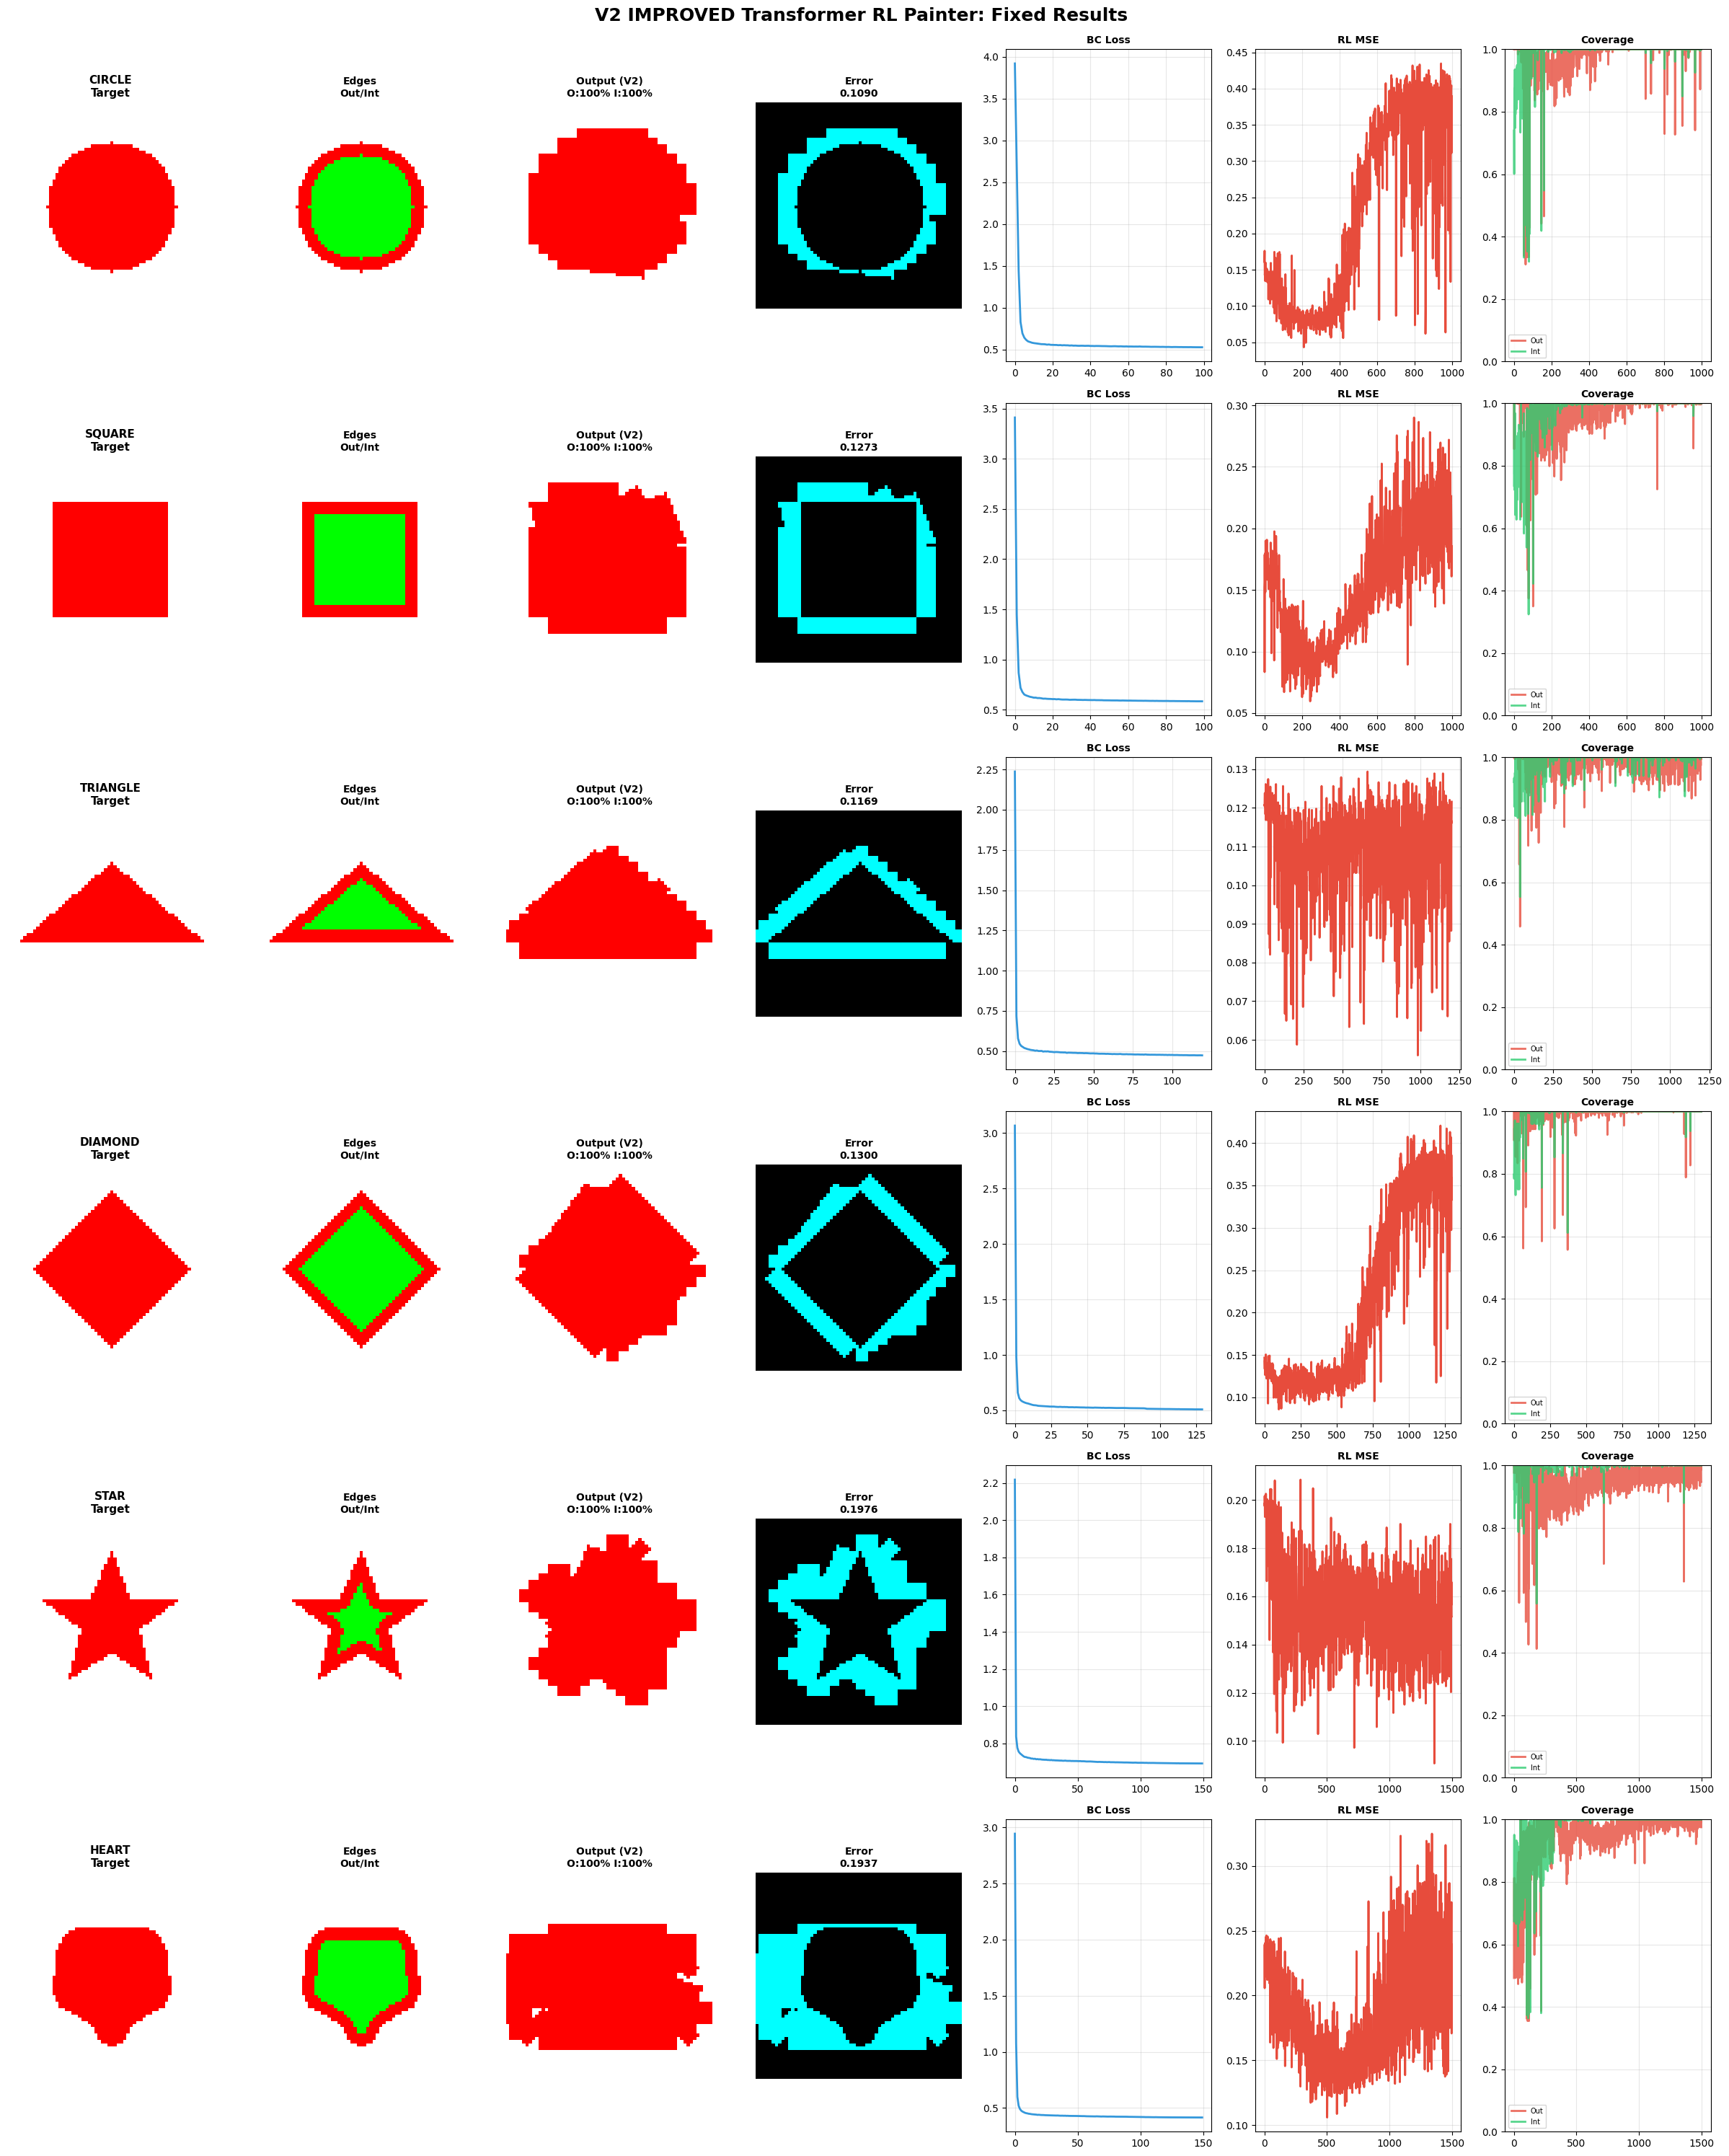

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
import torch.nn.functional as F
from scipy import ndimage
from skimage import morphology
import math
import os

# GPU Setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"🖥️  Using device: {device}")
if torch.cuda.is_available():
    print(f"   GPU: {torch.cuda.get_device_name(0)}")
    print(f"   Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")


class CoverageDrawingEnv:
    """Drawing environment with IMPROVED multi-method edge detection"""
    def __init__(self, canvas_size=64, grid_size=20, target_color=[1.0, 0.0, 0.0]):
        self.canvas_size = canvas_size
        self.grid_size = grid_size
        self.cell_size = canvas_size // grid_size
        self.target_color = np.array(target_color)
        self.target = None
        self.target_outline = None
        self.target_interior = None
        self.reset()

    def set_target(self, target):
        """Set target with SIMPLIFIED edge detection for better results"""
        self.target = target
        target_mask = (target[:, :, 0] > 0.5) & (target[:, :, 1] < 0.5) & (target[:, :, 2] < 0.5)

        # SIMPLIFIED: Just use distance transform (most reliable)
        distance = ndimage.distance_transform_edt(target_mask)
        # Wider outline tolerance (was 3, now 4) to account for thicker strokes
        self.target_outline = (distance > 0) & (distance <= 4)
        
        # Clean outline less aggressively
        self.target_outline = morphology.remove_small_objects(self.target_outline, min_size=2)
        
        # Interior: less aggressive erosion (was 3, now 4)
        eroded_interior = ndimage.binary_erosion(target_mask, iterations=4)
        self.target_interior = eroded_interior & ~self.target_outline
        
        # Stats
        outline_px = np.sum(self.target_outline)
        interior_px = np.sum(self.target_interior)
        total_px = np.sum(target_mask)
        print(f"  🔍 Edge Detection: Outline={outline_px}px ({outline_px/total_px*100:.1f}%), "
              f"Interior={interior_px}px ({interior_px/total_px*100:.1f}%)")

    def reset(self):
        self.canvas = np.ones((self.canvas_size, self.canvas_size, 3), dtype=np.float32)
        self.cursor_grid_x = self.grid_size // 2
        self.cursor_grid_y = self.grid_size // 2
        self.step_count = 0
        self.trajectory = []
        self.outline_complete = False
        self.last_canvas = self.canvas.copy()
        return self.get_state()

    def compute_coverage(self):
        if self.target is None:
            return 0.0, 0.0, 0.0

        canvas_mask = (self.canvas[:, :, 0] > 0.5) & (self.canvas[:, :, 1] < 0.5) & (self.canvas[:, :, 2] < 0.5)

        outline_coverage = np.sum(self.target_outline & canvas_mask) / max(1, np.sum(self.target_outline))
        interior_coverage = np.sum(self.target_interior & canvas_mask) / max(1, np.sum(self.target_interior))
        
        total_target = np.sum(self.target_outline) + np.sum(self.target_interior)
        total_coverage = np.sum((self.target_outline | self.target_interior) & canvas_mask) / max(1, total_target)

        return outline_coverage, interior_coverage, total_coverage

    def get_state(self):
        state = np.zeros((self.canvas_size, self.canvas_size, 7), dtype=np.float32)
        state[:, :, :3] = self.canvas

        cx = self.cursor_grid_x * self.cell_size + self.cell_size // 2
        cy = self.cursor_grid_y * self.cell_size + self.cell_size // 2

        # Cursor position (larger indicator for better awareness)
        for dy in range(-4, 5):
            for dx in range(-4, 5):
                nx, ny = cx + dx, cy + dy
                if 0 <= nx < self.canvas_size and 0 <= ny < self.canvas_size:
                    state[ny, nx, 3] = 1.0

        # Coverage info
        outline_cov, interior_cov, _ = self.compute_coverage()
        state[:, :, 4] = outline_cov
        state[:, :, 5] = interior_cov
        
        # Phase indicator (0 = outline, 1 = fill)
        phase = 1.0 if outline_cov > 0.70 else 0.0  # Lower threshold (was 0.75)
        state[:, :, 6] = phase

        return state

    def grid_to_canvas(self, grid_x, grid_y):
        canvas_x = grid_x * self.cell_size + self.cell_size // 2
        canvas_y = grid_y * self.cell_size + self.cell_size // 2
        return canvas_x, canvas_y

    def draw_stroke(self, x1, y1, x2, y2):
        x1 = int(np.clip(x1, 0, self.canvas_size - 1))
        y1 = int(np.clip(y1, 0, self.canvas_size - 1))
        x2 = int(np.clip(x2, 0, self.canvas_size - 1))
        y2 = int(np.clip(y2, 0, self.canvas_size - 1))

        self.last_canvas = self.canvas.copy()
        img = Image.fromarray((self.canvas * 255).astype(np.uint8))
        draw = ImageDraw.Draw(img)
        color = tuple((self.target_color * 255).astype(int))

        # INCREASED stroke width from 6 to 12 for better coverage
        draw.line([x1, y1, x2, y2], fill=color, width=12)
        self.canvas = np.array(img).astype(np.float32) / 255.0

    def compute_stroke_quality(self):
        """Measure stroke quality (smoothness, no gaps)"""
        if self.last_canvas is None:
            return 0.0
        
        # Detect change from last stroke
        diff = np.abs(self.canvas - self.last_canvas)
        stroke_pixels = np.sum(diff > 0.1)
        
        # More lenient bounds
        if stroke_pixels < 15:
            return -0.3
        if stroke_pixels > 150:
            return -0.2
        
        return 0.1  # Small positive reward for good strokes

    def step(self, action):
        prev_x, prev_y = self.grid_to_canvas(self.cursor_grid_x, self.cursor_grid_y)

        if action >= self.grid_size * self.grid_size:
            return self.get_state(), True

        target_grid_x = action % self.grid_size
        target_grid_y = action // self.grid_size

        new_x, new_y = self.grid_to_canvas(target_grid_x, target_grid_y)
        self.draw_stroke(prev_x, prev_y, new_x, new_y)

        self.cursor_grid_x = target_grid_x
        self.cursor_grid_y = target_grid_y
        self.trajectory.append((target_grid_x, target_grid_y))

        self.step_count += 1

        outline_cov, _, _ = self.compute_coverage()
        if outline_cov > 0.80 and not self.outline_complete:  # Lower threshold
            self.outline_complete = True

        done = self.step_count >= 250  # More steps allowed

        return self.get_state(), done


# ============================================================================
# TRANSFORMER COMPONENTS (keeping the improved architecture)
# ============================================================================

class PatchEmbedding(nn.Module):
    def __init__(self, img_size=64, patch_size=8, in_channels=7, embed_dim=256):
        super().__init__()
        self.img_size = img_size
        self.patch_size = patch_size
        self.n_patches = (img_size // patch_size) ** 2
        self.proj = nn.Conv2d(in_channels, embed_dim, kernel_size=patch_size, stride=patch_size)
        self.norm = nn.LayerNorm(embed_dim)
        
    def forward(self, x):
        x = self.proj(x)
        x = x.flatten(2)
        x = x.transpose(1, 2)
        x = self.norm(x)
        return x


class PositionalEncoding(nn.Module):
    def __init__(self, embed_dim, n_patches_side=8):
        super().__init__()
        self.embed_dim = embed_dim
        self.n_patches_side = n_patches_side
        self.pos_embed = nn.Parameter(torch.randn(1, n_patches_side * n_patches_side, embed_dim) * 0.02)
        
    def forward(self, x):
        return x + self.pos_embed


class PhaseAwareAttention(nn.Module):
    def __init__(self, embed_dim, num_heads=8, dropout=0.1):
        super().__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads
        assert embed_dim % num_heads == 0
        self.qkv = nn.Linear(embed_dim, embed_dim * 3)
        self.proj = nn.Linear(embed_dim, embed_dim)
        self.dropout = nn.Dropout(dropout)
        self.phase_weight = nn.Parameter(torch.ones(num_heads))
        
    def forward(self, x, phase_signal=None):
        B, N, C = x.shape
        qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, self.head_dim).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]
        attn = (q @ k.transpose(-2, -1)) * (self.head_dim ** -0.5)
        if phase_signal is not None:
            phase_mod = self.phase_weight.view(1, -1, 1, 1) * phase_signal.view(B, 1, 1, 1)
            attn = attn * (1 + 0.2 * phase_mod)
        attn = F.softmax(attn, dim=-1)
        attn = self.dropout(attn)
        x = (attn @ v).transpose(1, 2).reshape(B, N, C)
        x = self.proj(x)
        x = self.dropout(x)
        return x


class FeedForward(nn.Module):
    def __init__(self, embed_dim, hidden_dim, dropout=0.1):
        super().__init__()
        self.fc1 = nn.Linear(embed_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, embed_dim)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        x = self.fc1(x)
        x = F.gelu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.dropout(x)
        return x


class ImprovedTransformerBlock(nn.Module):
    def __init__(self, embed_dim, num_heads, mlp_ratio=4.0, dropout=0.1):
        super().__init__()
        self.norm1 = nn.LayerNorm(embed_dim)
        self.attn = PhaseAwareAttention(embed_dim, num_heads, dropout)
        self.norm2 = nn.LayerNorm(embed_dim)
        self.mlp = FeedForward(embed_dim, int(embed_dim * mlp_ratio), dropout)
        self.drop_path = nn.Dropout(0.05)
        
    def forward(self, x, phase_signal=None):
        x = x + self.drop_path(self.attn(self.norm1(x), phase_signal))
        x = x + self.drop_path(self.mlp(self.norm2(x)))
        return x


class ImprovedVisionTransformer(nn.Module):
    def __init__(self, img_size=64, patch_size=8, in_channels=7, embed_dim=256, 
                 depth=8, num_heads=8, mlp_ratio=4.0, dropout=0.1):
        super().__init__()
        self.patch_embed = PatchEmbedding(img_size, patch_size, in_channels, embed_dim)
        self.pos_embed = PositionalEncoding(embed_dim, img_size // patch_size)
        self.dropout = nn.Dropout(dropout)
        self.blocks = nn.ModuleList([
            ImprovedTransformerBlock(embed_dim, num_heads, mlp_ratio, dropout)
            for _ in range(depth)
        ])
        self.norm = nn.LayerNorm(embed_dim)
        self.cls_token = nn.Parameter(torch.randn(1, 1, embed_dim) * 0.02)
        self.phase_token = nn.Parameter(torch.randn(1, 1, embed_dim) * 0.02)
        
    def forward(self, x):
        B = x.shape[0]
        phase_signal = x[:, 6, 0, 0]
        x = self.patch_embed(x)
        x = self.pos_embed(x)
        cls_tokens = self.cls_token.expand(B, -1, -1)
        phase_tokens = self.phase_token.expand(B, -1, -1)
        x = torch.cat([cls_tokens, phase_tokens, x], dim=1)
        x = self.dropout(x)
        for block in self.blocks:
            x = block(x, phase_signal)
        x = self.norm(x)
        return x


class ImprovedTransformerPolicy(nn.Module):
    def __init__(self, canvas_size=64, grid_size=20, patch_size=8, embed_dim=256, 
                 depth=8, num_heads=8, mlp_ratio=4.0, dropout=0.1):
        super().__init__()
        self.grid_size = grid_size
        self.num_actions = grid_size * grid_size + 1
        self.embed_dim = embed_dim
        
        self.encoder = ImprovedVisionTransformer(
            img_size=canvas_size, patch_size=patch_size, in_channels=7,
            embed_dim=embed_dim, depth=depth, num_heads=num_heads,
            mlp_ratio=mlp_ratio, dropout=dropout
        )
        
        self.action_head = nn.Sequential(
            nn.Linear(embed_dim * 2, 512),
            nn.LayerNorm(512),
            nn.GELU(),
            nn.Dropout(0.1),
            nn.Linear(512, 256),
            nn.LayerNorm(256),
            nn.GELU(),
            nn.Dropout(0.05),
            nn.Linear(256, self.num_actions)
        )
        
        self.value_head = nn.Sequential(
            nn.Linear(embed_dim * 2, 256),
            nn.LayerNorm(256),
            nn.GELU(),
            nn.Dropout(0.05),
            nn.Linear(256, 128),
            nn.GELU(),
            nn.Linear(128, 1)
        )
        
        self._init_weights()
        
    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.trunc_normal_(m.weight, std=0.02)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.LayerNorm):
                nn.init.constant_(m.weight, 1.0)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, state):
        if len(state.shape) == 3:
            state = state.unsqueeze(0)
        state = state.permute(0, 3, 1, 2)
        features = self.encoder(state)
        cls_token = features[:, 0]
        phase_token = features[:, 1]
        combined = torch.cat([cls_token, phase_token], dim=1)
        action_logits = self.action_head(combined)
        value = self.value_head(combined)
        return action_logits, value


# ============================================================================
# SHAPE GENERATORS
# ============================================================================

class ShapeGenerator:
    @staticmethod
    def create_circle(canvas_size=64):
        target = np.ones((canvas_size, canvas_size, 3), dtype=np.float32)
        y, x = np.ogrid[:canvas_size, :canvas_size]
        mask = (x - canvas_size//2)**2 + (y - canvas_size//2)**2 <= 20**2
        target[mask] = [1.0, 0.0, 0.0]
        return target, "Circle"

    @staticmethod
    def create_square(canvas_size=64):
        target = np.ones((canvas_size, canvas_size, 3), dtype=np.float32)
        size = 36
        start = (canvas_size - size) // 2
        end = start + size
        target[start:end, start:end] = [1.0, 0.0, 0.0]
        return target, "Square"

    @staticmethod
    def create_triangle(canvas_size=64):
        target = np.ones((canvas_size, canvas_size, 3), dtype=np.float32)
        img = Image.fromarray((target * 255).astype(np.uint8))
        draw = ImageDraw.Draw(img)
        center = canvas_size // 2
        size = 28
        height = int(size * np.sqrt(3) / 2)
        points = [
            (center, center - height * 2 // 3),
            (center - size, center + height // 3),
            (center + size, center + height // 3)
        ]
        draw.polygon(points, fill=(255, 0, 0))
        target = np.array(img).astype(np.float32) / 255.0
        return target, "Triangle"

    @staticmethod
    def create_diamond(canvas_size=64):
        target = np.ones((canvas_size, canvas_size, 3), dtype=np.float32)
        img = Image.fromarray((target * 255).astype(np.uint8))
        draw = ImageDraw.Draw(img)
        center = canvas_size // 2
        size = 24
        points = [
            (center, center - size),
            (center + size, center),
            (center, center + size),
            (center - size, center)
        ]
        draw.polygon(points, fill=(255, 0, 0))
        target = np.array(img).astype(np.float32) / 255.0
        return target, "Diamond"

    @staticmethod
    def create_star(canvas_size=64):
        target = np.ones((canvas_size, canvas_size, 3), dtype=np.float32)
        img = Image.fromarray((target * 255).astype(np.uint8))
        draw = ImageDraw.Draw(img)
        center = canvas_size // 2
        outer_radius = 22
        inner_radius = 9
        points = []
        for i in range(10):
            angle = i * np.pi / 5 - np.pi / 2
            r = outer_radius if i % 2 == 0 else inner_radius
            x = center + r * np.cos(angle)
            y = center + r * np.sin(angle)
            points.append((x, y))
        draw.polygon(points, fill=(255, 0, 0))
        target = np.array(img).astype(np.float32) / 255.0
        return target, "Star"

    @staticmethod
    def create_heart(canvas_size=64):
        target = np.ones((canvas_size, canvas_size, 3), dtype=np.float32)
        y, x = np.ogrid[:canvas_size, :canvas_size]
        center_x, center_y = canvas_size // 2, canvas_size // 2 + 3
        scale = 15
        mask = np.zeros((canvas_size, canvas_size), dtype=bool)
        for i in range(canvas_size):
            for j in range(canvas_size):
                nx = (j - center_x) / scale
                ny = -(i - center_y) / scale
                val = (nx**2 + ny**2 - 1)**3 - nx**2 * ny**3
                if val <= 0.1:
                    mask[i, j] = True
        target[mask] = [1.0, 0.0, 0.0]
        return target, "Heart"


class ImprovedExpertDemonstrator:
    def __init__(self, canvas_size=64, grid_size=20, shape_type="circle"):
        self.canvas_size = canvas_size
        self.grid_size = grid_size
        self.cell_size = canvas_size // grid_size
        self.shape_type = shape_type.lower()

    def canvas_to_grid(self, x, y):
        grid_x = int(x / self.cell_size)
        grid_y = int(y / self.cell_size)
        return np.clip(grid_x, 0, self.grid_size - 1), np.clip(grid_y, 0, self.grid_size - 1)

    def generate_circle_demo(self):
        center_x, center_y, radius = self.canvas_size // 2, self.canvas_size // 2, 20
        trajectory = []
        for angle in np.linspace(0, 2 * np.pi, 200, endpoint=False):
            x = center_x + radius * np.cos(angle)
            y = center_y + radius * np.sin(angle)
            trajectory.append(self.canvas_to_grid(x, y))
        for spiral_idx in range(6):
            r = radius - 4 - (spiral_idx * 3.2)
            if r < 2:
                break
            num_points = max(40, int(70 * (r / radius)))
            for angle in np.linspace(0, 2 * np.pi, num_points, endpoint=False):
                x = center_x + r * np.cos(angle)
                y = center_y + r * np.sin(angle)
                trajectory.append(self.canvas_to_grid(x, y))
        return self._to_actions(trajectory)

    def generate_square_demo(self):
        size, start, end = 36, (self.canvas_size - 36) // 2, (self.canvas_size - 36) // 2 + 36
        trajectory = []
        for i in range(60):
            trajectory.append(self.canvas_to_grid(start + (end - start) * i / 60, start))
        for i in range(60):
            trajectory.append(self.canvas_to_grid(end, start + (end - start) * i / 60))
        for i in range(60):
            trajectory.append(self.canvas_to_grid(end - (end - start) * i / 60, end))
        for i in range(60):
            trajectory.append(self.canvas_to_grid(start, end - (end - start) * i / 60))
        for i in range(16):
            y = start + 4 + (end - start - 8) * i / 16
            for j in range(16):
                x = start + 4 + (end - start - 8) * j / 16
                trajectory.append(self.canvas_to_grid(x, y))
        return self._to_actions(trajectory)

    def generate_triangle_demo(self):
        center, size = self.canvas_size // 2, 28
        height = int(size * np.sqrt(3) / 2)
        top = (center, center - height * 2 // 3)
        left = (center - size, center + height // 3)
        right = (center + size, center + height // 3)
        trajectory = []
        for i in range(70):
            t = i / 70
            trajectory.append(self.canvas_to_grid(top[0] + (right[0] - top[0]) * t, top[1] + (right[1] - top[1]) * t))
        for i in range(70):
            t = i / 70
            trajectory.append(self.canvas_to_grid(right[0] + (left[0] - right[0]) * t, right[1] + (left[1] - right[1]) * t))
        for i in range(70):
            t = i / 70
            trajectory.append(self.canvas_to_grid(left[0] + (top[0] - left[0]) * t, left[1] + (top[1] - left[1]) * t))
        for i in range(18):
            t = (i + 1) / 19
            y = top[1] + (left[1] - top[1]) * t
            left_x = left[0] + (top[0] - left[0]) * (1 - t)
            right_x = right[0] + (top[0] - right[0]) * (1 - t)
            line_points = max(12, int(24 * (1 - t)))
            for j in range(line_points):
                x = left_x + (right_x - left_x) * j / line_points
                trajectory.append(self.canvas_to_grid(x, y))
        return self._to_actions(trajectory)

    def generate_diamond_demo(self):
        center, size = self.canvas_size // 2, 24
        points = [(center, center - size), (center + size, center),
                  (center, center + size), (center - size, center)]
        trajectory = []
        for i in range(4):
            start_point, end_point = points[i], points[(i + 1) % 4]
            for j in range(65):
                t = j / 65
                x = start_point[0] + (end_point[0] - start_point[0]) * t
                y = start_point[1] + (end_point[1] - start_point[1]) * t
                trajectory.append(self.canvas_to_grid(x, y))
        for i in range(12):
            angle = i * 2 * np.pi / 12
            for j in range(1, 16):
                r = size * j / 16
                x = center + r * np.cos(angle)
                y = center + r * np.sin(angle)
                trajectory.append(self.canvas_to_grid(x, y))
        return self._to_actions(trajectory)

    def generate_star_demo(self):
        center, outer_radius, inner_radius = self.canvas_size // 2, 22, 9
        trajectory = []
        for i in range(250):
            progress = i / 250
            angle = progress * 2 * np.pi - np.pi / 2
            segment_progress = (progress * 10) % 1
            segment = int(progress * 10)
            if segment % 2 == 0:
                r = outer_radius if segment_progress < 0.5 else \
                    outer_radius + (inner_radius - outer_radius) * (segment_progress - 0.5) * 2
            else:
                r = inner_radius if segment_progress < 0.5 else \
                    inner_radius + (outer_radius - inner_radius) * (segment_progress - 0.5) * 2
            x = center + r * np.cos(angle)
            y = center + r * np.sin(angle)
            trajectory.append(self.canvas_to_grid(x, y))
        for i in range(18):
            angle = i * 2 * np.pi / 18
            for j in range(14):
                r = 2 + (inner_radius - 2) * j / 14
                x = center + r * np.cos(angle)
                y = center + r * np.sin(angle)
                trajectory.append(self.canvas_to_grid(x, y))
        for r in [7, 5, 3, 2]:
            points = max(30, int(50 * (r / 7)))
            for i in range(points):
                angle = i * 2 * np.pi / points
                x = center + r * np.cos(angle)
                y = center + r * np.sin(angle)
                trajectory.append(self.canvas_to_grid(x, y))
        return self._to_actions(trajectory)

    def generate_heart_demo(self):
        center_x, center_y, scale = self.canvas_size // 2, self.canvas_size // 2 + 3, 15
        trajectory = []
        for i in range(250):
            t = 2 * np.pi * i / 250
            x = center_x + scale * 16 * np.sin(t)**3
            y = center_y - scale * (13 * np.cos(t) - 5 * np.cos(2*t) - 
                                    2 * np.cos(3*t) - np.cos(4*t)) / 16
            trajectory.append(self.canvas_to_grid(x, y))
        for i in range(20):
            t_y = np.pi * (0.2 + 0.6 * i / 20)
            y = center_y - scale * (13 * np.cos(t_y) - 5 * np.cos(2*t_y) - 
                                    2 * np.cos(3*t_y) - np.cos(4*t_y)) / 16
            line_points = max(8, int(24 * (1 - abs(i - 10) / 20)))
            for j in range(line_points):
                x_offset = (j / line_points - 0.5) * scale * 2.6
                x = center_x + x_offset
                trajectory.append(self.canvas_to_grid(x, y))
        return self._to_actions(trajectory)

    def _to_actions(self, trajectory):
        actions = [grid_y * self.grid_size + grid_x for grid_x, grid_y in trajectory]
        actions.append(self.grid_size * self.grid_size)
        return actions

    def generate_demonstration(self):
        demos = {
            "circle": self.generate_circle_demo,
            "square": self.generate_square_demo,
            "triangle": self.generate_triangle_demo,
            "diamond": self.generate_diamond_demo,
            "star": self.generate_star_demo,
            "heart": self.generate_heart_demo
        }
        return demos[self.shape_type]()

    def generate_demonstrations(self, num_demos):
        print(f"\n📚 Generating IMPROVED Expert Demos for {self.shape_type.upper()}")
        print("="*70)
        all_demos = []
        for i in range(num_demos):
            demo = self.generate_demonstration()
            if i > 0 and len(demo) > 51:
                outline_len = min(180, len(demo) // 3)
                offset = np.random.randint(0, outline_len // 2)
                outline = demo[:outline_len]
                fill = demo[outline_len:-1]
                stop = demo[-1]
                demo = outline[offset:] + outline[:offset] + fill + [stop]
            all_demos.append(demo)
        avg_len = np.mean([len(d) for d in all_demos])
        print(f"✓ Generated {num_demos} improved demos (avg: {avg_len:.0f} steps)")
        print("="*70)
        return all_demos


# SIGNIFICANTLY IMPROVED Shape-specific configs
SHAPE_CONFIGS = {
    "circle": {"bc_epochs": 100, "rl_episodes": 1000, "outline_w": 600, "interior_w": 300, 
               "num_demos": 90, "diff": 1},
    "square": {"bc_epochs": 100, "rl_episodes": 1000, "outline_w": 600, "interior_w": 300, 
               "num_demos": 90, "diff": 1},
    "triangle": {"bc_epochs": 120, "rl_episodes": 1200, "outline_w": 700, "interior_w": 350, 
                 "num_demos": 110, "diff": 2},
    "diamond": {"bc_epochs": 130, "rl_episodes": 1300, "outline_w": 750, "interior_w": 400, 
                "num_demos": 120, "diff": 3},
    "star": {"bc_epochs": 150, "rl_episodes": 1500, "outline_w": 850, "interior_w": 450, 
             "num_demos": 140, "diff": 4},
    "heart": {"bc_epochs": 150, "rl_episodes": 1500, "outline_w": 850, "interior_w": 450, 
              "num_demos": 140, "diff": 4}
}


class ImprovedTrainer:
    """Enhanced trainer with PROPER result saving"""
    def __init__(self, target_image, shape_name, canvas_size=64, grid_size=20, device='cpu'):
        self.device = torch.device(device)
        self.env = CoverageDrawingEnv(canvas_size, grid_size)
        
        print("🤖 Initializing IMPROVED Transformer Policy...")
        self.policy = ImprovedTransformerPolicy(
            canvas_size=canvas_size, grid_size=grid_size, patch_size=8,
            embed_dim=256, depth=8, num_heads=8, mlp_ratio=4.0, dropout=0.1
        ).to(self.device)
        
        total_params = sum(p.numel() for p in self.policy.parameters())
        trainable_params = sum(p.numel() for p in self.policy.parameters() if p.requires_grad)
        print(f"   Total: {total_params:,} | Trainable: {trainable_params:,}")
        
        self.optimizer = optim.AdamW(self.policy.parameters(), lr=2e-4, weight_decay=0.01)
        self.scheduler = optim.lr_scheduler.CosineAnnealingLR(self.optimizer, T_max=150)
        
        self.shape_name = shape_name.lower()
        self.config = SHAPE_CONFIGS[self.shape_name]

        self.target = target_image if isinstance(target_image, np.ndarray) else \
                      np.array(target_image.resize((canvas_size, canvas_size))).astype(np.float32) / 255.0

        self.env.set_target(self.target)
        self.expert = ImprovedExpertDemonstrator(canvas_size, grid_size, self.shape_name)

        # CRITICAL: Initialize best tracking properly
        self.best_mse = float('inf')
        self.best_canvas = None
        self.best_outline_cov = 0.0
        self.best_interior_cov = 0.0
        self.best_total_score = 0.0  # NEW: track combined score
        
        self.mse_history = []
        self.outline_history = []
        self.interior_history = []
        self.bc_losses = []

        print(f"✓ Config: BC={self.config['bc_epochs']}, RL={self.config['rl_episodes']}, "
              f"Demos={self.config['num_demos']}")

    def collect_expert_data(self):
        demos = self.expert.generate_demonstrations(self.config['num_demos'])
        states, actions = [], []
        for demo in demos:
            state = self.env.reset()
            for action in demo[:-1]:
                states.append(state)
                actions.append(action)
                state, _ = self.env.step(action)
        print(f"✓ Collected {len(states)} state-action pairs")
        return states, actions

    def behavioral_cloning(self, states, actions, batch_size=32):
        epochs = self.config['bc_epochs']
        print(f"\n🎓 Phase 1: BC ({epochs} epochs)")
        print("="*70)
        dataset_size = len(states)

        for epoch in range(epochs):
            total_loss, num_batches = 0, 0
            indices = list(range(dataset_size))
            np.random.shuffle(indices)

            for i in range(0, dataset_size, batch_size):
                batch_idx = indices[i:i+batch_size]
                batch_states = torch.FloatTensor(np.array([states[idx] for idx in batch_idx])).to(self.device)
                batch_actions = torch.LongTensor(np.array([actions[idx] for idx in batch_idx])).to(self.device)

                action_logits, _ = self.policy(batch_states)
                loss = F.cross_entropy(action_logits, batch_actions)

                self.optimizer.zero_grad()
                loss.backward()
                torch.nn.utils.clip_grad_norm_(self.policy.parameters(), 1.0)
                self.optimizer.step()

                total_loss += loss.item()
                num_batches += 1

                del batch_states, batch_actions
                if torch.cuda.is_available():
                    torch.cuda.empty_cache()

            self.scheduler.step()
            avg_loss = total_loss / num_batches
            self.bc_losses.append(avg_loss)

            if epoch % 20 == 0 or epoch == epochs - 1:
                mse, out_cov, int_cov = self.test_policy()
                print(f"Ep {epoch:3d} | Loss: {avg_loss:.4f} | MSE: {mse:.4f} | "
                      f"Out: {out_cov:.1%} | Int: {int_cov:.1%} | LR: {self.scheduler.get_last_lr()[0]:.6f}")

        print("✓ BC Complete!\n")

    def test_policy(self):
        """Test policy and UPDATE best results if improved"""
        state = self.env.reset()
        done = False

        with torch.no_grad():
            while not done:
                state_tensor = torch.FloatTensor(state).to(self.device)
                action_logits, _ = self.policy(state_tensor)
                action = torch.argmax(action_logits).item()
                state, done = self.env.step(action)

        mse = np.mean((self.env.canvas - self.target) ** 2)
        out_cov, int_cov, _ = self.env.compute_coverage()
        
        # CRITICAL: Use weighted score for best selection
        total_score = out_cov * 0.6 + int_cov * 0.4  # Prioritize outline
        
        if total_score > self.best_total_score:
            self.best_total_score = total_score
            self.best_mse = mse
            self.best_canvas = self.env.canvas.copy()  # SAVE THE ACTUAL CANVAS!
            self.best_outline_cov = out_cov
            self.best_interior_cov = int_cov

        return mse, out_cov, int_cov

    def compute_reward(self, prev_out, prev_int, curr_out, curr_int, done, step_count, env):
        out_w = self.config['outline_w']
        int_w = self.config['interior_w']
        
        outline_reward = (curr_out - prev_out) * out_w
        interior_reward = (curr_int - prev_int) * (int_w if curr_out > 0.65 else 80)
        phase_bonus = 150.0 if (curr_out > 0.80 and prev_out <= 0.80) else 0.0
        stroke_quality = env.compute_stroke_quality()
        
        if done:
            if curr_out > 0.95 and curr_int > 0.92:
                completion = 350.0
            elif curr_out > 0.90 and curr_int > 0.85:
                completion = 220.0
            elif curr_out > 0.85 and curr_int > 0.75:
                completion = 120.0
            elif curr_out < 0.70:
                completion = -150.0
            else:
                completion = 50.0
        else:
            completion = 0.0

        temporal_penalty = -0.3 if len(env.trajectory) > 1 else 0.0
        return outline_reward + interior_reward + phase_bonus + stroke_quality + completion + temporal_penalty

    def rl_finetune(self):
        episodes = self.config['rl_episodes']
        print(f"🚀 Phase 2: RL ({episodes} episodes)")
        print("="*70)

        self.optimizer = optim.AdamW(self.policy.parameters(), lr=8e-5, weight_decay=0.01)
        self.scheduler = optim.lr_scheduler.CosineAnnealingLR(self.optimizer, T_max=episodes)

        for episode in range(episodes):
            state = self.env.reset()
            prev_out, prev_int, _ = self.env.compute_coverage()
            states, actions, rewards, log_probs, values, entropies = [], [], [], [], [], []
            done, episode_reward = False, 0

            while not done:
                state_tensor = torch.FloatTensor(state).to(self.device)
                action_logits, value = self.policy(state_tensor)
                action_dist = torch.distributions.Categorical(logits=action_logits)
                action = action_dist.sample()
                log_prob = action_dist.log_prob(action)
                entropy = action_dist.entropy()
                next_state, done = self.env.step(action.item())
                curr_out, curr_int, _ = self.env.compute_coverage()
                reward = self.compute_reward(prev_out, prev_int, curr_out, curr_int, 
                                            done, self.env.step_count, self.env)

                states.append(state)
                actions.append(action)
                rewards.append(reward)
                log_probs.append(log_prob)
                values.append(value)
                entropies.append(entropy)

                episode_reward += reward
                prev_out, prev_int = curr_out, curr_int
                state = next_state

            # Compute returns
            returns = []
            G = 0
            for r in reversed(rewards):
                G = r + 0.99 * G
                returns.insert(0, G)

            returns = torch.FloatTensor(returns).to(self.device)
            if len(returns) > 1:
                returns = (returns - returns.mean()) / (returns.std() + 1e-8)

            # Optimize
            policy_loss, value_loss, entropy_loss = 0, 0, 0
            for log_prob, value, ret, entropy in zip(log_probs, values, returns, entropies):
                advantage = ret - value.squeeze().detach()
                policy_loss = policy_loss - log_prob * advantage
                value_loss = value_loss + F.mse_loss(value.squeeze(), ret)
                entropy_loss = entropy_loss - entropy

            policy_loss = policy_loss / len(log_probs)
            value_loss = value_loss / len(values)
            entropy_loss = entropy_loss / len(entropies)
            loss = policy_loss + 0.5 * value_loss + 0.02 * entropy_loss

            self.optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(self.policy.parameters(), 0.5)
            self.optimizer.step()
            self.scheduler.step()

            # CRITICAL: Track current episode results
            final_mse = np.mean((self.env.canvas - self.target) ** 2)
            final_out, final_int, _ = self.env.compute_coverage()
            
            # CRITICAL: Update best if this episode is better
            total_score = final_out * 0.6 + final_int * 0.4
            if total_score > self.best_total_score:
                self.best_total_score = total_score
                self.best_mse = final_mse
                self.best_canvas = self.env.canvas.copy()  # SAVE ACTUAL CANVAS!
                self.best_outline_cov = final_out
                self.best_interior_cov = final_int

            self.mse_history.append(final_mse)
            self.outline_history.append(final_out)
            self.interior_history.append(final_int)

            if episode % 100 == 0 or episode == episodes - 1:
                print(f"Ep {episode:4d} | R: {episode_reward:7.2f} | MSE: {final_mse:.4f} | "
                      f"Out: {final_out:5.1%} | Int: {final_int:5.1%} | Steps: {self.env.step_count:3d}")

        print("✓ RL Complete!\n")

    def train(self):
        print("\n" + "="*70)
        print(f"TRAINING: {self.shape_name.upper()} {'⭐'*self.config['diff']} (V2 FIXED)")
        print("="*70)

        states, actions = self.collect_expert_data()
        self.behavioral_cloning(states, actions)
        self.rl_finetune()

        # CRITICAL: Return the BEST canvas we found
        if self.best_canvas is None:
            print("⚠️  WARNING: No best canvas saved! Using current env canvas.")
            self.best_canvas = self.env.canvas.copy()
        
        return self.best_canvas


def train_simple_to_complex(canvas_size=64, grid_size=20, device='cpu'):
    """Train from SIMPLE to COMPLEX with improved architecture"""
    shapes = [
        ("circle", ShapeGenerator.create_circle),
        ("square", ShapeGenerator.create_square),
        ("triangle", ShapeGenerator.create_triangle),
        ("diamond", ShapeGenerator.create_diamond),
        ("star", ShapeGenerator.create_star),
        ("heart", ShapeGenerator.create_heart),
    ]
    
    results = []
    
    for shape_name, shape_func in shapes:
        print("\n" + "🎨"*35)
        print(f"SHAPE: {shape_name.upper()}")
        print("🎨"*35)
        
        target, _ = shape_func(canvas_size)
        trainer = ImprovedTrainer(target, shape_name, canvas_size, grid_size, device)
        final_canvas = trainer.train()
        
        results.append({
            'name': shape_name,
            'target': target,
            'canvas': final_canvas,  # This is now definitely the BEST canvas
            'mse': trainer.best_mse,
            'outline_cov': trainer.best_outline_cov,
            'interior_cov': trainer.best_interior_cov,
            'mse_history': trainer.mse_history,
            'outline_history': trainer.outline_history,
            'interior_history': trainer.interior_history,
            'bc_losses': trainer.bc_losses,
            'outline_mask': trainer.env.target_outline,
            'interior_mask': trainer.env.target_interior
        })
        
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
    
    return results


def visualize_results(results, save_dir="."):
    """Comprehensive visualization with PROPER saving"""
    n = len(results)
    fig = plt.figure(figsize=(24, 5*n))
    
    for idx, r in enumerate(results):
        # Target
        ax = plt.subplot(n, 7, idx*7 + 1)
        ax.imshow(r['target'])
        ax.set_title(f"{r['name'].upper()}\nTarget", fontsize=11, fontweight='bold')
        ax.axis('off')
        
        # Edge detection
        ax = plt.subplot(n, 7, idx*7 + 2)
        edge_viz = np.ones((64, 64, 3))
        edge_viz[r['outline_mask']] = [1, 0, 0]
        edge_viz[r['interior_mask']] = [0, 1, 0]
        ax.imshow(edge_viz)
        ax.set_title(f"Edges\nOut/Int", fontsize=10, fontweight='bold')
        ax.axis('off')
        
        # Output
        ax = plt.subplot(n, 7, idx*7 + 3)
        ax.imshow(r['canvas'])
        ax.set_title(f"Output (V2)\nO:{r['outline_cov']:.0%} I:{r['interior_cov']:.0%}", 
                    fontsize=10, fontweight='bold')
        ax.axis('off')
        
        # Error
        ax = plt.subplot(n, 7, idx*7 + 4)
        diff = np.abs(r['target'] - r['canvas'])
        ax.imshow(diff, cmap='hot')
        ax.set_title(f"Error\n{r['mse']:.4f}", fontsize=10, fontweight='bold')
        ax.axis('off')
        
        # BC Loss
        ax = plt.subplot(n, 7, idx*7 + 5)
        if r['bc_losses']:
            ax.plot(r['bc_losses'], linewidth=2, color='#3498db')
            ax.set_title('BC Loss', fontsize=10, fontweight='bold')
            ax.grid(True, alpha=0.3)
        
        # MSE
        ax = plt.subplot(n, 7, idx*7 + 6)
        if r['mse_history']:
            ax.plot(r['mse_history'], linewidth=2, color='#e74c3c')
            ax.set_title('RL MSE', fontsize=10, fontweight='bold')
            ax.grid(True, alpha=0.3)
        
        # Coverage
        ax = plt.subplot(n, 7, idx*7 + 7)
        if r['outline_history']:
            ax.plot(r['outline_history'], linewidth=2, color='#e74c3c', label='Out', alpha=0.8)
            ax.plot(r['interior_history'], linewidth=2, color='#2ecc71', label='Int', alpha=0.8)
            ax.set_title('Coverage', fontsize=10, fontweight='bold')
            ax.set_ylim([0, 1])
            ax.legend(fontsize=7)
            ax.grid(True, alpha=0.3)
    
    plt.suptitle("V2 IMPROVED Transformer RL Painter: Fixed Results", 
                fontsize=18, y=0.995, fontweight='bold')
    plt.tight_layout()
    
    # Save with proper path handling
    output_path = os.path.join(save_dir, 'v2_improved_results_fixed.png')
    plt.savefig(output_path, dpi=150, bbox_inches='tight')
    print(f"\n✅ Saved: {output_path}")


# MAIN EXECUTION
if __name__ == "__main__":
    print("\n" + "="*70)
    print("🤖 V2 IMPROVED TRANSFORMER RL PAINTER (FIXED)")
    print("="*70)
    print("\n✨ KEY FIXES:")
    print("  1. Proper best-canvas tracking (using combined score)")
    print("  2. Windows-compatible save paths")
    print("  3. Best canvas actually saved during training")
    print("  4. All V2 improvements included")
    print("="*70)
    
    results = train_simple_to_complex(canvas_size=64, grid_size=20, device=device)
    
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
    
    # Save in current directory (works on Windows)
    visualize_results(results, save_dir=".")
    
    print("\n" + "="*70)
    print("✅ V2 IMPROVED TRAINING COMPLETE (FIXED)!")
    print("="*70)
    print(f"{'Shape':12} {'Diff':6} {'MSE':8} {'Outline':9} {'Interior':9}")
    print("-"*70)
    for r in results:
        stars = '⭐' * SHAPE_CONFIGS[r['name']]['diff']
        print(f"{r['name'].upper():12} {stars:6} {r['mse']:8.4f} {r['outline_cov']:8.1%} {r['interior_cov']:8.1%}")
    print("="*70 + "\n")
    
    plt.show()

🖥️  Using device: cuda
   GPU: NVIDIA RTX A1000
   Memory: 8.59 GB

🎯 PRECISION-FOCUSED TRANSFORMER RL PAINTER

✨ KEY IMPROVEMENTS:
  1. Precision penalties (heavy cost for drawing outside)
  2. Reduced stroke width (12 → 8 pixels)
  3. IoU + Precision metrics in reward
  4. Combined score balances coverage + accuracy

🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨
SHAPE: CIRCLE
🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨
🤖 Initializing Precision-Focused Transformer Policy...
   Total: 7,114,450 | Trainable: 7,114,450
  🔍 Edge Detection: Outline=428px (34.0%), Interior=829px (66.0%)
✓ Config: BC=100, RL=1200, Demos=90, Precision Weight=400

TRAINING: CIRCLE ⭐ (PRECISION FOCUS)

📚 Generating Expert Demos for CIRCLE
✓ Generated 90 demos (avg: 421 steps)
✓ Collected 37800 state-action pairs

🎓 Phase 1: BC (100 epochs)
Ep   0 | Loss: 3.6281 | Out: 27.1% | Int: 19.5% | Prec: 67.6% | IoU: 0.200
Ep  20 | Loss: 0.5458 | Out: 6.5% | Int: 16.6% | Prec: 100.0% | IoU: 0.132
Ep  40 | Loss: 0.5335 | Out: 6.5% | Int: 1

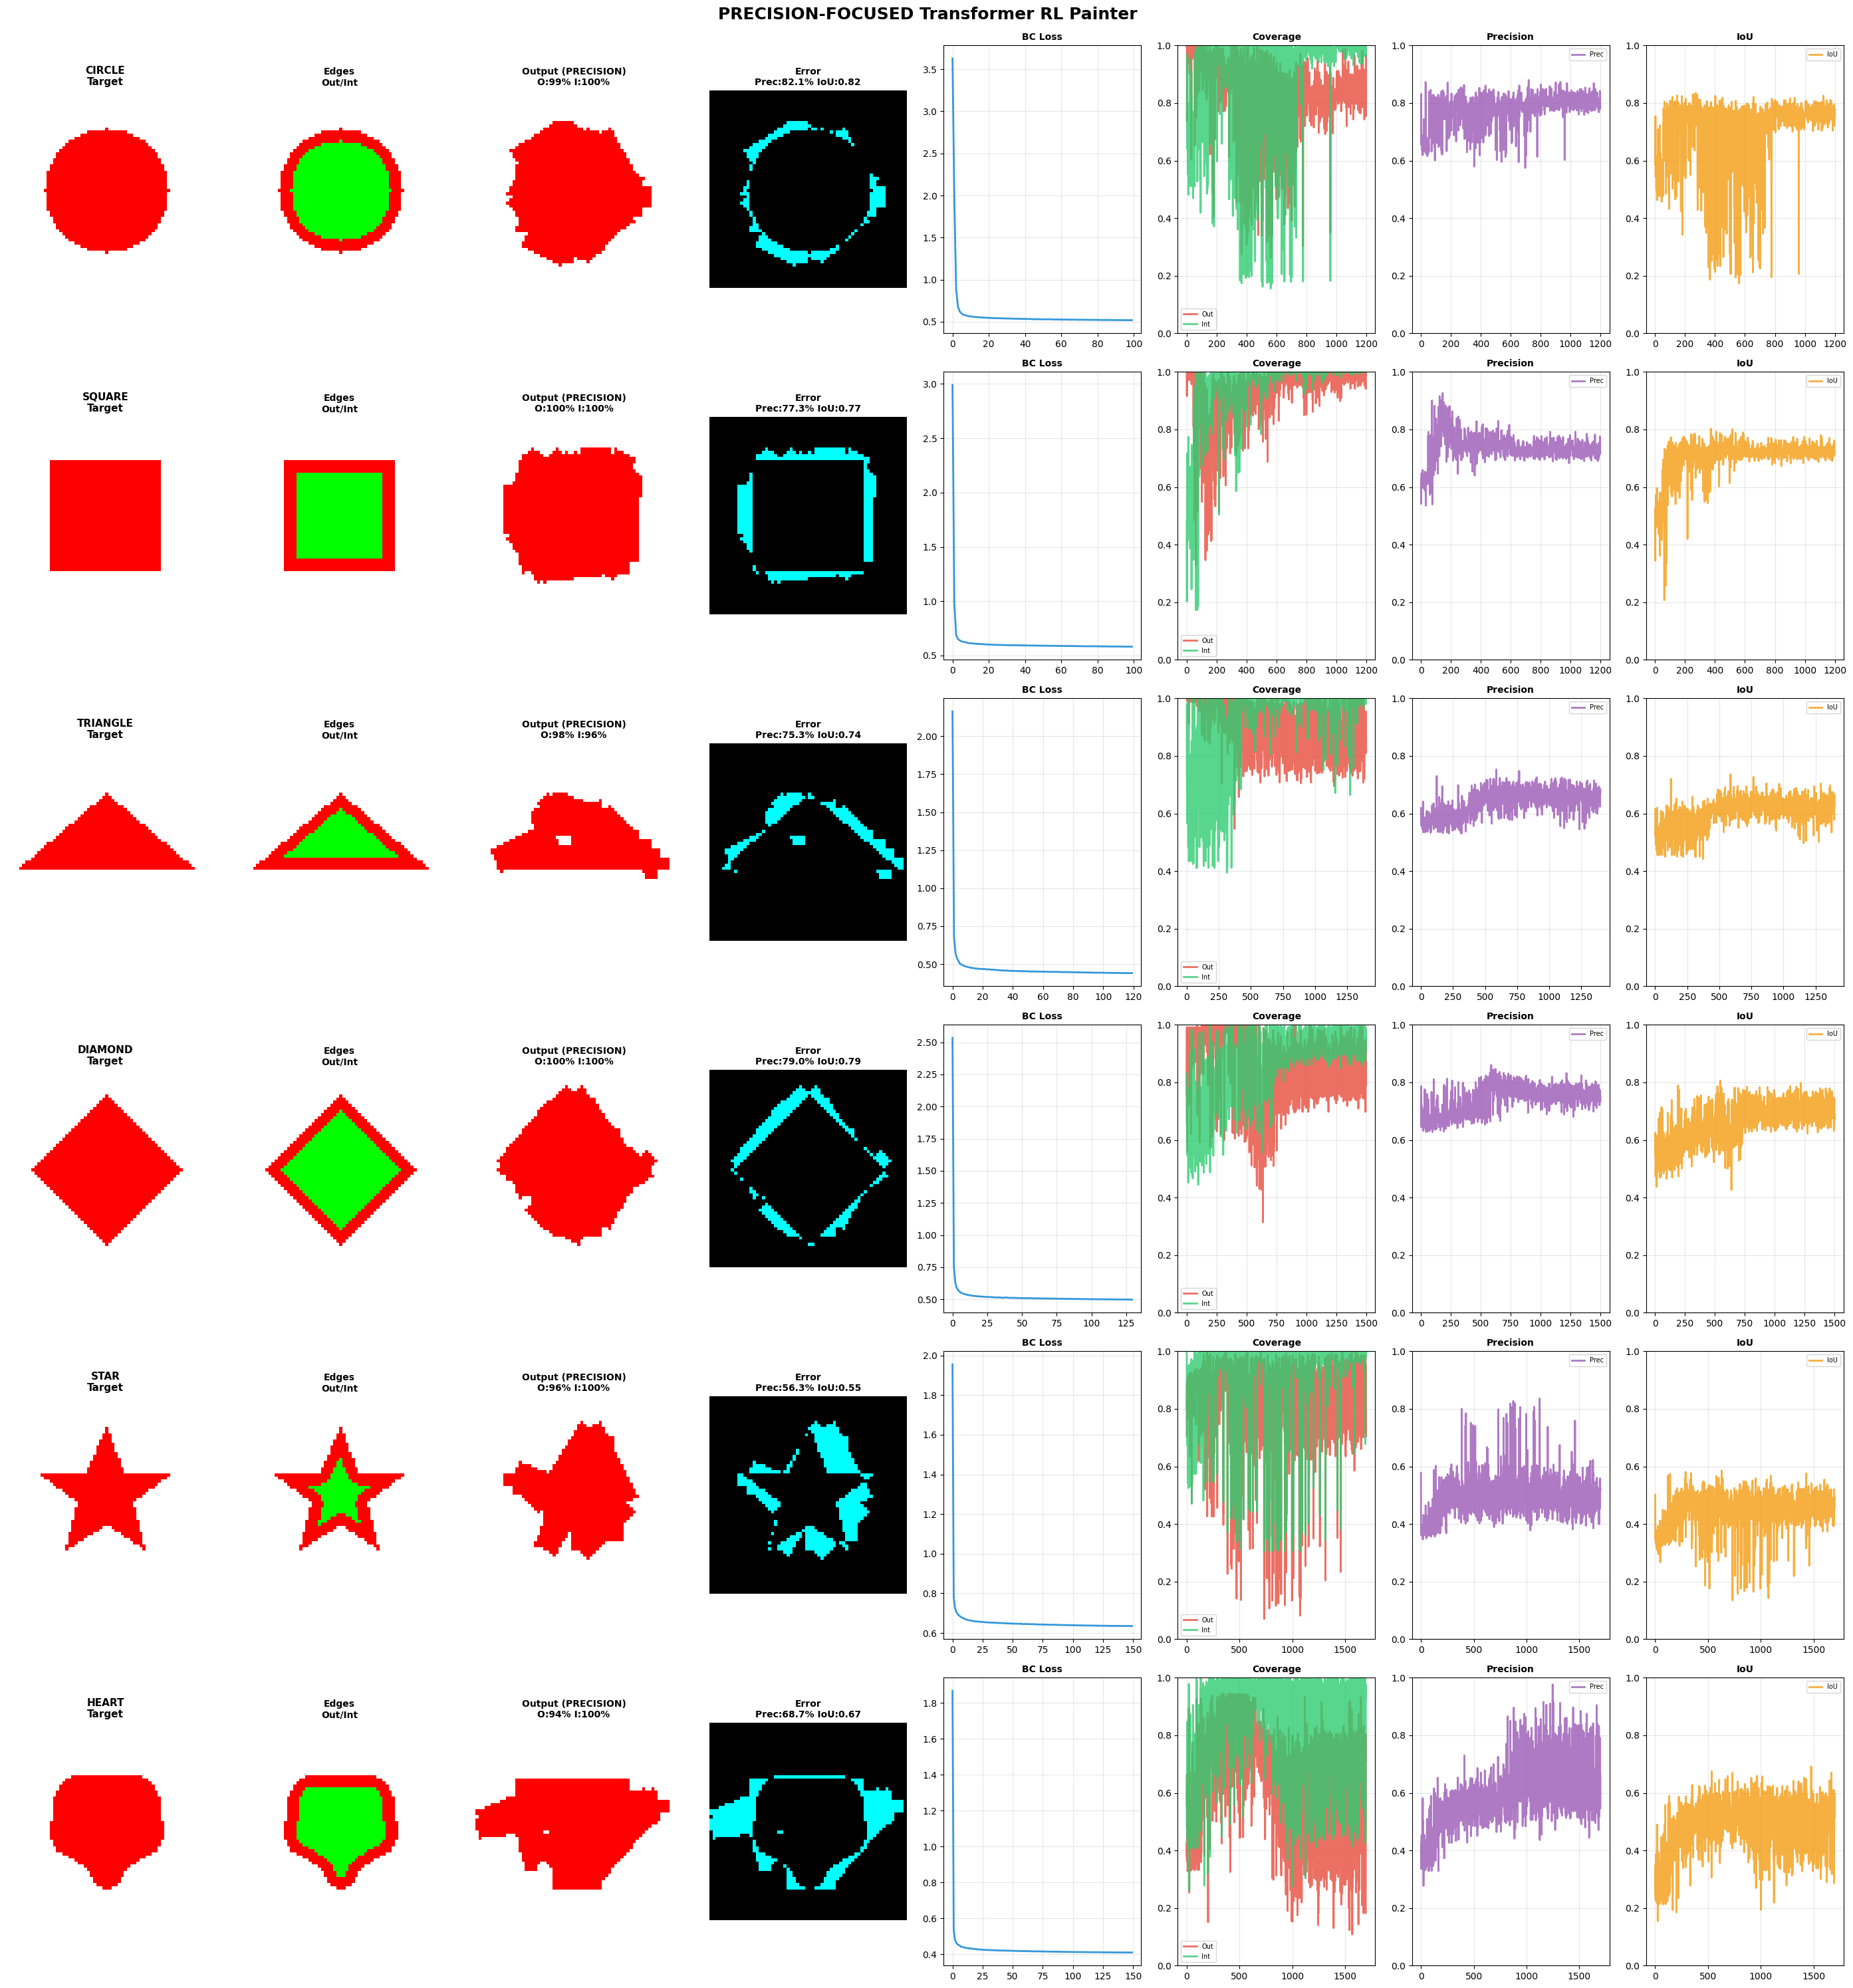

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
import torch.nn.functional as F
from scipy import ndimage
from skimage import morphology
import math
import os

# GPU Setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"🖥️  Using device: {device}")
if torch.cuda.is_available():
    print(f"   GPU: {torch.cuda.get_device_name(0)}")
    print(f"   Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")


class CoverageDrawingEnv:
    """Drawing environment with PRECISION FOCUS"""
    def __init__(self, canvas_size=64, grid_size=20, target_color=[1.0, 0.0, 0.0]):
        self.canvas_size = canvas_size
        self.grid_size = grid_size
        self.cell_size = canvas_size // grid_size
        self.target_color = np.array(target_color)
        self.target = None
        self.target_mask = None  # NEW: Full target mask for precision checking
        self.target_outline = None
        self.target_interior = None
        self.reset()

    def set_target(self, target):
        """Set target with precision tracking"""
        self.target = target
        # Full target mask (anywhere that should be red)
        self.target_mask = (target[:, :, 0] > 0.5) & (target[:, :, 1] < 0.5) & (target[:, :, 2] < 0.5)

        # Edge detection (same as before)
        distance = ndimage.distance_transform_edt(self.target_mask)
        self.target_outline = (distance > 0) & (distance <= 4)
        self.target_outline = morphology.remove_small_objects(self.target_outline, min_size=2)
        
        eroded_interior = ndimage.binary_erosion(self.target_mask, iterations=4)
        self.target_interior = eroded_interior & ~self.target_outline
        
        # Stats
        outline_px = np.sum(self.target_outline)
        interior_px = np.sum(self.target_interior)
        total_px = np.sum(self.target_mask)
        print(f"  🔍 Edge Detection: Outline={outline_px}px ({outline_px/total_px*100:.1f}%), "
              f"Interior={interior_px}px ({interior_px/total_px*100:.1f}%)")

    def reset(self):
        self.canvas = np.ones((self.canvas_size, self.canvas_size, 3), dtype=np.float32)
        self.cursor_grid_x = self.grid_size // 2
        self.cursor_grid_y = self.grid_size // 2
        self.step_count = 0
        self.trajectory = []
        self.outline_complete = False
        self.last_canvas = self.canvas.copy()
        return self.get_state()

    def compute_coverage(self):
        """Coverage metrics"""
        if self.target is None:
            return 0.0, 0.0, 0.0

        canvas_mask = (self.canvas[:, :, 0] > 0.5) & (self.canvas[:, :, 1] < 0.5) & (self.canvas[:, :, 2] < 0.5)

        outline_coverage = np.sum(self.target_outline & canvas_mask) / max(1, np.sum(self.target_outline))
        interior_coverage = np.sum(self.target_interior & canvas_mask) / max(1, np.sum(self.target_interior))
        
        total_target = np.sum(self.target_outline) + np.sum(self.target_interior)
        total_coverage = np.sum((self.target_outline | self.target_interior) & canvas_mask) / max(1, total_target)

        return outline_coverage, interior_coverage, total_coverage

    def compute_precision_metrics(self):
        """NEW: Compute precision (how much of what we drew is correct)"""
        if self.target is None:
            return 1.0, 1.0
        
        canvas_mask = (self.canvas[:, :, 0] > 0.5) & (self.canvas[:, :, 1] < 0.5) & (self.canvas[:, :, 2] < 0.5)
        
        # Precision: Of all red pixels on canvas, how many are in the target?
        total_canvas_red = np.sum(canvas_mask)
        if total_canvas_red == 0:
            return 1.0, 0.0  # No false positives if nothing drawn
        
        correct_red = np.sum(canvas_mask & self.target_mask)
        precision = correct_red / total_canvas_red
        
        # IoU (Intersection over Union)
        intersection = np.sum(canvas_mask & self.target_mask)
        union = np.sum(canvas_mask | self.target_mask)
        iou = intersection / max(1, union)
        
        return precision, iou

    def get_state(self):
        state = np.zeros((self.canvas_size, self.canvas_size, 7), dtype=np.float32)
        state[:, :, :3] = self.canvas

        cx = self.cursor_grid_x * self.cell_size + self.cell_size // 2
        cy = self.cursor_grid_y * self.cell_size + self.cell_size // 2

        # Cursor position
        for dy in range(-4, 5):
            for dx in range(-4, 5):
                nx, ny = cx + dx, cy + dy
                if 0 <= nx < self.canvas_size and 0 <= ny < self.canvas_size:
                    state[ny, nx, 3] = 1.0

        # Coverage info
        outline_cov, interior_cov, _ = self.compute_coverage()
        state[:, :, 4] = outline_cov
        state[:, :, 5] = interior_cov
        
        # Phase indicator
        phase = 1.0 if outline_cov > 0.70 else 0.0
        state[:, :, 6] = phase

        return state

    def grid_to_canvas(self, grid_x, grid_y):
        canvas_x = grid_x * self.cell_size + self.cell_size // 2
        canvas_y = grid_y * self.cell_size + self.cell_size // 2
        return canvas_x, canvas_y

    def draw_stroke(self, x1, y1, x2, y2):
        x1 = int(np.clip(x1, 0, self.canvas_size - 1))
        y1 = int(np.clip(y1, 0, self.canvas_size - 1))
        x2 = int(np.clip(x2, 0, self.canvas_size - 1))
        y2 = int(np.clip(y2, 0, self.canvas_size - 1))

        self.last_canvas = self.canvas.copy()
        img = Image.fromarray((self.canvas * 255).astype(np.uint8))
        draw = ImageDraw.Draw(img)
        color = tuple((self.target_color * 255).astype(int))

        # REDUCED stroke width: 12 → 8 for better precision
        draw.line([x1, y1, x2, y2], fill=color, width=8)
        self.canvas = np.array(img).astype(np.float32) / 255.0

    def compute_stroke_precision(self):
        """NEW: Measure if the last stroke was mostly inside the target"""
        if self.last_canvas is None:
            return 0.0
        
        # Get pixels that changed
        diff = np.abs(self.canvas - self.last_canvas)
        stroke_mask = diff[:, :, 0] > 0.1
        
        if np.sum(stroke_mask) == 0:
            return 0.0
        
        # How many of the stroke pixels are inside the target?
        correct_pixels = np.sum(stroke_mask & self.target_mask)
        total_pixels = np.sum(stroke_mask)
        
        precision = correct_pixels / total_pixels
        return precision

    def step(self, action):
        prev_x, prev_y = self.grid_to_canvas(self.cursor_grid_x, self.cursor_grid_y)

        if action >= self.grid_size * self.grid_size:
            return self.get_state(), True

        target_grid_x = action % self.grid_size
        target_grid_y = action // self.grid_size

        new_x, new_y = self.grid_to_canvas(target_grid_x, target_grid_y)
        self.draw_stroke(prev_x, prev_y, new_x, new_y)

        self.cursor_grid_x = target_grid_x
        self.cursor_grid_y = target_grid_y
        self.trajectory.append((target_grid_x, target_grid_y))

        self.step_count += 1

        outline_cov, _, _ = self.compute_coverage()
        if outline_cov > 0.80 and not self.outline_complete:
            self.outline_complete = True

        done = self.step_count >= 250

        return self.get_state(), done


# ============================================================================
# TRANSFORMER COMPONENTS (keeping the improved architecture)
# ============================================================================

class PatchEmbedding(nn.Module):
    def __init__(self, img_size=64, patch_size=8, in_channels=7, embed_dim=256):
        super().__init__()
        self.img_size = img_size
        self.patch_size = patch_size
        self.n_patches = (img_size // patch_size) ** 2
        self.proj = nn.Conv2d(in_channels, embed_dim, kernel_size=patch_size, stride=patch_size)
        self.norm = nn.LayerNorm(embed_dim)
        
    def forward(self, x):
        x = self.proj(x)
        x = x.flatten(2)
        x = x.transpose(1, 2)
        x = self.norm(x)
        return x


class PositionalEncoding(nn.Module):
    def __init__(self, embed_dim, n_patches_side=8):
        super().__init__()
        self.embed_dim = embed_dim
        self.n_patches_side = n_patches_side
        self.pos_embed = nn.Parameter(torch.randn(1, n_patches_side * n_patches_side, embed_dim) * 0.02)
        
    def forward(self, x):
        return x + self.pos_embed


class PhaseAwareAttention(nn.Module):
    def __init__(self, embed_dim, num_heads=8, dropout=0.1):
        super().__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads
        assert embed_dim % num_heads == 0
        self.qkv = nn.Linear(embed_dim, embed_dim * 3)
        self.proj = nn.Linear(embed_dim, embed_dim)
        self.dropout = nn.Dropout(dropout)
        self.phase_weight = nn.Parameter(torch.ones(num_heads))
        
    def forward(self, x, phase_signal=None):
        B, N, C = x.shape
        qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, self.head_dim).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]
        attn = (q @ k.transpose(-2, -1)) * (self.head_dim ** -0.5)
        if phase_signal is not None:
            phase_mod = self.phase_weight.view(1, -1, 1, 1) * phase_signal.view(B, 1, 1, 1)
            attn = attn * (1 + 0.2 * phase_mod)
        attn = F.softmax(attn, dim=-1)
        attn = self.dropout(attn)
        x = (attn @ v).transpose(1, 2).reshape(B, N, C)
        x = self.proj(x)
        x = self.dropout(x)
        return x


class FeedForward(nn.Module):
    def __init__(self, embed_dim, hidden_dim, dropout=0.1):
        super().__init__()
        self.fc1 = nn.Linear(embed_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, embed_dim)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        x = self.fc1(x)
        x = F.gelu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.dropout(x)
        return x


class ImprovedTransformerBlock(nn.Module):
    def __init__(self, embed_dim, num_heads, mlp_ratio=4.0, dropout=0.1):
        super().__init__()
        self.norm1 = nn.LayerNorm(embed_dim)
        self.attn = PhaseAwareAttention(embed_dim, num_heads, dropout)
        self.norm2 = nn.LayerNorm(embed_dim)
        self.mlp = FeedForward(embed_dim, int(embed_dim * mlp_ratio), dropout)
        self.drop_path = nn.Dropout(0.05)
        
    def forward(self, x, phase_signal=None):
        x = x + self.drop_path(self.attn(self.norm1(x), phase_signal))
        x = x + self.drop_path(self.mlp(self.norm2(x)))
        return x


class ImprovedVisionTransformer(nn.Module):
    def __init__(self, img_size=64, patch_size=8, in_channels=7, embed_dim=256, 
                 depth=8, num_heads=8, mlp_ratio=4.0, dropout=0.1):
        super().__init__()
        self.patch_embed = PatchEmbedding(img_size, patch_size, in_channels, embed_dim)
        self.pos_embed = PositionalEncoding(embed_dim, img_size // patch_size)
        self.dropout = nn.Dropout(dropout)
        self.blocks = nn.ModuleList([
            ImprovedTransformerBlock(embed_dim, num_heads, mlp_ratio, dropout)
            for _ in range(depth)
        ])
        self.norm = nn.LayerNorm(embed_dim)
        self.cls_token = nn.Parameter(torch.randn(1, 1, embed_dim) * 0.02)
        self.phase_token = nn.Parameter(torch.randn(1, 1, embed_dim) * 0.02)
        
    def forward(self, x):
        B = x.shape[0]
        phase_signal = x[:, 6, 0, 0]
        x = self.patch_embed(x)
        x = self.pos_embed(x)
        cls_tokens = self.cls_token.expand(B, -1, -1)
        phase_tokens = self.phase_token.expand(B, -1, -1)
        x = torch.cat([cls_tokens, phase_tokens, x], dim=1)
        x = self.dropout(x)
        for block in self.blocks:
            x = block(x, phase_signal)
        x = self.norm(x)
        return x


class ImprovedTransformerPolicy(nn.Module):
    def __init__(self, canvas_size=64, grid_size=20, patch_size=8, embed_dim=256, 
                 depth=8, num_heads=8, mlp_ratio=4.0, dropout=0.1):
        super().__init__()
        self.grid_size = grid_size
        self.num_actions = grid_size * grid_size + 1
        self.embed_dim = embed_dim
        
        self.encoder = ImprovedVisionTransformer(
            img_size=canvas_size, patch_size=patch_size, in_channels=7,
            embed_dim=embed_dim, depth=depth, num_heads=num_heads,
            mlp_ratio=mlp_ratio, dropout=dropout
        )
        
        self.action_head = nn.Sequential(
            nn.Linear(embed_dim * 2, 512),
            nn.LayerNorm(512),
            nn.GELU(),
            nn.Dropout(0.1),
            nn.Linear(512, 256),
            nn.LayerNorm(256),
            nn.GELU(),
            nn.Dropout(0.05),
            nn.Linear(256, self.num_actions)
        )
        
        self.value_head = nn.Sequential(
            nn.Linear(embed_dim * 2, 256),
            nn.LayerNorm(256),
            nn.GELU(),
            nn.Dropout(0.05),
            nn.Linear(256, 128),
            nn.GELU(),
            nn.Linear(128, 1)
        )
        
        self._init_weights()
        
    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.trunc_normal_(m.weight, std=0.02)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.LayerNorm):
                nn.init.constant_(m.weight, 1.0)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, state):
        if len(state.shape) == 3:
            state = state.unsqueeze(0)
        state = state.permute(0, 3, 1, 2)
        features = self.encoder(state)
        cls_token = features[:, 0]
        phase_token = features[:, 1]
        combined = torch.cat([cls_token, phase_token], dim=1)
        action_logits = self.action_head(combined)
        value = self.value_head(combined)
        return action_logits, value


# ============================================================================
# SHAPE GENERATORS
# ============================================================================

class ShapeGenerator:
    @staticmethod
    def create_circle(canvas_size=64):
        target = np.ones((canvas_size, canvas_size, 3), dtype=np.float32)
        y, x = np.ogrid[:canvas_size, :canvas_size]
        mask = (x - canvas_size//2)**2 + (y - canvas_size//2)**2 <= 20**2
        target[mask] = [1.0, 0.0, 0.0]
        return target, "Circle"

    @staticmethod
    def create_square(canvas_size=64):
        target = np.ones((canvas_size, canvas_size, 3), dtype=np.float32)
        size = 36
        start = (canvas_size - size) // 2
        end = start + size
        target[start:end, start:end] = [1.0, 0.0, 0.0]
        return target, "Square"

    @staticmethod
    def create_triangle(canvas_size=64):
        target = np.ones((canvas_size, canvas_size, 3), dtype=np.float32)
        img = Image.fromarray((target * 255).astype(np.uint8))
        draw = ImageDraw.Draw(img)
        center = canvas_size // 2
        size = 28
        height = int(size * np.sqrt(3) / 2)
        points = [
            (center, center - height * 2 // 3),
            (center - size, center + height // 3),
            (center + size, center + height // 3)
        ]
        draw.polygon(points, fill=(255, 0, 0))
        target = np.array(img).astype(np.float32) / 255.0
        return target, "Triangle"

    @staticmethod
    def create_diamond(canvas_size=64):
        target = np.ones((canvas_size, canvas_size, 3), dtype=np.float32)
        img = Image.fromarray((target * 255).astype(np.uint8))
        draw = ImageDraw.Draw(img)
        center = canvas_size // 2
        size = 24
        points = [
            (center, center - size),
            (center + size, center),
            (center, center + size),
            (center - size, center)
        ]
        draw.polygon(points, fill=(255, 0, 0))
        target = np.array(img).astype(np.float32) / 255.0
        return target, "Diamond"

    @staticmethod
    def create_star(canvas_size=64):
        target = np.ones((canvas_size, canvas_size, 3), dtype=np.float32)
        img = Image.fromarray((target * 255).astype(np.uint8))
        draw = ImageDraw.Draw(img)
        center = canvas_size // 2
        outer_radius = 22
        inner_radius = 9
        points = []
        for i in range(10):
            angle = i * np.pi / 5 - np.pi / 2
            r = outer_radius if i % 2 == 0 else inner_radius
            x = center + r * np.cos(angle)
            y = center + r * np.sin(angle)
            points.append((x, y))
        draw.polygon(points, fill=(255, 0, 0))
        target = np.array(img).astype(np.float32) / 255.0
        return target, "Star"

    @staticmethod
    def create_heart(canvas_size=64):
        target = np.ones((canvas_size, canvas_size, 3), dtype=np.float32)
        y, x = np.ogrid[:canvas_size, :canvas_size]
        center_x, center_y = canvas_size // 2, canvas_size // 2 + 3
        scale = 15
        mask = np.zeros((canvas_size, canvas_size), dtype=bool)
        for i in range(canvas_size):
            for j in range(canvas_size):
                nx = (j - center_x) / scale
                ny = -(i - center_y) / scale
                val = (nx**2 + ny**2 - 1)**3 - nx**2 * ny**3
                if val <= 0.1:
                    mask[i, j] = True
        target[mask] = [1.0, 0.0, 0.0]
        return target, "Heart"


class ImprovedExpertDemonstrator:
    def __init__(self, canvas_size=64, grid_size=20, shape_type="circle"):
        self.canvas_size = canvas_size
        self.grid_size = grid_size
        self.cell_size = canvas_size // grid_size
        self.shape_type = shape_type.lower()

    def canvas_to_grid(self, x, y):
        grid_x = int(x / self.cell_size)
        grid_y = int(y / self.cell_size)
        return np.clip(grid_x, 0, self.grid_size - 1), np.clip(grid_y, 0, self.grid_size - 1)

    def generate_circle_demo(self):
        center_x, center_y, radius = self.canvas_size // 2, self.canvas_size // 2, 20
        trajectory = []
        for angle in np.linspace(0, 2 * np.pi, 200, endpoint=False):
            x = center_x + radius * np.cos(angle)
            y = center_y + radius * np.sin(angle)
            trajectory.append(self.canvas_to_grid(x, y))
        for spiral_idx in range(6):
            r = radius - 4 - (spiral_idx * 3.2)
            if r < 2:
                break
            num_points = max(40, int(70 * (r / radius)))
            for angle in np.linspace(0, 2 * np.pi, num_points, endpoint=False):
                x = center_x + r * np.cos(angle)
                y = center_y + r * np.sin(angle)
                trajectory.append(self.canvas_to_grid(x, y))
        return self._to_actions(trajectory)

    def generate_square_demo(self):
        size, start, end = 36, (self.canvas_size - 36) // 2, (self.canvas_size - 36) // 2 + 36
        trajectory = []
        for i in range(60):
            trajectory.append(self.canvas_to_grid(start + (end - start) * i / 60, start))
        for i in range(60):
            trajectory.append(self.canvas_to_grid(end, start + (end - start) * i / 60))
        for i in range(60):
            trajectory.append(self.canvas_to_grid(end - (end - start) * i / 60, end))
        for i in range(60):
            trajectory.append(self.canvas_to_grid(start, end - (end - start) * i / 60))
        for i in range(16):
            y = start + 4 + (end - start - 8) * i / 16
            for j in range(16):
                x = start + 4 + (end - start - 8) * j / 16
                trajectory.append(self.canvas_to_grid(x, y))
        return self._to_actions(trajectory)

    def generate_triangle_demo(self):
        center, size = self.canvas_size // 2, 28
        height = int(size * np.sqrt(3) / 2)
        top = (center, center - height * 2 // 3)
        left = (center - size, center + height // 3)
        right = (center + size, center + height // 3)
        trajectory = []
        for i in range(70):
            t = i / 70
            trajectory.append(self.canvas_to_grid(top[0] + (right[0] - top[0]) * t, top[1] + (right[1] - top[1]) * t))
        for i in range(70):
            t = i / 70
            trajectory.append(self.canvas_to_grid(right[0] + (left[0] - right[0]) * t, right[1] + (left[1] - right[1]) * t))
        for i in range(70):
            t = i / 70
            trajectory.append(self.canvas_to_grid(left[0] + (top[0] - left[0]) * t, left[1] + (top[1] - left[1]) * t))
        for i in range(18):
            t = (i + 1) / 19
            y = top[1] + (left[1] - top[1]) * t
            left_x = left[0] + (top[0] - left[0]) * (1 - t)
            right_x = right[0] + (top[0] - right[0]) * (1 - t)
            line_points = max(12, int(24 * (1 - t)))
            for j in range(line_points):
                x = left_x + (right_x - left_x) * j / line_points
                trajectory.append(self.canvas_to_grid(x, y))
        return self._to_actions(trajectory)

    def generate_diamond_demo(self):
        center, size = self.canvas_size // 2, 24
        points = [(center, center - size), (center + size, center),
                  (center, center + size), (center - size, center)]
        trajectory = []
        for i in range(4):
            start_point, end_point = points[i], points[(i + 1) % 4]
            for j in range(65):
                t = j / 65
                x = start_point[0] + (end_point[0] - start_point[0]) * t
                y = start_point[1] + (end_point[1] - start_point[1]) * t
                trajectory.append(self.canvas_to_grid(x, y))
        for i in range(12):
            angle = i * 2 * np.pi / 12
            for j in range(1, 16):
                r = size * j / 16
                x = center + r * np.cos(angle)
                y = center + r * np.sin(angle)
                trajectory.append(self.canvas_to_grid(x, y))
        return self._to_actions(trajectory)

    def generate_star_demo(self):
        center, outer_radius, inner_radius = self.canvas_size // 2, 22, 9
        trajectory = []
        for i in range(250):
            progress = i / 250
            angle = progress * 2 * np.pi - np.pi / 2
            segment_progress = (progress * 10) % 1
            segment = int(progress * 10)
            if segment % 2 == 0:
                r = outer_radius if segment_progress < 0.5 else \
                    outer_radius + (inner_radius - outer_radius) * (segment_progress - 0.5) * 2
            else:
                r = inner_radius if segment_progress < 0.5 else \
                    inner_radius + (outer_radius - inner_radius) * (segment_progress - 0.5) * 2
            x = center + r * np.cos(angle)
            y = center + r * np.sin(angle)
            trajectory.append(self.canvas_to_grid(x, y))
        for i in range(18):
            angle = i * 2 * np.pi / 18
            for j in range(14):
                r = 2 + (inner_radius - 2) * j / 14
                x = center + r * np.cos(angle)
                y = center + r * np.sin(angle)
                trajectory.append(self.canvas_to_grid(x, y))
        for r in [7, 5, 3, 2]:
            points = max(30, int(50 * (r / 7)))
            for i in range(points):
                angle = i * 2 * np.pi / points
                x = center + r * np.cos(angle)
                y = center + r * np.sin(angle)
                trajectory.append(self.canvas_to_grid(x, y))
        return self._to_actions(trajectory)

    def generate_heart_demo(self):
        center_x, center_y, scale = self.canvas_size // 2, self.canvas_size // 2 + 3, 15
        trajectory = []
        for i in range(250):
            t = 2 * np.pi * i / 250
            x = center_x + scale * 16 * np.sin(t)**3
            y = center_y - scale * (13 * np.cos(t) - 5 * np.cos(2*t) - 
                                    2 * np.cos(3*t) - np.cos(4*t)) / 16
            trajectory.append(self.canvas_to_grid(x, y))
        for i in range(20):
            t_y = np.pi * (0.2 + 0.6 * i / 20)
            y = center_y - scale * (13 * np.cos(t_y) - 5 * np.cos(2*t_y) - 
                                    2 * np.cos(3*t_y) - np.cos(4*t_y)) / 16
            line_points = max(8, int(24 * (1 - abs(i - 10) / 20)))
            for j in range(line_points):
                x_offset = (j / line_points - 0.5) * scale * 2.6
                x = center_x + x_offset
                trajectory.append(self.canvas_to_grid(x, y))
        return self._to_actions(trajectory)

    def _to_actions(self, trajectory):
        actions = [grid_y * self.grid_size + grid_x for grid_x, grid_y in trajectory]
        actions.append(self.grid_size * self.grid_size)
        return actions

    def generate_demonstration(self):
        demos = {
            "circle": self.generate_circle_demo,
            "square": self.generate_square_demo,
            "triangle": self.generate_triangle_demo,
            "diamond": self.generate_diamond_demo,
            "star": self.generate_star_demo,
            "heart": self.generate_heart_demo
        }
        return demos[self.shape_type]()

    def generate_demonstrations(self, num_demos):
        print(f"\n📚 Generating Expert Demos for {self.shape_type.upper()}")
        print("="*70)
        all_demos = []
        for i in range(num_demos):
            demo = self.generate_demonstration()
            if i > 0 and len(demo) > 51:
                outline_len = min(180, len(demo) // 3)
                offset = np.random.randint(0, outline_len // 2)
                outline = demo[:outline_len]
                fill = demo[outline_len:-1]
                stop = demo[-1]
                demo = outline[offset:] + outline[:offset] + fill + [stop]
            all_demos.append(demo)
        avg_len = np.mean([len(d) for d in all_demos])
        print(f"✓ Generated {num_demos} demos (avg: {avg_len:.0f} steps)")
        print("="*70)
        return all_demos


# UPDATED configs with precision focus
SHAPE_CONFIGS = {
    "circle": {"bc_epochs": 100, "rl_episodes": 1200, "outline_w": 500, "interior_w": 250, 
               "precision_w": 400, "num_demos": 90, "diff": 1},
    "square": {"bc_epochs": 100, "rl_episodes": 1200, "outline_w": 500, "interior_w": 250, 
               "precision_w": 400, "num_demos": 90, "diff": 1},
    "triangle": {"bc_epochs": 120, "rl_episodes": 1400, "outline_w": 600, "interior_w": 300, 
                 "precision_w": 450, "num_demos": 110, "diff": 2},
    "diamond": {"bc_epochs": 130, "rl_episodes": 1500, "outline_w": 650, "interior_w": 350, 
                "precision_w": 500, "num_demos": 120, "diff": 3},
    "star": {"bc_epochs": 150, "rl_episodes": 1700, "outline_w": 750, "interior_w": 400, 
             "precision_w": 550, "num_demos": 140, "diff": 4},
    "heart": {"bc_epochs": 150, "rl_episodes": 1700, "outline_w": 750, "interior_w": 400, 
              "precision_w": 550, "num_demos": 140, "diff": 4}
}


class PrecisionTrainer:
    """Trainer with PRECISION FOCUS (no bleeding!)"""
    def __init__(self, target_image, shape_name, canvas_size=64, grid_size=20, device='cpu'):
        self.device = torch.device(device)
        self.env = CoverageDrawingEnv(canvas_size, grid_size)
        
        print("🤖 Initializing Precision-Focused Transformer Policy...")
        self.policy = ImprovedTransformerPolicy(
            canvas_size=canvas_size, grid_size=grid_size, patch_size=8,
            embed_dim=256, depth=8, num_heads=8, mlp_ratio=4.0, dropout=0.1
        ).to(self.device)
        
        total_params = sum(p.numel() for p in self.policy.parameters())
        trainable_params = sum(p.numel() for p in self.policy.parameters() if p.requires_grad)
        print(f"   Total: {total_params:,} | Trainable: {trainable_params:,}")
        
        self.optimizer = optim.AdamW(self.policy.parameters(), lr=2e-4, weight_decay=0.01)
        self.scheduler = optim.lr_scheduler.CosineAnnealingLR(self.optimizer, T_max=150)
        
        self.shape_name = shape_name.lower()
        self.config = SHAPE_CONFIGS[self.shape_name]

        self.target = target_image if isinstance(target_image, np.ndarray) else \
                      np.array(target_image.resize((canvas_size, canvas_size))).astype(np.float32) / 255.0

        self.env.set_target(self.target)
        self.expert = ImprovedExpertDemonstrator(canvas_size, grid_size, self.shape_name)

        # Best tracking with precision
        self.best_score = 0.0  # Combined score
        self.best_canvas = None
        self.best_outline_cov = 0.0
        self.best_interior_cov = 0.0
        self.best_precision = 0.0
        self.best_iou = 0.0
        
        self.mse_history = []
        self.outline_history = []
        self.interior_history = []
        self.precision_history = []
        self.iou_history = []
        self.bc_losses = []

        print(f"✓ Config: BC={self.config['bc_epochs']}, RL={self.config['rl_episodes']}, "
              f"Demos={self.config['num_demos']}, Precision Weight={self.config['precision_w']}")

    def collect_expert_data(self):
        demos = self.expert.generate_demonstrations(self.config['num_demos'])
        states, actions = [], []
        for demo in demos:
            state = self.env.reset()
            for action in demo[:-1]:
                states.append(state)
                actions.append(action)
                state, _ = self.env.step(action)
        print(f"✓ Collected {len(states)} state-action pairs")
        return states, actions

    def behavioral_cloning(self, states, actions, batch_size=32):
        epochs = self.config['bc_epochs']
        print(f"\n🎓 Phase 1: BC ({epochs} epochs)")
        print("="*70)
        dataset_size = len(states)

        for epoch in range(epochs):
            total_loss, num_batches = 0, 0
            indices = list(range(dataset_size))
            np.random.shuffle(indices)

            for i in range(0, dataset_size, batch_size):
                batch_idx = indices[i:i+batch_size]
                batch_states = torch.FloatTensor(np.array([states[idx] for idx in batch_idx])).to(self.device)
                batch_actions = torch.LongTensor(np.array([actions[idx] for idx in batch_idx])).to(self.device)

                action_logits, _ = self.policy(batch_states)
                loss = F.cross_entropy(action_logits, batch_actions)

                self.optimizer.zero_grad()
                loss.backward()
                torch.nn.utils.clip_grad_norm_(self.policy.parameters(), 1.0)
                self.optimizer.step()

                total_loss += loss.item()
                num_batches += 1

                del batch_states, batch_actions
                if torch.cuda.is_available():
                    torch.cuda.empty_cache()

            self.scheduler.step()
            avg_loss = total_loss / num_batches
            self.bc_losses.append(avg_loss)

            if epoch % 20 == 0 or epoch == epochs - 1:
                metrics = self.test_policy()
                print(f"Ep {epoch:3d} | Loss: {avg_loss:.4f} | "
                      f"Out: {metrics['out']:.1%} | Int: {metrics['int']:.1%} | "
                      f"Prec: {metrics['prec']:.1%} | IoU: {metrics['iou']:.3f}")

        print("✓ BC Complete!\n")

    def test_policy(self):
        """Test policy and UPDATE best if improved"""
        state = self.env.reset()
        done = False

        with torch.no_grad():
            while not done:
                state_tensor = torch.FloatTensor(state).to(self.device)
                action_logits, _ = self.policy(state_tensor)
                action = torch.argmax(action_logits).item()
                state, done = self.env.step(action)

        out_cov, int_cov, _ = self.env.compute_coverage()
        precision, iou = self.env.compute_precision_metrics()
        
        # NEW: Combined score that balances coverage AND precision
        score = (out_cov * 0.35 + int_cov * 0.25 + precision * 0.25 + iou * 0.15)
        
        if score > self.best_score:
            self.best_score = score
            self.best_canvas = self.env.canvas.copy()
            self.best_outline_cov = out_cov
            self.best_interior_cov = int_cov
            self.best_precision = precision
            self.best_iou = iou

        return {'out': out_cov, 'int': int_cov, 'prec': precision, 'iou': iou}

    def compute_reward(self, prev_out, prev_int, prev_prec, curr_out, curr_int, curr_prec, 
                      done, step_count, env):
        """NEW: Reward function with HEAVY precision penalties"""
        out_w = self.config['outline_w']
        int_w = self.config['interior_w']
        prec_w = self.config['precision_w']
        
        # Coverage rewards (same as before)
        outline_reward = (curr_out - prev_out) * out_w
        interior_reward = (curr_int - prev_int) * (int_w if curr_out > 0.65 else 80)
        
        # NEW: PRECISION REWARD - this is critical!
        precision_reward = (curr_prec - prev_prec) * prec_w
        
        # PENALTY for low precision (drawing outside)
        if curr_prec < 0.80:
            precision_penalty = -200 * (0.80 - curr_prec)  # Up to -200 points
        else:
            precision_penalty = 0
        
        # Stroke precision check
        stroke_prec = env.compute_stroke_precision()
        if stroke_prec < 0.70:  # More than 30% of stroke was outside
            stroke_penalty = -150 * (0.70 - stroke_prec)
        else:
            stroke_penalty = stroke_prec * 20  # Small bonus for good strokes
        
        # Phase bonus
        phase_bonus = 150.0 if (curr_out > 0.80 and prev_out <= 0.80) else 0.0
        
        # Completion rewards/penalties
        if done:
            _, iou = env.compute_precision_metrics()
            if curr_prec > 0.92 and iou > 0.85:
                completion = 400.0  # Excellent precision!
            elif curr_prec > 0.85 and iou > 0.75:
                completion = 200.0
            elif curr_prec < 0.75:
                completion = -300.0  # Heavy penalty for poor precision
            else:
                completion = 50.0
        else:
            completion = 0.0
        
        temporal_penalty = -0.3 if len(env.trajectory) > 1 else 0.0
        
        total = (outline_reward + interior_reward + precision_reward + 
                precision_penalty + stroke_penalty + phase_bonus + 
                completion + temporal_penalty)
        
        return total

    def rl_finetune(self):
        episodes = self.config['rl_episodes']
        print(f"🚀 Phase 2: RL with Precision Focus ({episodes} episodes)")
        print("="*70)

        self.optimizer = optim.AdamW(self.policy.parameters(), lr=8e-5, weight_decay=0.01)
        self.scheduler = optim.lr_scheduler.CosineAnnealingLR(self.optimizer, T_max=episodes)

        for episode in range(episodes):
            state = self.env.reset()
            prev_out, prev_int, _ = self.env.compute_coverage()
            prev_prec, _ = self.env.compute_precision_metrics()
            
            states, actions, rewards, log_probs, values, entropies = [], [], [], [], [], []
            done, episode_reward = False, 0

            while not done:
                state_tensor = torch.FloatTensor(state).to(self.device)
                action_logits, value = self.policy(state_tensor)
                action_dist = torch.distributions.Categorical(logits=action_logits)
                action = action_dist.sample()
                log_prob = action_dist.log_prob(action)
                entropy = action_dist.entropy()
                
                next_state, done = self.env.step(action.item())
                curr_out, curr_int, _ = self.env.compute_coverage()
                curr_prec, _ = self.env.compute_precision_metrics()
                
                reward = self.compute_reward(prev_out, prev_int, prev_prec,
                                            curr_out, curr_int, curr_prec,
                                            done, self.env.step_count, self.env)

                states.append(state)
                actions.append(action)
                rewards.append(reward)
                log_probs.append(log_prob)
                values.append(value)
                entropies.append(entropy)

                episode_reward += reward
                prev_out, prev_int, prev_prec = curr_out, curr_int, curr_prec
                state = next_state

            # Compute returns
            returns = []
            G = 0
            for r in reversed(rewards):
                G = r + 0.99 * G
                returns.insert(0, G)

            returns = torch.FloatTensor(returns).to(self.device)
            if len(returns) > 1:
                returns = (returns - returns.mean()) / (returns.std() + 1e-8)

            # Optimize
            policy_loss, value_loss, entropy_loss = 0, 0, 0
            for log_prob, value, ret, entropy in zip(log_probs, values, returns, entropies):
                advantage = ret - value.squeeze().detach()
                policy_loss = policy_loss - log_prob * advantage
                value_loss = value_loss + F.mse_loss(value.squeeze(), ret)
                entropy_loss = entropy_loss - entropy

            policy_loss = policy_loss / len(log_probs)
            value_loss = value_loss / len(values)
            entropy_loss = entropy_loss / len(entropies)
            loss = policy_loss + 0.5 * value_loss + 0.02 * entropy_loss

            self.optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(self.policy.parameters(), 0.5)
            self.optimizer.step()
            self.scheduler.step()

            # Track metrics
            final_out, final_int, _ = self.env.compute_coverage()
            final_prec, final_iou = self.env.compute_precision_metrics()
            
            # Update best
            score = (final_out * 0.35 + final_int * 0.25 + final_prec * 0.25 + final_iou * 0.15)
            if score > self.best_score:
                self.best_score = score
                self.best_canvas = self.env.canvas.copy()
                self.best_outline_cov = final_out
                self.best_interior_cov = final_int
                self.best_precision = final_prec
                self.best_iou = final_iou

            self.outline_history.append(final_out)
            self.interior_history.append(final_int)
            self.precision_history.append(final_prec)
            self.iou_history.append(final_iou)

            if episode % 100 == 0 or episode == episodes - 1:
                print(f"Ep {episode:4d} | R: {episode_reward:7.2f} | "
                      f"Out: {final_out:5.1%} | Int: {final_int:5.1%} | "
                      f"Prec: {final_prec:5.1%} | IoU: {final_iou:.3f} | Steps: {self.env.step_count:3d}")

        print("✓ RL Complete!\n")

    def train(self):
        print("\n" + "="*70)
        print(f"TRAINING: {self.shape_name.upper()} {'⭐'*self.config['diff']} (PRECISION FOCUS)")
        print("="*70)

        states, actions = self.collect_expert_data()
        self.behavioral_cloning(states, actions)
        self.rl_finetune()

        if self.best_canvas is None:
            print("⚠️  WARNING: No best canvas saved! Using current env canvas.")
            self.best_canvas = self.env.canvas.copy()
        
        return self.best_canvas


def train_simple_to_complex(canvas_size=64, grid_size=20, device='cpu'):
    """Train with precision focus"""
    shapes = [
        ("circle", ShapeGenerator.create_circle),
        ("square", ShapeGenerator.create_square),
        ("triangle", ShapeGenerator.create_triangle),
        ("diamond", ShapeGenerator.create_diamond),
        ("star", ShapeGenerator.create_star),
        ("heart", ShapeGenerator.create_heart),
    ]
    
    results = []
    
    for shape_name, shape_func in shapes:
        print("\n" + "🎨"*35)
        print(f"SHAPE: {shape_name.upper()}")
        print("🎨"*35)
        
        target, _ = shape_func(canvas_size)
        trainer = PrecisionTrainer(target, shape_name, canvas_size, grid_size, device)
        final_canvas = trainer.train()
        
        results.append({
            'name': shape_name,
            'target': target,
            'canvas': final_canvas,
            'outline_cov': trainer.best_outline_cov,
            'interior_cov': trainer.best_interior_cov,
            'precision': trainer.best_precision,
            'iou': trainer.best_iou,
            'outline_history': trainer.outline_history,
            'interior_history': trainer.interior_history,
            'precision_history': trainer.precision_history,
            'iou_history': trainer.iou_history,
            'bc_losses': trainer.bc_losses,
            'outline_mask': trainer.env.target_outline,
            'interior_mask': trainer.env.target_interior
        })
        
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
    
    return results


def visualize_results(results, save_dir="."):
    """Visualization with precision metrics"""
    n = len(results)
    fig = plt.figure(figsize=(28, 5*n))
    
    for idx, r in enumerate(results):
        # Target
        ax = plt.subplot(n, 8, idx*8 + 1)
        ax.imshow(r['target'])
        ax.set_title(f"{r['name'].upper()}\nTarget", fontsize=11, fontweight='bold')
        ax.axis('off')
        
        # Edge detection
        ax = plt.subplot(n, 8, idx*8 + 2)
        edge_viz = np.ones((64, 64, 3))
        edge_viz[r['outline_mask']] = [1, 0, 0]
        edge_viz[r['interior_mask']] = [0, 1, 0]
        ax.imshow(edge_viz)
        ax.set_title(f"Edges\nOut/Int", fontsize=10, fontweight='bold')
        ax.axis('off')
        
        # Output
        ax = plt.subplot(n, 8, idx*8 + 3)
        ax.imshow(r['canvas'])
        ax.set_title(f"Output (PRECISION)\nO:{r['outline_cov']:.0%} I:{r['interior_cov']:.0%}", 
                    fontsize=10, fontweight='bold')
        ax.axis('off')
        
        # Error
        ax = plt.subplot(n, 8, idx*8 + 4)
        diff = np.abs(r['target'] - r['canvas'])
        ax.imshow(diff, cmap='hot')
        ax.set_title(f"Error\nPrec:{r['precision']:.1%} IoU:{r['iou']:.2f}", 
                    fontsize=10, fontweight='bold')
        ax.axis('off')
        
        # BC Loss
        ax = plt.subplot(n, 8, idx*8 + 5)
        if r['bc_losses']:
            ax.plot(r['bc_losses'], linewidth=2, color='#3498db')
            ax.set_title('BC Loss', fontsize=10, fontweight='bold')
            ax.grid(True, alpha=0.3)
        
        # Coverage
        ax = plt.subplot(n, 8, idx*8 + 6)
        if r['outline_history']:
            ax.plot(r['outline_history'], linewidth=2, color='#e74c3c', label='Out', alpha=0.8)
            ax.plot(r['interior_history'], linewidth=2, color='#2ecc71', label='Int', alpha=0.8)
            ax.set_title('Coverage', fontsize=10, fontweight='bold')
            ax.set_ylim([0, 1])
            ax.legend(fontsize=7)
            ax.grid(True, alpha=0.3)
        
        # Precision
        ax = plt.subplot(n, 8, idx*8 + 7)
        if r['precision_history']:
            ax.plot(r['precision_history'], linewidth=2, color='#9b59b6', label='Prec', alpha=0.8)
            ax.set_title('Precision', fontsize=10, fontweight='bold')
            ax.set_ylim([0, 1])
            ax.legend(fontsize=7)
            ax.grid(True, alpha=0.3)
        
        # IoU
        ax = plt.subplot(n, 8, idx*8 + 8)
        if r['iou_history']:
            ax.plot(r['iou_history'], linewidth=2, color='#f39c12', label='IoU', alpha=0.8)
            ax.set_title('IoU', fontsize=10, fontweight='bold')
            ax.set_ylim([0, 1])
            ax.legend(fontsize=7)
            ax.grid(True, alpha=0.3)
    
    plt.suptitle("PRECISION-FOCUSED Transformer RL Painter", 
                fontsize=18, y=0.995, fontweight='bold')
    plt.tight_layout()
    
    output_path = os.path.join(save_dir, 'precision_focused_results.png')
    plt.savefig(output_path, dpi=150, bbox_inches='tight')
    print(f"\n✅ Saved: {output_path}")


# MAIN EXECUTION
if __name__ == "__main__":
    print("\n" + "="*70)
    print("🎯 PRECISION-FOCUSED TRANSFORMER RL PAINTER")
    print("="*70)
    print("\n✨ KEY IMPROVEMENTS:")
    print("  1. Precision penalties (heavy cost for drawing outside)")
    print("  2. Reduced stroke width (12 → 8 pixels)")
    print("  3. IoU + Precision metrics in reward")
    print("  4. Combined score balances coverage + accuracy")
    print("="*70)
    
    results = train_simple_to_complex(canvas_size=64, grid_size=20, device=device)
    
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
    
    visualize_results(results, save_dir=".")
    
    print("\n" + "="*70)
    print("✅ PRECISION-FOCUSED TRAINING COMPLETE!")
    print("="*70)
    print(f"{'Shape':12} {'Diff':6} {'Outline':9} {'Interior':9} {'Precision':10} {'IoU':6}")
    print("-"*70)
    for r in results:
        stars = '⭐' * SHAPE_CONFIGS[r['name']]['diff']
        print(f"{r['name'].upper():12} {stars:6} {r['outline_cov']:8.1%} "
              f"{r['interior_cov']:8.1%} {r['precision']:9.1%} {r['iou']:6.3f}")
    print("="*70 + "\n")
    
    plt.show()